In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted



g_sequences = {}

g_sequences[0] = ['13524232514' ,'35421252143',  '51423252413', '14325242135'] #Group 1 sequences
g_sequences[1] = ['51423252413', '14325242135', '13524232514' ,'35421252143'] #Group 2 sequences

seq_length = len(g_sequences[0][0]) #Length of sequences

windowSizes = [2, 3, 4, 11]

digit_change = [4, 6, 8] #position of changed digit in changed sequence

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers


iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime = 1500 # msecs for planning before movement 
hand = 2 #left or right hand

total_sub_num = 10

num_pre_train_blocks = 1
num_train_blocks = 4
num_post_train_blocks = 1

num_pre_test_blocks = 1
num_test_blocks = 4 * 4
num_post_test_blocks = 1


test_session2_blocks_nums = list(range(7, 7 + 1 + 2 * 4 + 1))

test_session3_blocks_nums = list(range(17, 17 + 1 + 2 * 4 + 1))


In [2]:
subjs_list = utils.read_dat_files_subjs_list(range(1,total_sub_num+1))

# subjs_list = [utils.remove_error_trials(subj) for subj in subjs_list] ##Removing the error trials

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})


In [3]:
subjs_presses['is_trained_seq'] = subjs_presses.apply(utils.is_trained_seq, axis = 1)
subjs_presses['is_untrained_seq'] = subjs_presses.apply(utils.is_untrained_seq, axis = 1)
subjs_presses['is_rand_seq'] = subjs_presses.apply(utils.is_rand_seq, axis = 1)
subjs_presses['is_digit_changed'] = subjs_presses.apply(utils.is_digit_changed, axis = 1)


subjs['is_trained_seq'] = subjs.apply(utils.is_trained_seq, axis = 1)
subjs['is_untrained_seq'] = subjs.apply(utils.is_untrained_seq, axis = 1)
subjs['is_rand_seq'] = subjs.apply(utils.is_rand_seq, axis = 1)
subjs['is_digit_changed'] = subjs.apply(utils.is_digit_changed, axis = 1)


In [4]:
subjs.to_csv(utils.path_misc+'subjs.csv', index = False, sep = '\t')
subjs_presses.to_csv(utils.path_misc+'subjs_presses.csv', index = False, sep = '\t')

In [5]:
# utils.remove_remaining_next_error_presses(subjs_presses)
# utils.remove_next_error_presses(subjs_presses)

## Sequence Specific Learning in Training:

In [6]:
subjs

BN  TN  SubNum  group  hand  isTrain          seq  digitChangePos  \
0     1   1       1      0     2        1  14325242135               8   
1     1   2       1      0     2        1  35421252143               8   
2     1   3       1      0     2        1  13524232514               8   
3     1   4       1      0     2        1  14325242135               8   
4     1   5       1      0     2        1  51423252413               8   
..   ..  ..     ...    ...   ...      ...          ...             ...   
795  26  28      10      1     2        0  35421252143               6   
796  26  29      10      1     2        0  51423252413               6   
797  26  30      10      1     2        0  13524232514               6   
798  26  31      10      1     2        0  14325242135               6   
799  26  32      10      1     2        0  13524232514               6   

     digitChangeValue  precueTime  ...  IPI6  IPI7  IPI8  IPI9  IPI10  IPI0  \
0                   1        1500  ...   265   215   285   215    195   660   
1                   1        1500  ...   260   250   400   225    220   465   
2                   5        1500  ...   260   235   270   265    175   555   
3                   1        1500  ...   265   230   465   255    875   455   
4                   4        1500  ...   305   240   265   265    190   460   
..                ...         ...  ...   ...   ...   ...   ...    ...   ...   
795                 5        1500  ...   445   540   370  1670    420   545   
796                 5        1500  ...   770   370   515   480    365   910   
797                 3        1500  ...   200  1075   550   425    410   415   
798                 4        1500  ...   700   365   340   555    165   405   
799                 3        1500  ...   385   320   605   780    905   570   

     is_trained_seq  is_untrained_seq  is_rand_seq  is_digit_changed  
0             False              True        False             False  
1              True             False        False             False  
2              True             False        False             False  
3             False              True        False             False  
4             False              True        False             False  
..              ...               ...          ...               ...  
795           False              True        False             False  
796            True             False        False             False  
797           False              True        False             False  
798            True             False        False             False  
799           False              True        False             False  

[8000 rows x 86 columns]

In [7]:
# import statsmodels.stats.power as smp

# # Parameters for power analysis
# effect_size = 5  # Cohen's d
# alpha = 0.05       # Significance level
# power = 0.8        # Power level

# # Calculate the sample size
# sample_size = smp.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

# print(f"Required sample size for two-sample t-test: {sample_size}")


TtestResult(statistic=-0.582433354693741, pvalue=0.5745741103407895, df=9)
TtestResult(statistic=3.268135706190159, pvalue=0.009711609448495306, df=9)


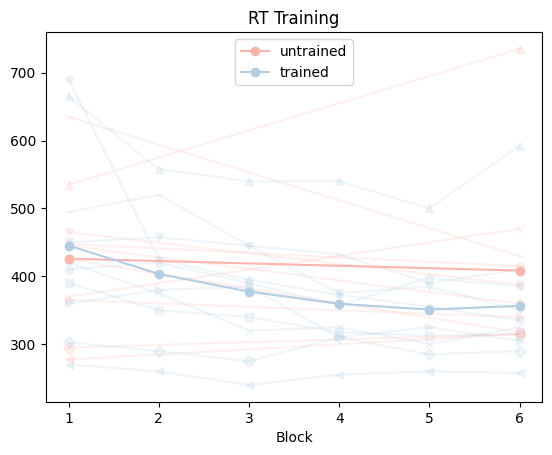

In [8]:
cmap = cm.Pastel1

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']

induction_blocks = subjs[subjs['BN'] <= num_pre_train_blocks+num_train_blocks+num_post_test_blocks]

induction_blocks = utils.remove_error_trials(induction_blocks)

induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'RT': 'median'
}).reset_index()


for _, (subnum, subj_data) in enumerate(induction_grouped.groupby('SubNum')):
    for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
        plt.plot(data['BN'], data['RT'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)



print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['RT'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['RT']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 6) & (induction_grouped['is_trained_seq'] == False)]['RT'], 
                      induction_grouped[(induction_grouped['BN'] == 6) & (induction_grouped['is_trained_seq'] == True)]['RT']))



induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'RT': ['mean', 'std']
}).reset_index()

for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
    plt.plot(data['BN'], data['RT']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))
    # plt.errorbar(data['BN'], data['RT']['mean'], yerr= data['RT']['std'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag), capsize = 5)



plt.title('RT Training')
plt.xlabel('Block')

plt.legend()

plt.show()


TtestResult(statistic=-0.4108717563152595, pvalue=0.6907768994858039, df=9)
TtestResult(statistic=3.1486229912853387, pvalue=0.011763591236548366, df=9)


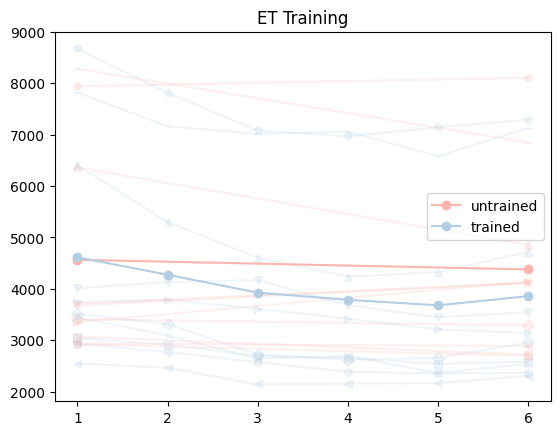

In [9]:
cmap = cm.Pastel1

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']

induction_blocks = subjs[subjs['BN'] <= num_pre_train_blocks+num_train_blocks+num_post_test_blocks]

induction_blocks = utils.remove_error_trials(induction_blocks)

induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'norm_MT': 'median'
}).reset_index()


for subnum, subj_data in induction_grouped.groupby('SubNum'):
    for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
        plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 6) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 6) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))        

induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'norm_MT': ['mean', 'std']
}).reset_index()
for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
    plt.plot(data['BN'], data['norm_MT']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))


plt.title('ET Training')

plt.legend()

plt.show()

TtestResult(statistic=0.07224081883666333, pvalue=0.9439902063918193, df=9)
TtestResult(statistic=3.508016826384159, pvalue=0.006639287589247557, df=9)


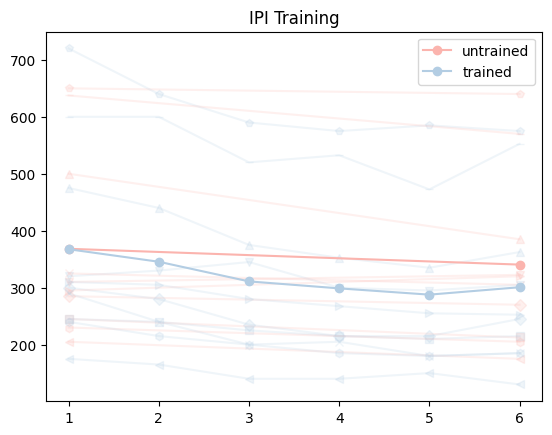

In [10]:

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']


induction_blocks = subjs_presses[subjs_presses['BN'] <= num_pre_train_blocks+num_train_blocks+num_post_test_blocks]

induction_blocks = utils.remove_error_trials_presses(induction_blocks)


induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'IPI_Value': 'median'
}).reset_index()


for subnum, subj_data in induction_grouped.groupby('SubNum'):
    for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
        plt.plot(data['BN'], data['IPI_Value'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)


        
print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['IPI_Value'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['IPI_Value']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 6) & (induction_grouped['is_trained_seq'] == False)]['IPI_Value'], 
                      induction_grouped[(induction_grouped['BN'] == 6) & (induction_grouped['is_trained_seq'] == True)]['IPI_Value']))    


induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'IPI_Value': ['mean', 'std']
}).reset_index()
for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
    plt.plot(data['BN'], data['IPI_Value']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))


plt.title('IPI Training')

plt.legend()

plt.show()




## Session 2: Pre test and Post test analysis

TtestResult(statistic=1.9347525370328633, pvalue=0.08502206072850228, df=9)
TtestResult(statistic=4.573376016538085, pvalue=0.0013404223026311033, df=9)


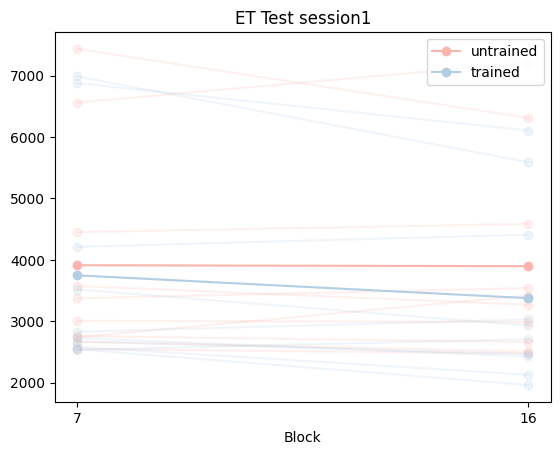

In [11]:
cmap = cm.Pastel1
session2_blocks = subjs[subjs['BN'].isin(test_session2_blocks_nums)]

sesssion2_blocks_pre_post = session2_blocks[session2_blocks['BN'].isin([7 , 16])]

sesssion2_blocks_pre_post = utils.remove_error_trials(sesssion2_blocks_pre_post)


session_grouped = sesssion2_blocks_pre_post.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'norm_MT': 'median'
}).reset_index()


for subnum, subj_data in session_grouped.groupby(['SubNum']):
    for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
        plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(session_grouped[(session_grouped['BN'] == 7) & (session_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      session_grouped[(session_grouped['BN'] == 7) & (session_grouped['is_trained_seq'] == True)]['norm_MT']))


print(stats.ttest_rel(session_grouped[(session_grouped['BN'] == 16) & (session_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      session_grouped[(session_grouped['BN'] == 16) & (session_grouped['is_trained_seq'] == True)]['norm_MT'])) 

session_grouped = session_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'norm_MT': 'mean'
}).reset_index()
for idx, (flag, data) in enumerate(session_grouped.groupby('is_trained_seq')):
    plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))
plt.xticks(data['BN'])


plt.title('ET Test session1')

plt.xlabel('Block')

plt.legend()

plt.show()

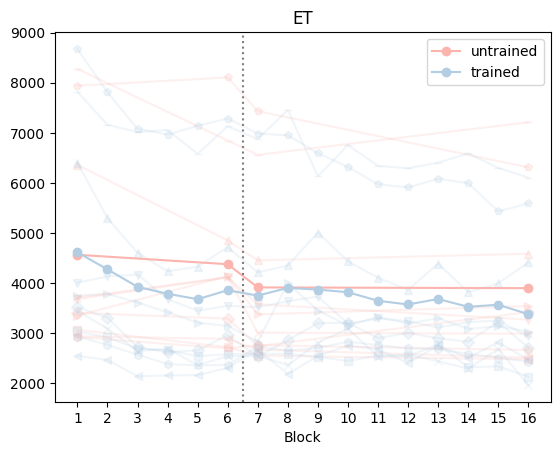

In [12]:
cmap = cm.Pastel1
session2_blocks = subjs[subjs['BN'].isin(range(1,17))]

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']


session2_blocks = utils.remove_error_trials(session2_blocks)

session_grouped = session2_blocks.groupby(['BN', 'SubNum', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'median'
}).reset_index()

for subnum, subj_data in session_grouped.groupby('SubNum'):
    for idx, ((flag_trained, flag_untrained), data) in enumerate(subj_data.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(1), alpha = 0.2)
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(0), alpha = 0.2)
            
        

session_grouped = session_grouped.groupby(['BN', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'mean'
}).reset_index()
for idx, ((flag_trained, flag_untrained), data) in enumerate(session_grouped.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(1), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(0), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))


plt.axvline(x=6.5, color='gray', linestyle='dotted')

plt.xticks(range(1,17))


plt.title('ET')

plt.xlabel('Block')

plt.legend()

plt.show()

## Session 2: Main Analysis

### IPI Analysis:


Text(0.5, 1.0, 'changed vs unchanged')

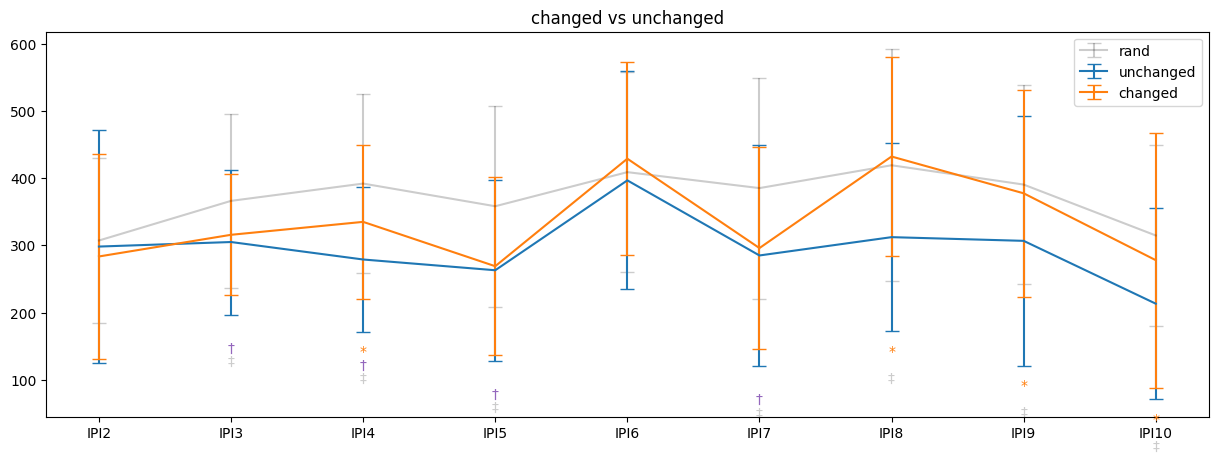

In [13]:
plt.figure(figsize=(15, 5))
cmap = cm.Pastel1
capsize = 5

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    if (flag_trained & flag_change):
        data['is_in_change_window'] = data.apply(utils.check_window_around_change_press, axis = 1)
        data = data[data['is_in_change_window']]
        label = 'changed'

    if (flag_trained & ~flag_change):
        data = data[data['IPI_Number'].isin(['IPI' + str(x) for x in [2,3,4,5,6,7,8,9,10]])]
        label = 'unchanged'

    if (flag_rand):
        data = data[data['IPI_Number'].isin(['IPI' + str(x) for x in [2,3,4,5,6,7,8,9,10]])]
        label = 'rand'


    data = data.groupby(['SubNum', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    finger_agg = data.groupby(['IPI_Number']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()

    finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
    plt.errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



#Statistical Signficance Tests
merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

for IPI in merged_df['IPI_Number'].unique():
    IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
    ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
    ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
    
    # Add significance symbols just above the error bars
    changed_mean = IPI_data['IPI_Value_changed'].mean()
    changed_std = IPI_data['IPI_Value_changed'].std()
    unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
    unchanged_std = IPI_data['IPI_Value_unchanged'].std()
    rand_mean = IPI_data['IPI_Value_rand'].mean()
    rand_std = IPI_data['IPI_Value_rand'].std()

    y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
    y_pos_unchanged = unchanged_mean - unchanged_std 
    y_pos_rand = rand_mean - rand_std

    y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

    if ttest_changed_vs_unchanged.pvalue < 0.05:
        plt.text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

    if ttest_changed_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

    if ttest_unchanged_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)




plt.legend()

plt.title(f'changed vs unchanged')

Text(0.5, 1.0, 'changed vs unchanged')

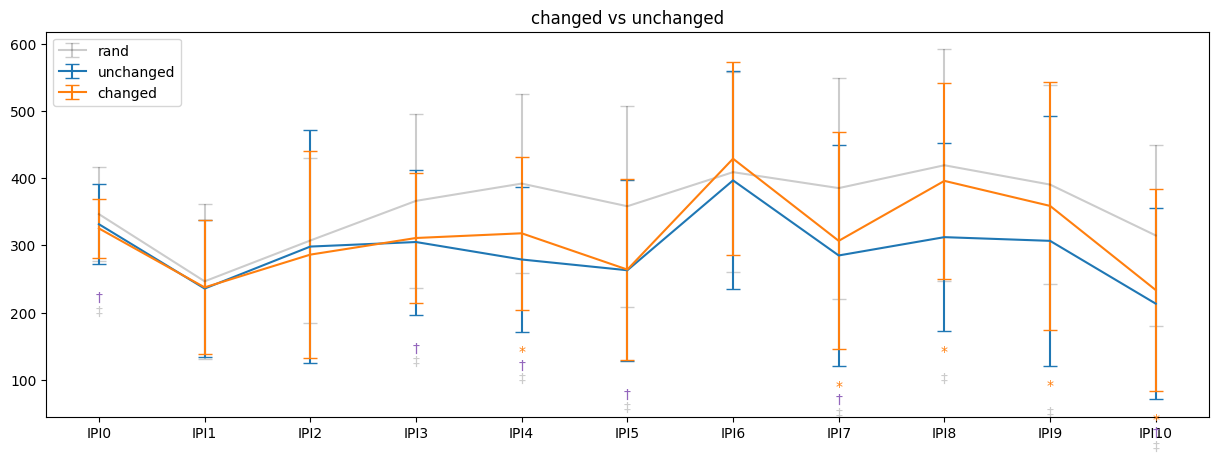

In [14]:
plt.figure(figsize=(15, 5))
cmap = cm.Pastel1
capsize = 5

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    if (flag_trained & flag_change):

        label = 'changed'

    if (flag_trained & ~flag_change):

        label = 'unchanged'

    if (flag_rand):

        label = 'rand'


    data = data.groupby(['SubNum', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    finger_agg = data.groupby(['IPI_Number']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()

    finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
    plt.errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



#Statistical Signficance Tests
merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

for IPI in merged_df['IPI_Number'].unique():
    IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
    ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
    ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
    
    # Add significance symbols just above the error bars
    changed_mean = IPI_data['IPI_Value_changed'].mean()
    changed_std = IPI_data['IPI_Value_changed'].std()
    unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
    unchanged_std = IPI_data['IPI_Value_unchanged'].std()
    rand_mean = IPI_data['IPI_Value_rand'].mean()
    rand_std = IPI_data['IPI_Value_rand'].std()

    y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
    y_pos_unchanged = unchanged_mean - unchanged_std 
    y_pos_rand = rand_mean - rand_std

    y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

    if ttest_changed_vs_unchanged.pvalue < 0.05:
        plt.text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

    if ttest_changed_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

    if ttest_unchanged_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)




plt.legend()

plt.title(f'changed vs unchanged')

IPI:  IPI0 TtestResult(statistic=-0.9382108083784176, pvalue=0.37262985714287844, df=9)
IPI:  IPI1 TtestResult(statistic=0.5460557005223248, pvalue=0.5983005555276759, df=9)
IPI:  IPI10 TtestResult(statistic=0.3071475584169756, pvalue=0.7657191878510456, df=9)
IPI:  IPI2 TtestResult(statistic=-1.1138250694977778, pvalue=0.29421500342195883, df=9)
IPI:  IPI3 TtestResult(statistic=-1.103923688023844, pvalue=0.29826557334216974, df=9)
IPI:  IPI4 TtestResult(statistic=0.6234446538249134, pvalue=0.5484645106688006, df=9)
IPI:  IPI5 TtestResult(statistic=-0.9780675089485068, pvalue=0.35359758396894503, df=9)
IPI:  IPI6 TtestResult(statistic=1.2925888601730253, pvalue=0.22835017347346792, df=9)
IPI:  IPI7 TtestResult(statistic=-0.27550386091551227, pvalue=0.7891500954182263, df=9)
IPI:  IPI8 TtestResult(statistic=2.89068174686032, pvalue=0.017864420831136145, df=9)
IPI:  IPI9 TtestResult(statistic=3.5672387877878773, pvalue=0.006050328817145206, df=9)


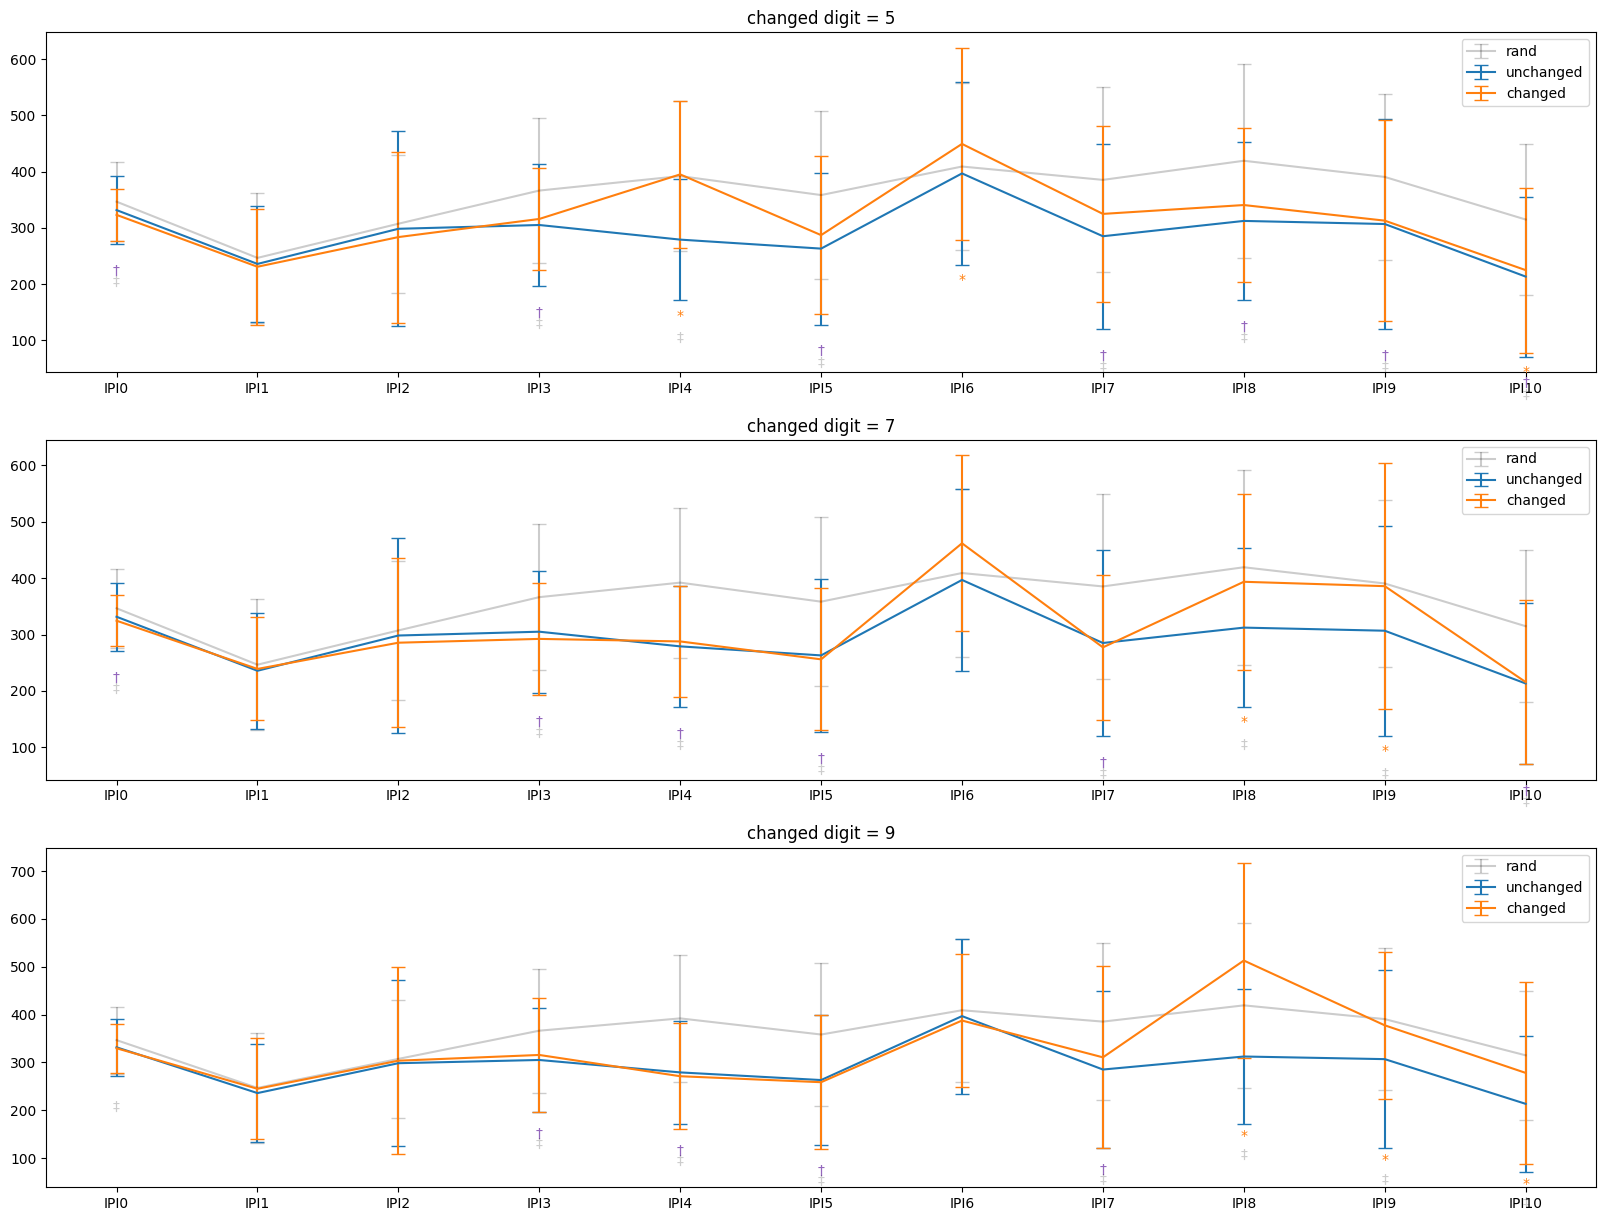

In [15]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)

finger_aggs = {}

for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 6):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)



    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')

IPI:  IPI0 TtestResult(statistic=-0.466002335770648, pvalue=0.6522860613181687, df=9)
IPI:  IPI1 TtestResult(statistic=0.20507577810739896, pvalue=0.8420760433785544, df=9)
IPI:  IPI10 TtestResult(statistic=4.129483209670112, pvalue=0.0025614603121131654, df=9)
IPI:  IPI2 TtestResult(statistic=-1.315466713716892, pvalue=0.22087676660028663, df=9)
IPI:  IPI3 TtestResult(statistic=2.207350958677468, pvalue=0.05468103282636013, df=9)
IPI:  IPI4 TtestResult(statistic=3.127090659991963, pvalue=0.012178655323341737, df=9)
IPI:  IPI5 TtestResult(statistic=1.917336169102632, pvalue=0.08742871841293258, df=9)
IPI:  IPI6 TtestResult(statistic=3.0747635321157967, pvalue=0.013251596802366632, df=9)
IPI:  IPI7 TtestResult(statistic=3.3684888967224076, pvalue=0.00827681608007578, df=9)
IPI:  IPI8 TtestResult(statistic=2.589247891896881, pvalue=0.029249535104015737, df=9)
IPI:  IPI9 TtestResult(statistic=2.558199529721406, pvalue=0.03077790703186351, df=9)


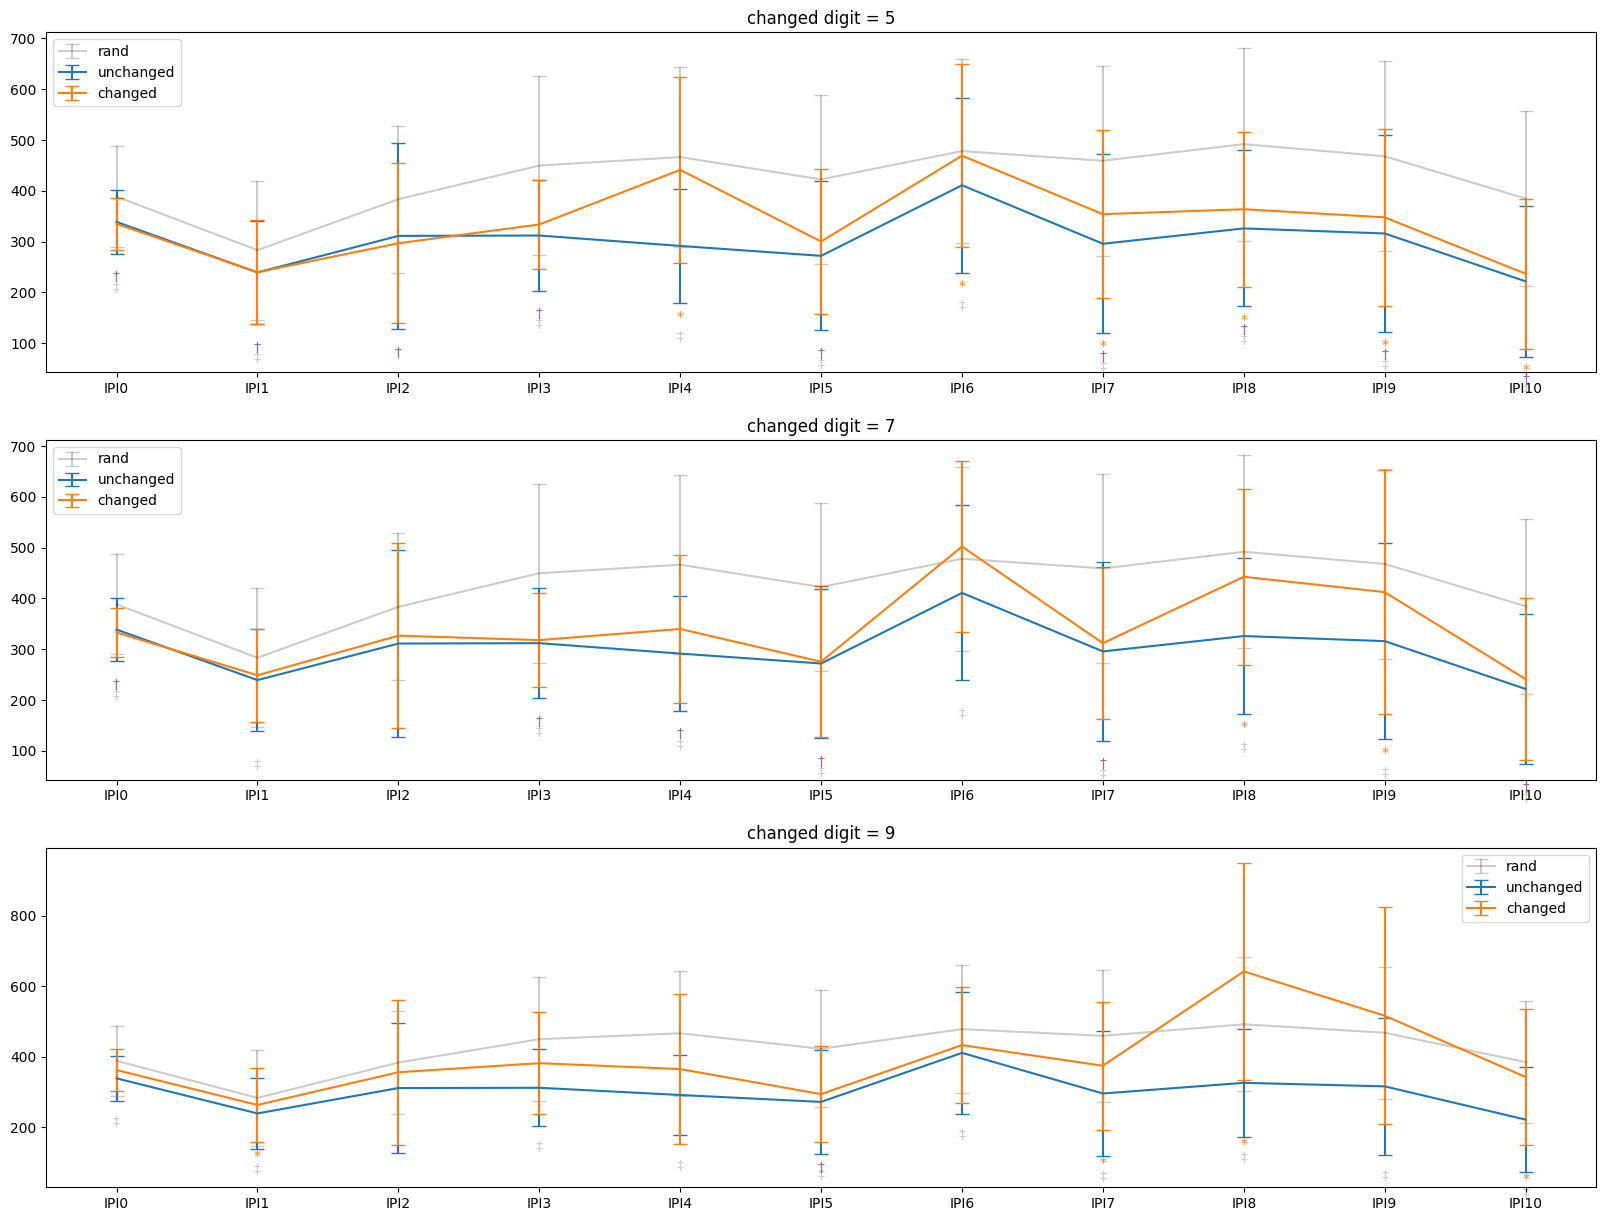

In [16]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))].copy()

session2_blocks['IPI_Value'] = session2_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# session2_blocks = utils.remove_error_trials_presses(session2_blocks)

finger_aggs = {}


for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')

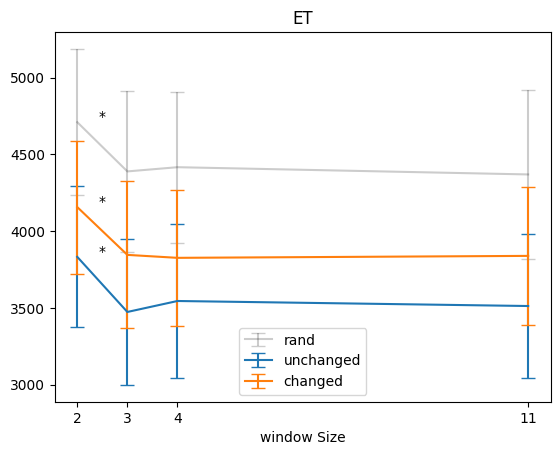

In [17]:
test_blocks = subjs[subjs['BN'].isin(list(range(8,16)))]

test_blocks = utils.remove_error_trials(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 50)
    }).reset_index()
        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')





plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
plt.show()


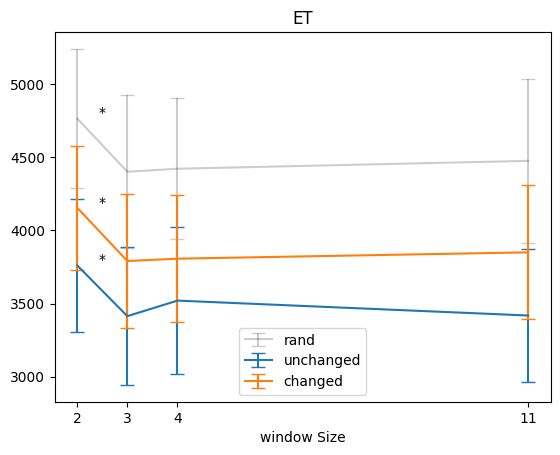

In [18]:
test_blocks = subjs[subjs['BN'].isin(list(range(8,16)))].copy()

test_blocks['norm_MT'] = test_blocks.apply(utils.correct_error_trial, axis = 1)

# test_blocks = utils.remove_error_trials(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 40)
    }).reset_index()
        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')





plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
plt.show()


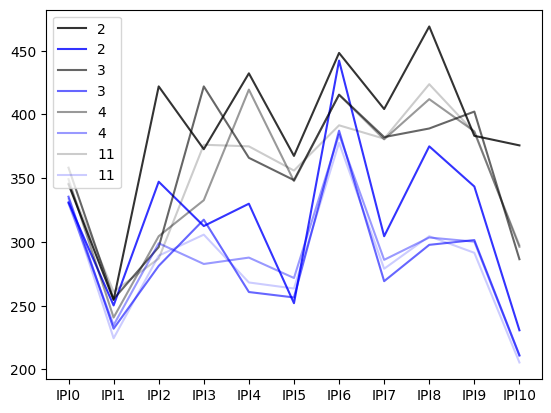

In [19]:
# fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)



for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & ~flag_change):

            finger_agg_unchnaged = data.groupby(['SubNum', 'IPI_Number']).agg({
                'IPI_Value': 'median'
            }).reset_index()


            finger_agg_unchnaged = finger_agg_unchnaged.groupby(['IPI_Number']).agg({
                'IPI_Value': ['mean', 'sem']
            }).reset_index()

            finger_agg_unchnaged = finger_agg_unchnaged.iloc[index_natsorted(finger_agg_unchnaged['IPI_Number'])].reset_index(drop=True)
            # plt.errorbar(finger_agg_unchnaged['IPI_Number'], finger_agg_unchnaged['IPI_Value']['mean'], yerr = finger_agg_unchnaged['IPI_Value']['sem'], label = window, capsize = capsize,alpha = (len(windowSizes) - idx)/(len(windowSizes)+1), color = 'blue')
            plt.errorbar(finger_agg_unchnaged['IPI_Number'], finger_agg_unchnaged['IPI_Value']['mean'], label = window, alpha = (len(windowSizes) - idx)/(len(windowSizes)+1), color = 'blue')



        if (flag_rand):

            finger_agg_rand = data.groupby(['SubNum', 'IPI_Number']).agg({
                'IPI_Value': 'median'
            }).reset_index()

            finger_agg_rand = finger_agg_rand.groupby(['IPI_Number']).agg({
                'IPI_Value': ['mean', 'std']
            }).reset_index()

            finger_agg_rand = finger_agg_rand.iloc[index_natsorted(finger_agg_rand['IPI_Number'])].reset_index(drop=True)
            # plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['std'], color = 'black', label = window, capsize = capsize, alpha = 0.2)
            plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], label = window, capsize = capsize, alpha = (len(windowSizes) - idx)/(len(windowSizes)+1), color = 'black')

    
    plt.legend()

    # axs[idx].set_title(f'window = {window}')


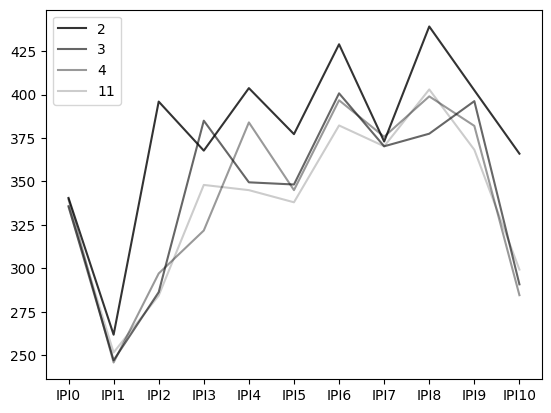

In [20]:
# fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5


session2_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)



for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        # if (flag_trained & ~flag_change):

        #     finger_agg_unchnaged = data.groupby(['SubNum', 'IPI_Number']).agg({
        #         'IPI_Value': 'median'
        #     }).reset_index()


        #     finger_agg_unchnaged = finger_agg_unchnaged.groupby(['IPI_Number']).agg({
        #         'IPI_Value': ['mean', 'std']
        #     }).reset_index()

        #     finger_agg_unchnaged = finger_agg_unchnaged.iloc[index_natsorted(finger_agg_unchnaged['IPI_Number'])].reset_index(drop=True)
        #     # plt.errorbar(finger_agg_unchnaged['IPI_Number'], finger_agg_unchnaged['IPI_Value']['mean'], yerr = finger_agg_unchnaged['IPI_Value']['std'], label = window, capsize = capsize)
        #     plt.errorbar(finger_agg_unchnaged['IPI_Number'], finger_agg_unchnaged['IPI_Value']['mean'], label = window)



        if (flag_rand):

            finger_agg_rand = data.groupby(['SubNum', 'IPI_Number']).agg({
                'IPI_Value': 'median'
            }).reset_index()


            finger_agg_rand = finger_agg_rand.groupby(['IPI_Number']).agg({
                'IPI_Value': ['mean', 'sem']
            }).reset_index()

            finger_agg_rand = finger_agg_rand.iloc[index_natsorted(finger_agg_rand['IPI_Number'])].reset_index(drop=True)
            # plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['sem'], color = 'black', label = window, capsize = capsize, alpha = 0.2)
            plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], label = window, capsize = capsize, alpha = (len(windowSizes) - idx)/(len(windowSizes)+1), color='black')

    
    plt.legend()

    # axs[idx].set_title(f'window = {window}')


In [21]:
cmap = cm.Pastel1
capsize = 5


test_blocks = subjs[subjs['BN'].isin(list(range(8,16)))].copy()

# session2_blocks = session2_blocks[session2_blocks['SubNum'] != 8]

test_blocks['norm_MT'] = test_blocks.apply(utils.correct_error_trial, axis = 1)




for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            for (digit, changed_data) in data.groupby('digitChangePos'):
                for (subnum, sub_data) in changed_data.groupby('SubNum'):
                    if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                         print(f"subj{subnum}_window{window}_changed{digit+1}_acc {len(sub_data[sub_data['isError'] == 0]) / len(sub_data)}")
                        #  if (subnum == 9 and window == 11):
                        #      print(sub_data['norm_MT'])
                        #      print(np.percentile(sub_data['norm_MT'], 0))
    

        if (flag_trained & ~flag_change):

            for (subnum, sub_data) in data.groupby('SubNum'):
                 if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                    print(f"subj{subnum}_window{window}_unchanged_acc {len(sub_data[sub_data['isError'] == 0]) / len(sub_data)}")

        if (flag_rand):
            for (subnum, sub_data) in data.groupby('SubNum'):
                 if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                    print(f"subj{subnum}_window{window}_rand_acc {round(len(sub_data[sub_data['isError'] == 0]) / len(sub_data), 2)}")



subj4_window2_rand_acc 0.58
subj8_window2_changed7_acc 0.5
subj2_window2_changed9_acc 0.5
subj3_window2_changed9_acc 0.5
subj6_window2_changed9_acc 0.5
subj9_window2_changed9_acc 0.5
subj5_window3_changed5_acc 0.5
subj9_window3_changed7_acc 0.5
subj4_window3_changed9_acc 0.5
subj2_window4_rand_acc 0.58
subj4_window4_rand_acc 0.54
subj6_window4_rand_acc 0.58
subj2_window4_changed5_acc 0.5
subj10_window4_changed7_acc 0.5
subj3_window4_changed9_acc 0.25
subj4_window4_changed9_acc 0.5
subj2_window11_rand_acc 0.5
subj6_window11_rand_acc 0.46
subj3_window11_changed7_acc 0.5
subj3_window11_changed9_acc 0.5
subj4_window11_changed9_acc 0.5
subj7_window11_changed9_acc 0.5
subj9_window11_changed9_acc 0.25


IPI:  IPI0 TtestResult(statistic=0.5825142445888235, pvalue=0.5745219378434523, df=9)
IPI:  IPI1 TtestResult(statistic=0.4466063805620691, pvalue=0.6657119235315339, df=9)
IPI:  IPI10 TtestResult(statistic=1.1227496970154056, pvalue=0.2906011983853332, df=9)
IPI:  IPI2 TtestResult(statistic=-1.1076924441000822, pvalue=0.29671868231564413, df=9)
IPI:  IPI3 TtestResult(statistic=1.3466079929344437, pvalue=0.2110354686786714, df=9)
IPI:  IPI4 TtestResult(statistic=1.7842019405859857, pvalue=0.10805665597818373, df=9)
IPI:  IPI5 TtestResult(statistic=0.5170578091771423, pvalue=0.6175816758086823, df=9)
IPI:  IPI6 TtestResult(statistic=2.739248075540826, pvalue=0.022875702311658162, df=9)
IPI:  IPI7 TtestResult(statistic=3.2915021185782503, pvalue=0.009355892351768506, df=9)
IPI:  IPI8 TtestResult(statistic=1.1167685282552322, pvalue=0.2930192338974477, df=9)
IPI:  IPI9 TtestResult(statistic=0.2525571382052937, pvalue=0.8062840244379883, df=9)


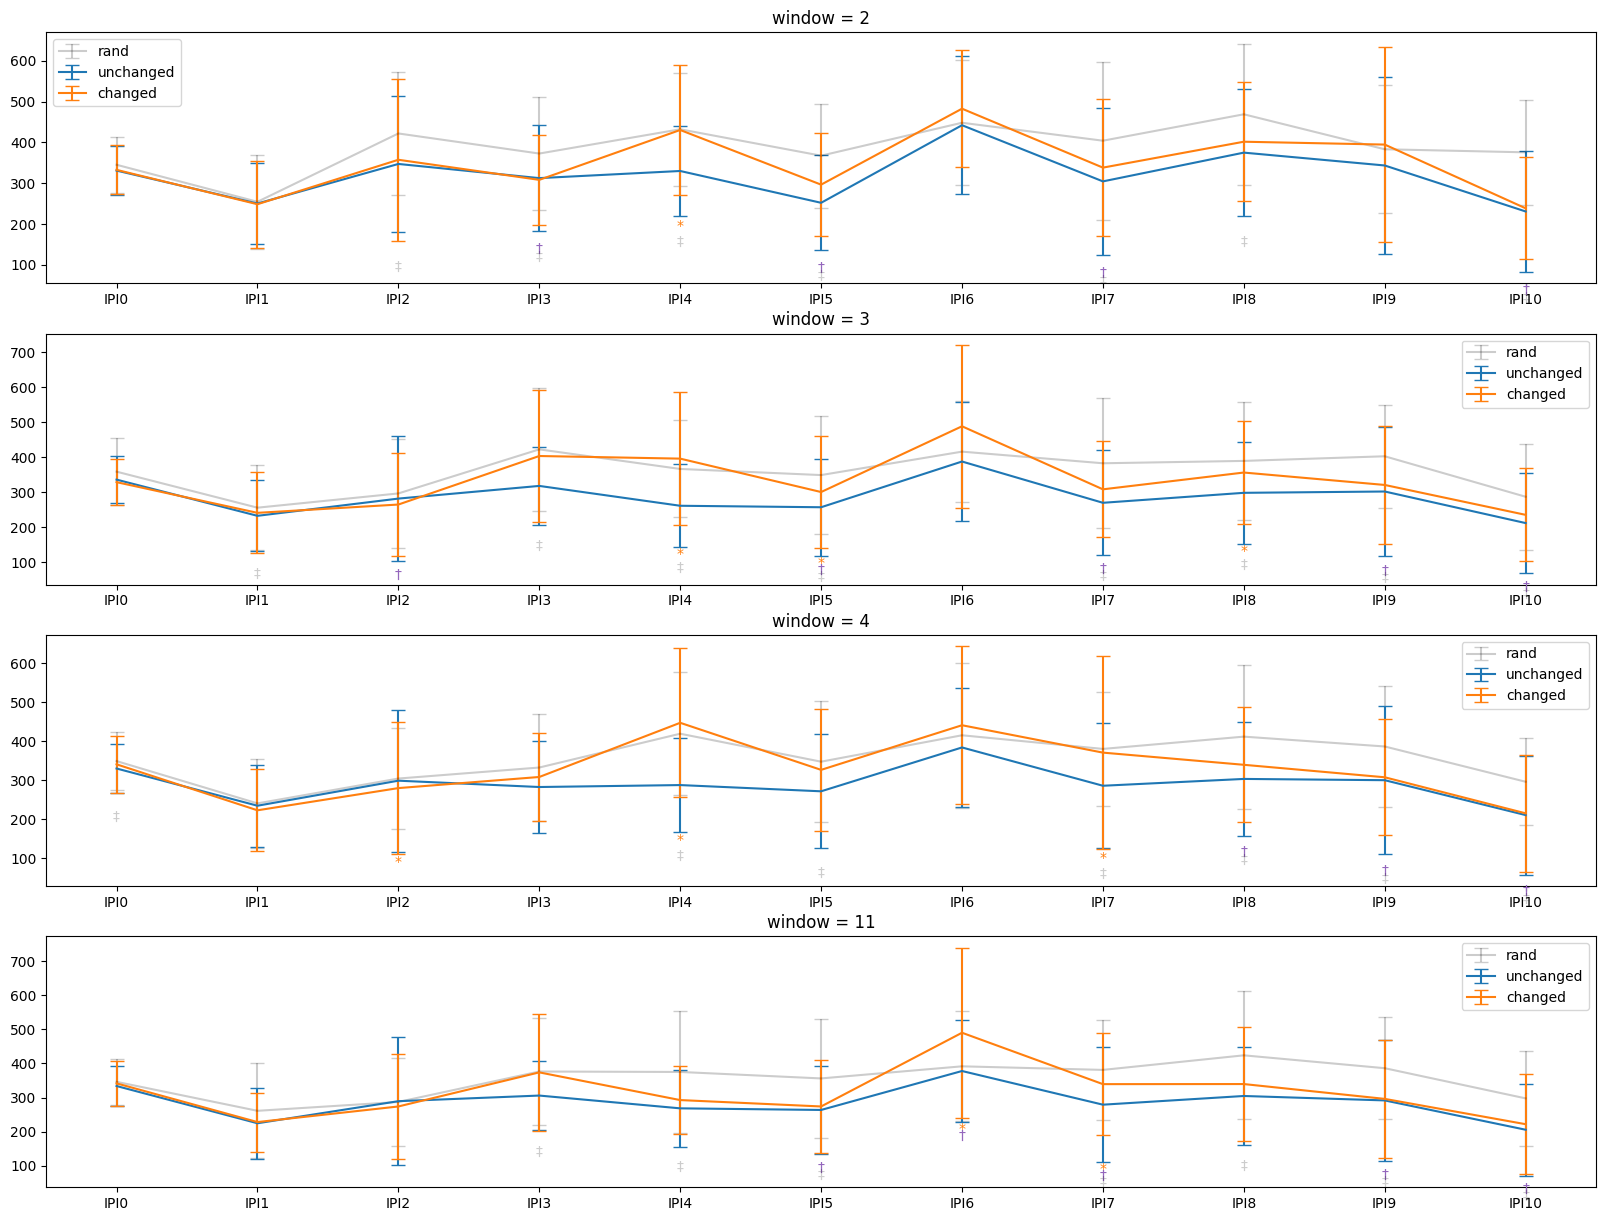

In [22]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 4]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=1.8675343983616577, pvalue=0.09466998859366277, df=9)
IPI:  IPI1 TtestResult(statistic=1.4938505238318491, pvalue=0.16942090698417317, df=9)
IPI:  IPI10 TtestResult(statistic=1.660519961499972, pvalue=0.13117919379223084, df=9)
IPI:  IPI2 TtestResult(statistic=0.8168395660523434, pvalue=0.4351082978993791, df=9)
IPI:  IPI3 TtestResult(statistic=1.2693995520892052, pvalue=0.23613963937308396, df=9)
IPI:  IPI4 TtestResult(statistic=2.7591289028742336, pvalue=0.02214368248327706, df=9)
IPI:  IPI5 TtestResult(statistic=0.9250101493202272, pvalue=0.3790951150632016, df=9)
IPI:  IPI6 TtestResult(statistic=2.8682113323127147, pvalue=0.018530647972142447, df=9)
IPI:  IPI7 TtestResult(statistic=3.493970435308754, pvalue=0.006787601753640592, df=9)
IPI:  IPI8 TtestResult(statistic=1.211058608292458, pvalue=0.25671299230311156, df=9)
IPI:  IPI9 TtestResult(statistic=0.8338141622312165, pvalue=0.4259613970678151, df=9)


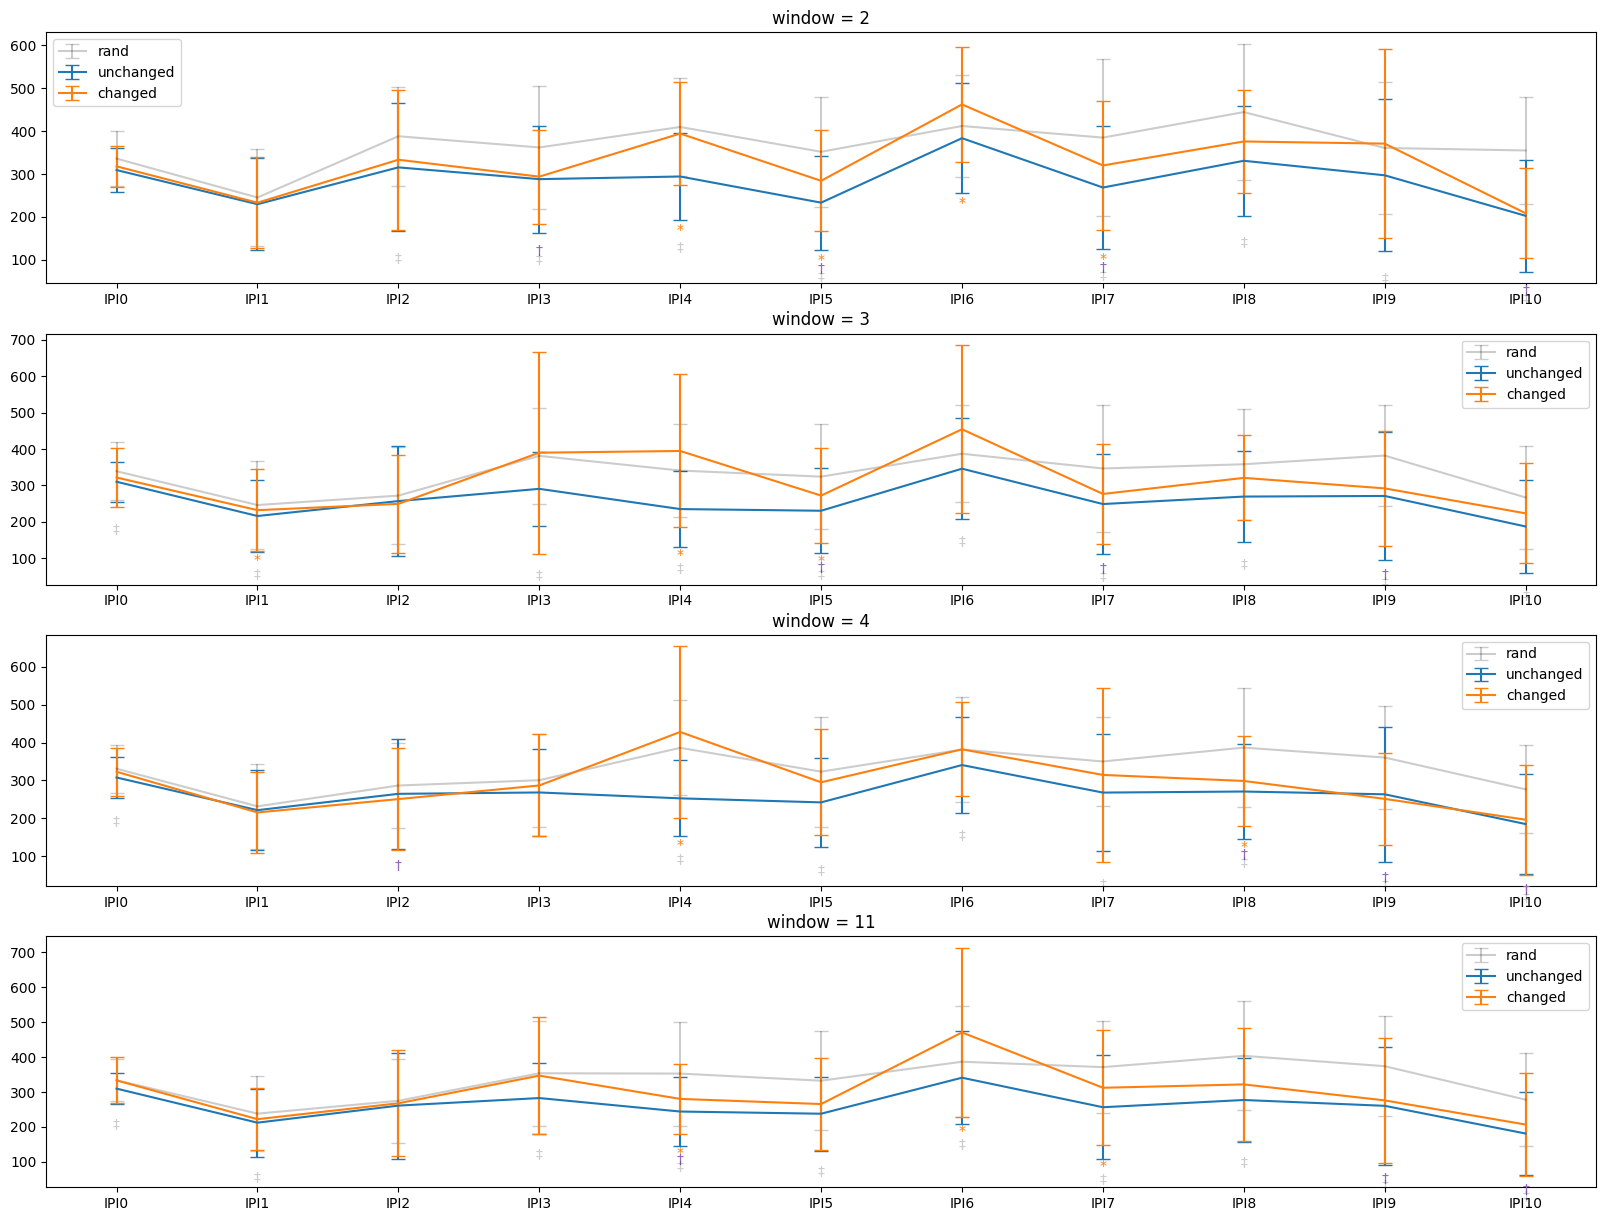

In [23]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))].copy()

# session2_blocks = session2_blocks[session2_blocks['SubNum'] != 2]

session2_blocks['IPI_Value'] = session2_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 4]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=-0.2664678000520716, pvalue=0.7958834697338083, df=9)
IPI:  IPI1 TtestResult(statistic=0.8393958730398579, pvalue=0.42298258895054797, df=9)
IPI:  IPI10 TtestResult(statistic=0.13889782036305579, pvalue=0.892589230736957, df=9)
IPI:  IPI2 TtestResult(statistic=-0.17305414365710536, pvalue=0.866438288669295, df=9)
IPI:  IPI3 TtestResult(statistic=0.45337524449451005, pvalue=0.6610118864732828, df=9)
IPI:  IPI4 TtestResult(statistic=1.1641728789346957, pvalue=0.2742855242220778, df=9)
IPI:  IPI5 TtestResult(statistic=1.5602094816335776, pvalue=0.15314228160693874, df=9)
IPI:  IPI6 TtestResult(statistic=-0.4235116382794013, pvalue=0.6818633912769312, df=9)
IPI:  IPI7 TtestResult(statistic=1.944242426569767, pvalue=0.08373723711960056, df=9)
IPI:  IPI8 TtestResult(statistic=1.8337052291971283, pvalue=0.09990595922350623, df=9)
IPI:  IPI9 TtestResult(statistic=2.3541222055522537, pvalue=0.04301361717908178, df=9)


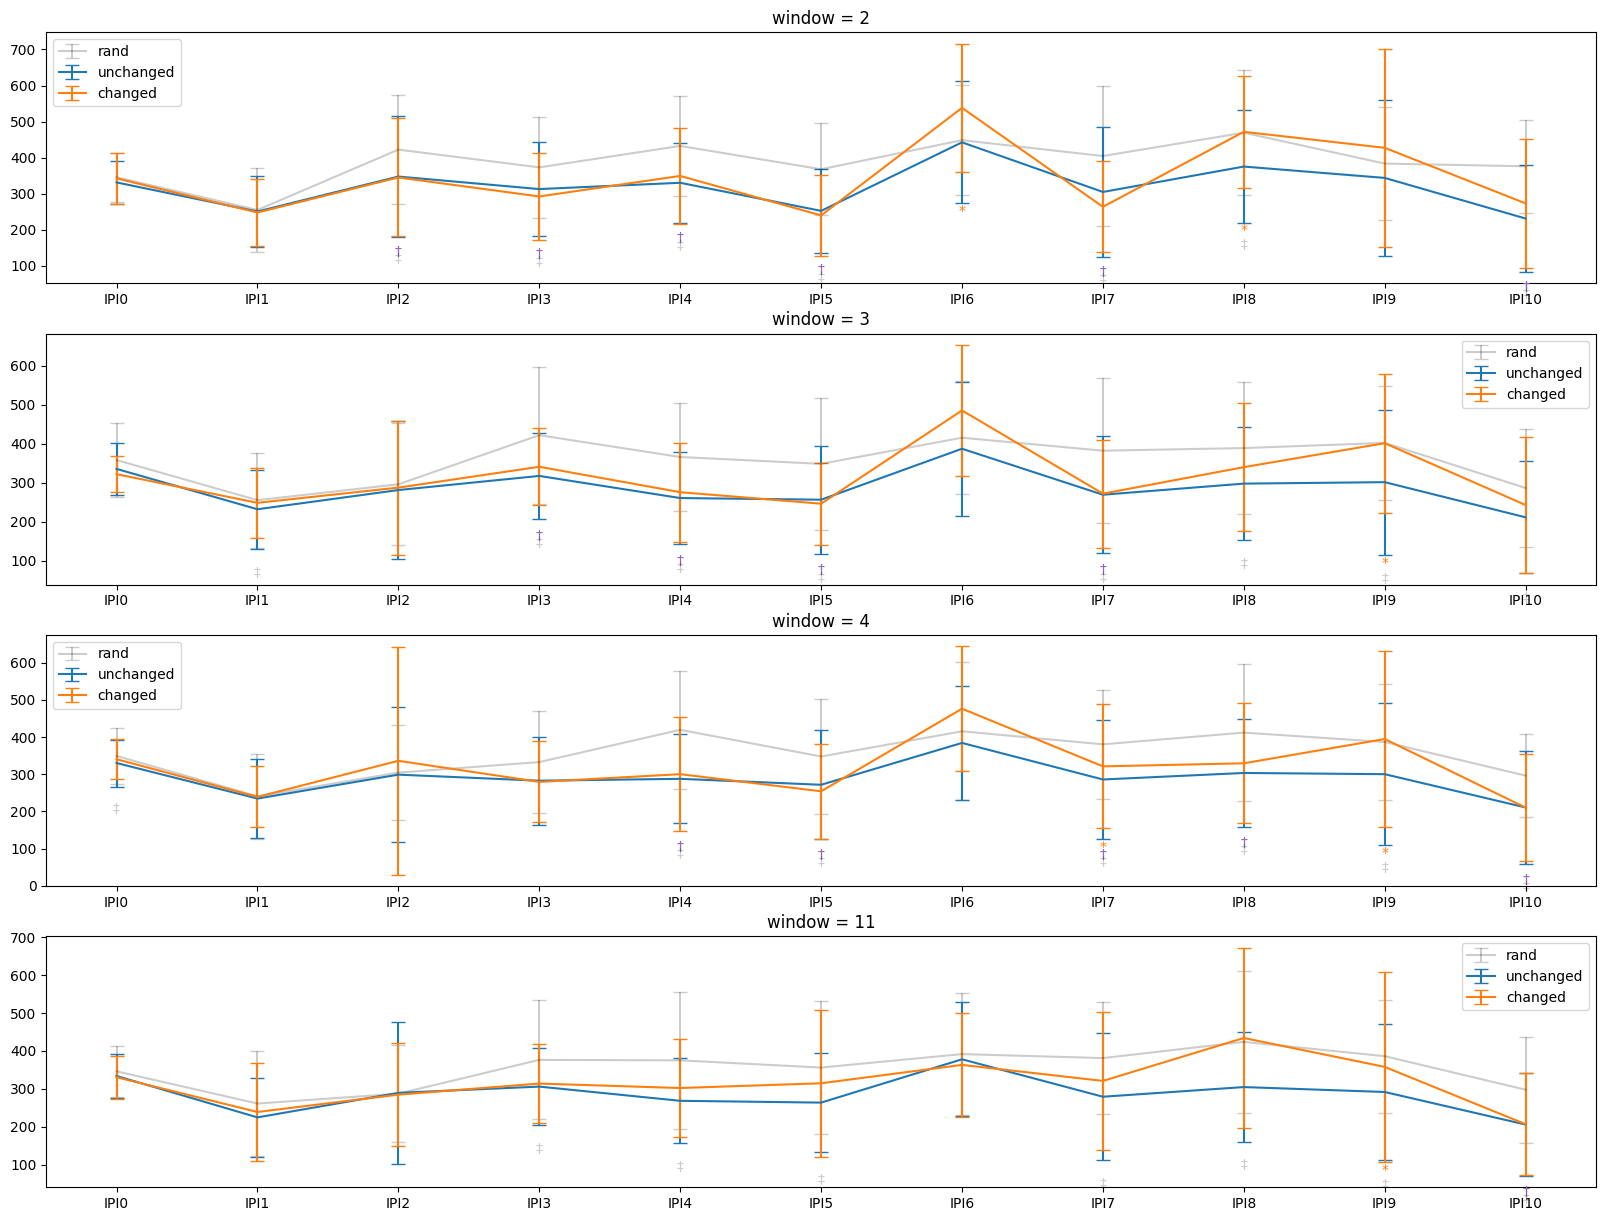

In [24]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 6]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=1.5084089518206647, pvalue=0.16572419462595467, df=9)
IPI:  IPI1 TtestResult(statistic=1.1272520932406718, pvalue=0.288791401569353, df=9)
IPI:  IPI10 TtestResult(statistic=2.6217441231166747, pvalue=0.027731515886816292, df=9)
IPI:  IPI2 TtestResult(statistic=0.9374095906261459, pvalue=0.3730199713089939, df=9)
IPI:  IPI3 TtestResult(statistic=1.0496710053659586, pvalue=0.3212373109913374, df=9)
IPI:  IPI4 TtestResult(statistic=2.1424315132017604, pvalue=0.0607804099369367, df=9)
IPI:  IPI5 TtestResult(statistic=1.5621784954939646, pvalue=0.1526812405713664, df=9)
IPI:  IPI6 TtestResult(statistic=0.7165338716523945, pvalue=0.4918355748615888, df=9)
IPI:  IPI7 TtestResult(statistic=2.8040093853583015, pvalue=0.02057741715465621, df=9)
IPI:  IPI8 TtestResult(statistic=1.8078994751169395, pvalue=0.10408063739905851, df=9)
IPI:  IPI9 TtestResult(statistic=2.3515677726393784, pvalue=0.04319400265028748, df=9)


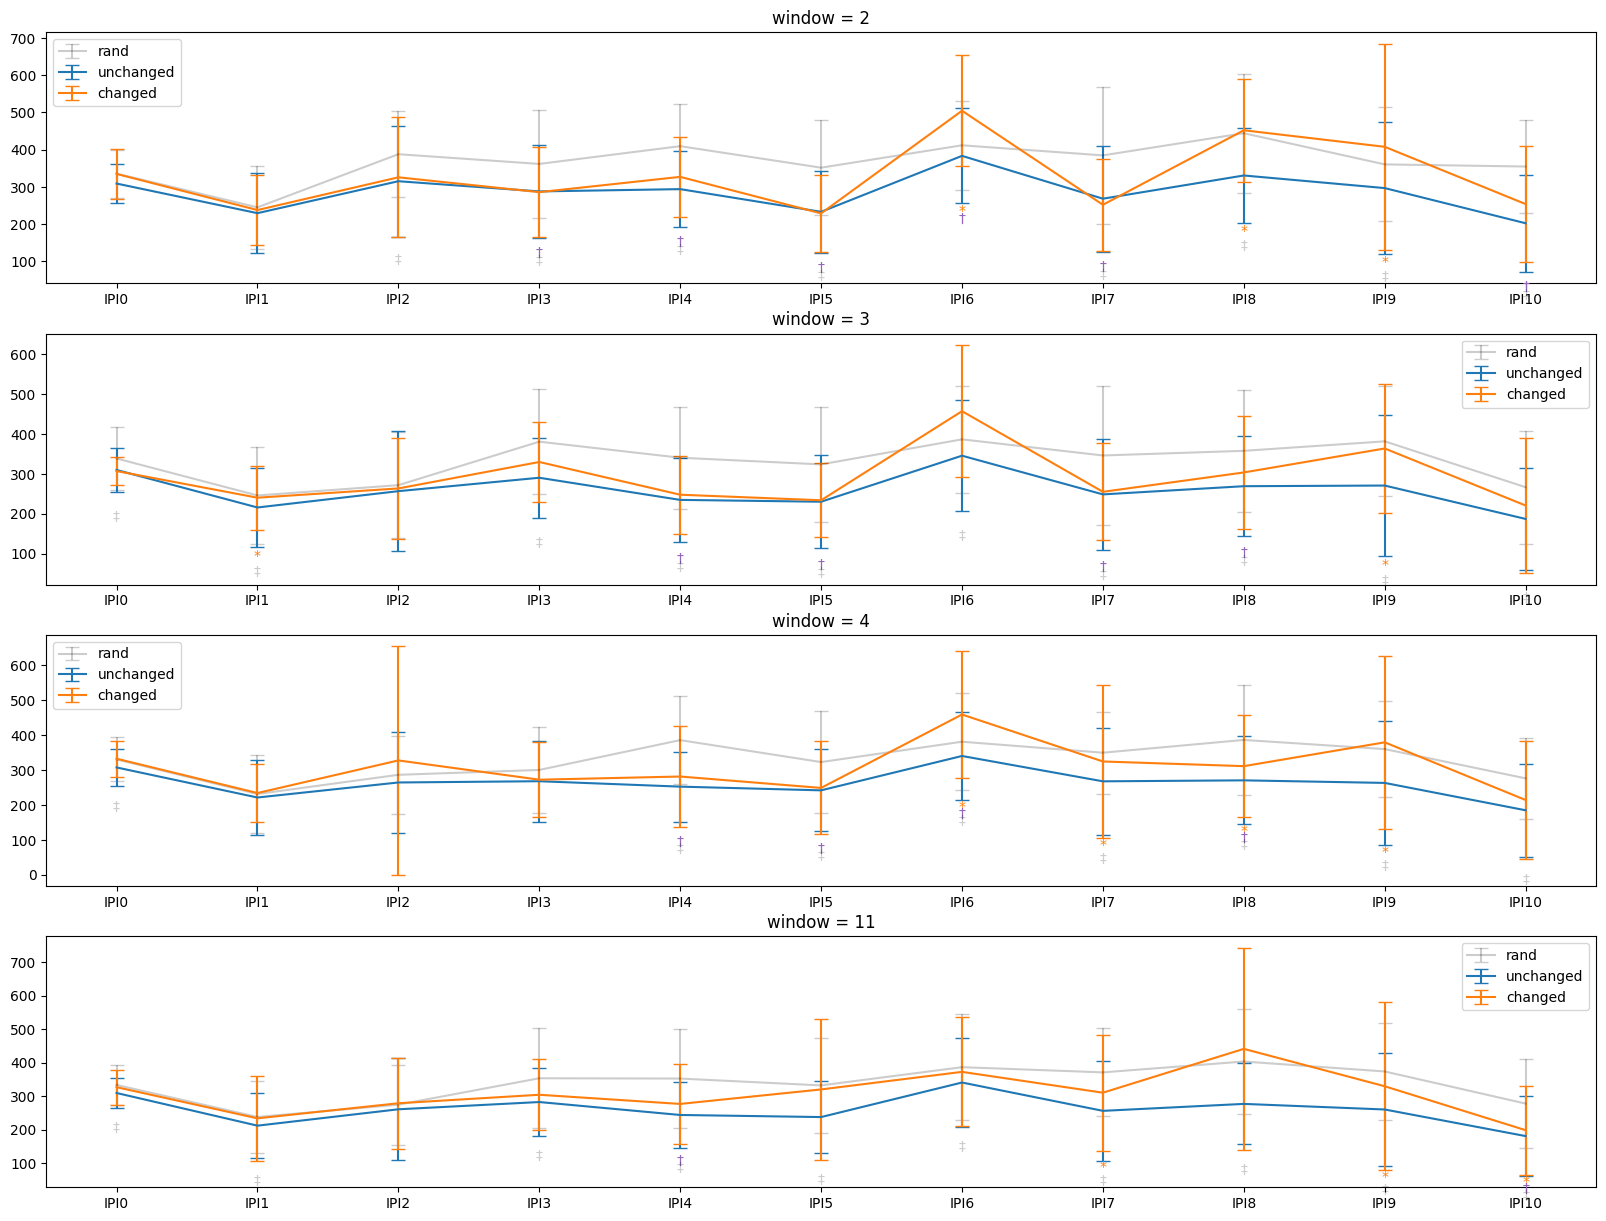

In [25]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))].copy()

# session2_blocks = session2_blocks[session2_blocks['SubNum'] != 2]

session2_blocks['IPI_Value'] = session2_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 6]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=0.819931725671605, pvalue=0.4334322059227196, df=9)
IPI:  IPI1 TtestResult(statistic=1.928949988086032, pvalue=0.0858168313405067, df=9)
IPI:  IPI10 TtestResult(statistic=1.8806862617653208, pvalue=0.0927047167636944, df=9)
IPI:  IPI2 TtestResult(statistic=1.1372826035282604, pvalue=0.2847915575892993, df=9)
IPI:  IPI3 TtestResult(statistic=0.8263209655930053, pvalue=0.42998284834822664, df=9)
IPI:  IPI4 TtestResult(statistic=0.8875864128700164, pvalue=0.3978622839246233, df=9)
IPI:  IPI5 TtestResult(statistic=0.7080741468749018, pvalue=0.49682632131979054, df=9)
IPI:  IPI6 TtestResult(statistic=0.7777335207671737, pvalue=0.4566828905148689, df=9)
IPI:  IPI7 TtestResult(statistic=1.3535404092920207, pvalue=0.20889592760297795, df=9)
IPI:  IPI8 TtestResult(statistic=2.904769506508425, pvalue=0.017459270134795302, df=9)
IPI:  IPI9 TtestResult(statistic=1.5532718622551784, pvalue=0.15477661319531885, df=9)


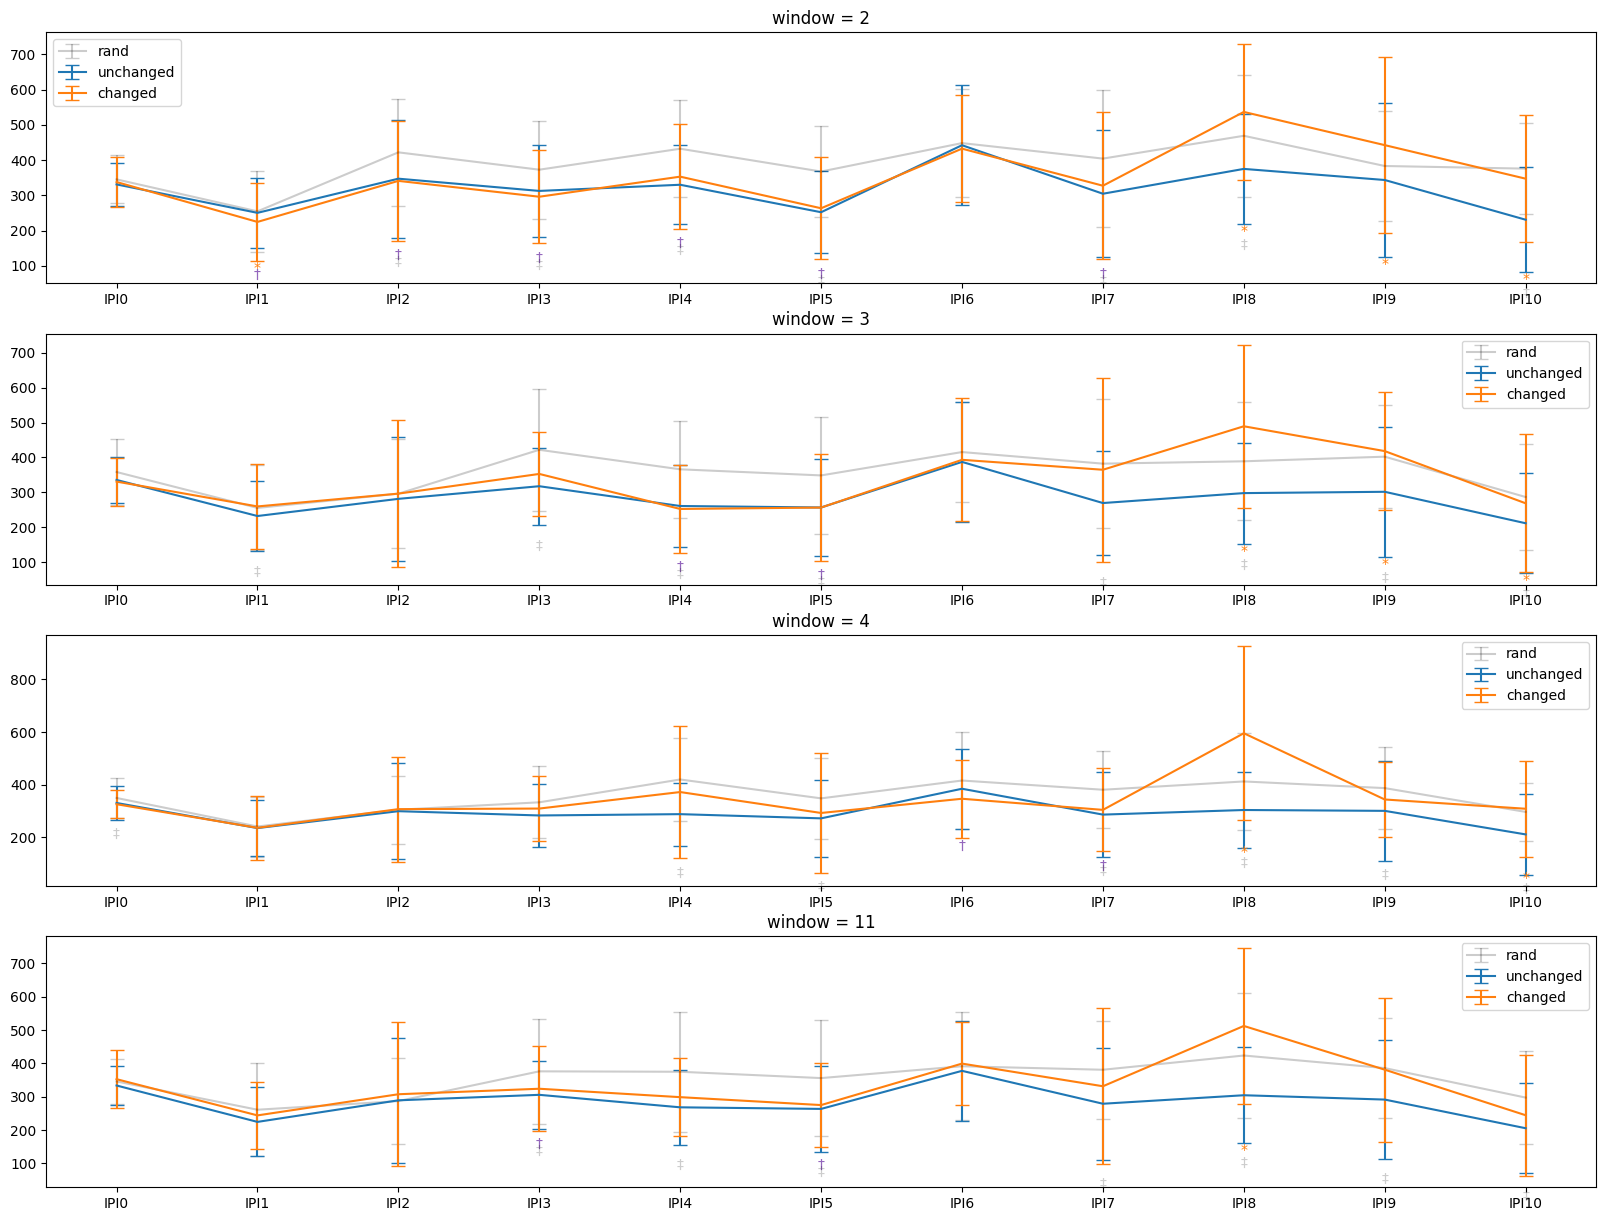

In [26]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))]

session2_blocks = utils.remove_error_trials_presses(session2_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 8]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


/Users/amin/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
/Users/amin/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


IPI:  IPI0 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI1 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI10 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI2 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI3 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI4 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI5 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI6 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI7 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI8 TtestResult(statistic=nan, pvalue=nan, df=nan)
IPI:  IPI9 TtestResult(statistic=nan, pvalue=nan, df=nan)


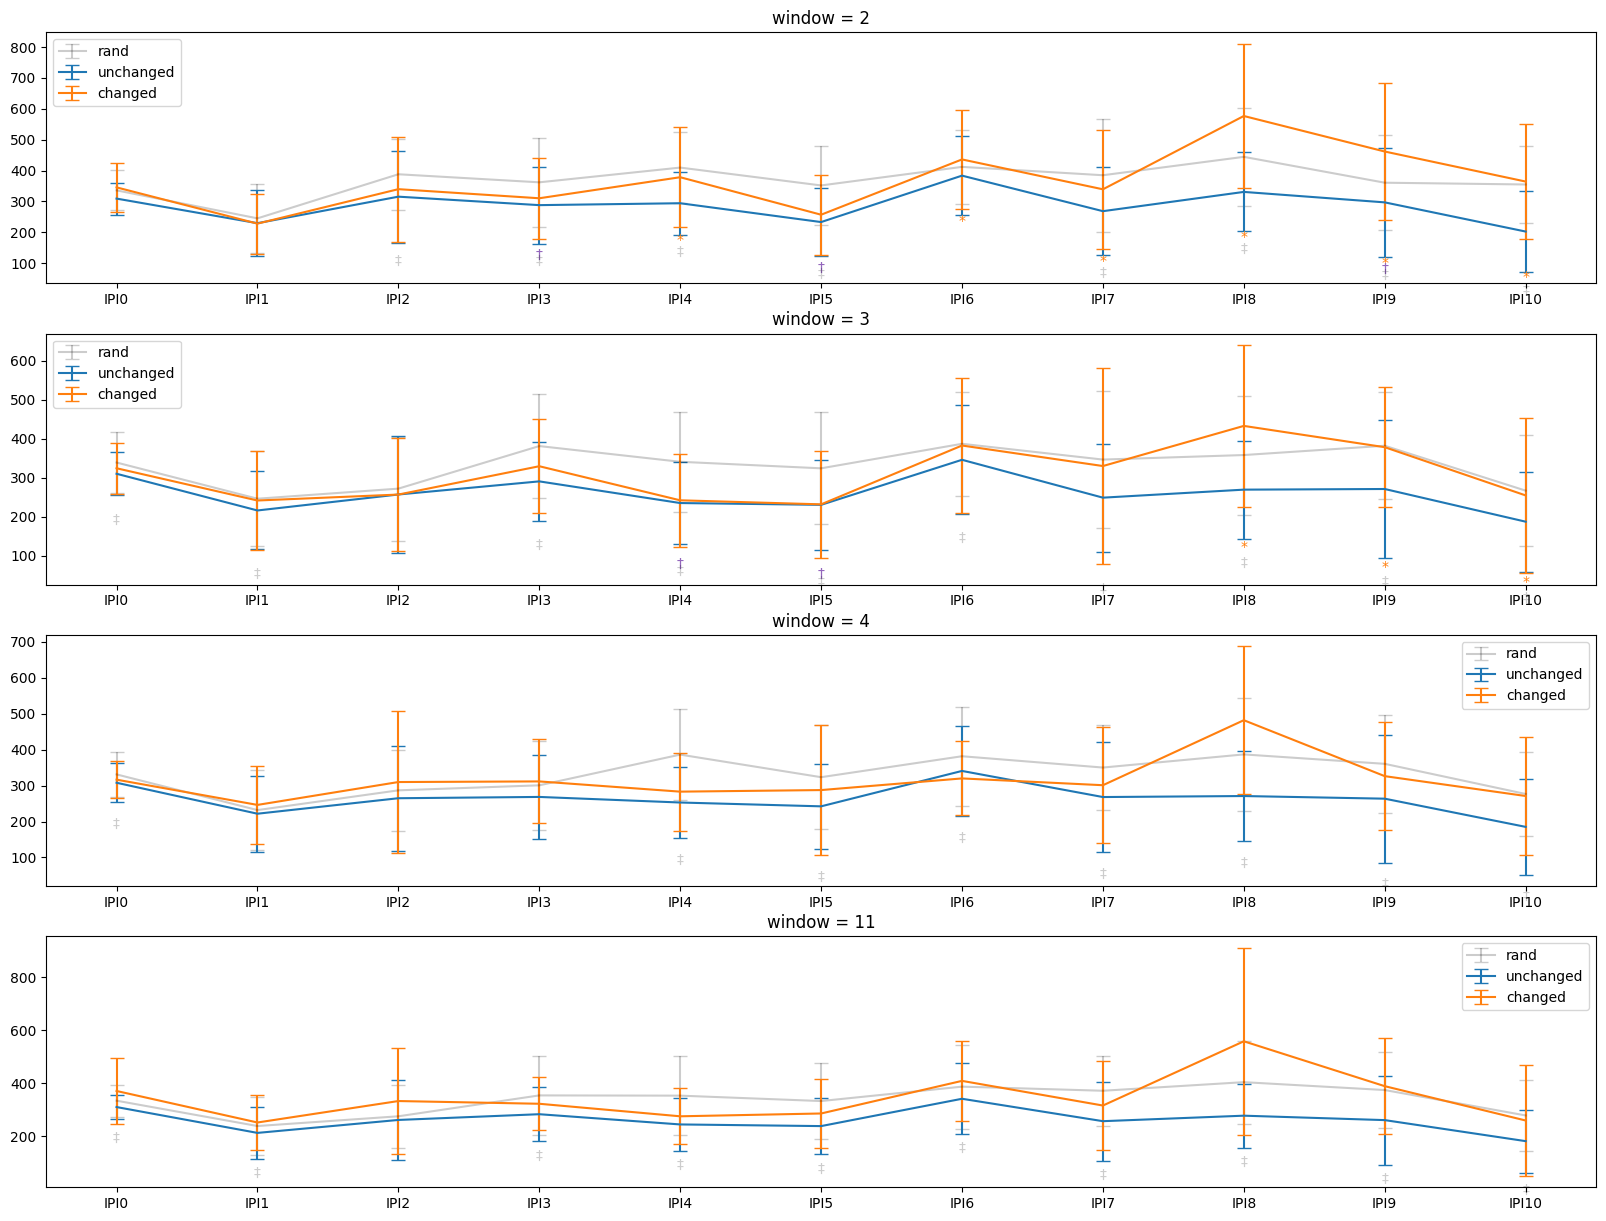

In [27]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session2_blocks = subjs_presses[subjs_presses['BN'].isin(range(8,16))].copy()

# session2_blocks = session2_blocks[session2_blocks['SubNum'] != 2]

session2_blocks['IPI_Value'] = session2_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session2_blocks[session2_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 8]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x : np.percentile(x, 30)
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()


        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


## Session 3: Pre test and Post test analysis

TtestResult(statistic=3.0182865157755865, pvalue=0.014519566054197696, df=9)
TtestResult(statistic=5.158729203905339, pvalue=0.0005961075900210592, df=9)


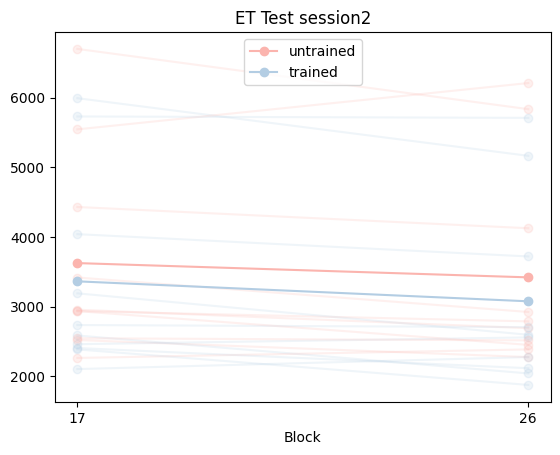

In [28]:
cmap = cm.Pastel1
session3_blocks = subjs[subjs['BN'].isin(test_session3_blocks_nums)]

sesssion3_blocks_pre_post = session3_blocks[session3_blocks['BN'].isin([17 , 26])]

sesssion3_blocks_pre_post = utils.remove_error_trials(sesssion3_blocks_pre_post)


session_grouped = sesssion3_blocks_pre_post.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'norm_MT': 'median'
}).reset_index()


for subnum, subj_data in session_grouped.groupby(['SubNum']):
    for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
        plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(session_grouped[(session_grouped['BN'] == 17) & (session_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      session_grouped[(session_grouped['BN'] == 17) & (session_grouped['is_trained_seq'] == True)]['norm_MT']))


print(stats.ttest_rel(session_grouped[(session_grouped['BN'] == 26) & (session_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      session_grouped[(session_grouped['BN'] == 26) & (session_grouped['is_trained_seq'] == True)]['norm_MT'])) 


session_grouped = session_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'norm_MT': 'mean'
}).reset_index()
for idx, (flag, data) in enumerate(session_grouped.groupby('is_trained_seq')):
    plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))
plt.xticks(data['BN'])


plt.title('ET Test session2')

plt.xlabel('Block')

plt.legend()

plt.show()

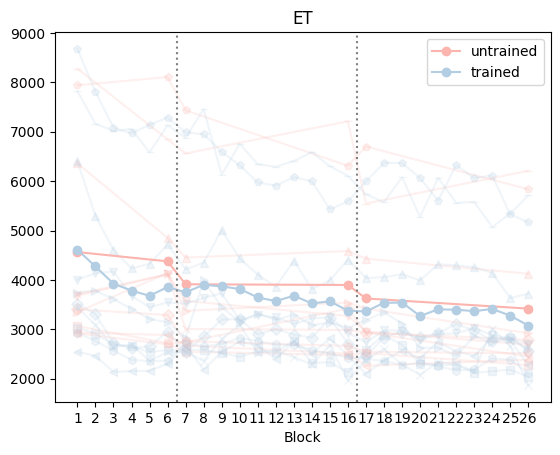

In [29]:
cmap = cm.Pastel1
test_blocks = subjs[subjs['BN'].isin(range(1,27))]

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']


test_blocks = utils.remove_error_trials(test_blocks)

session_grouped = test_blocks.groupby(['BN', 'SubNum', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'median'
}).reset_index()

for subnum, subj_data in session_grouped.groupby('SubNum'):
    for idx, ((flag_trained, flag_untrained), data) in enumerate(subj_data.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(1), alpha = 0.2)
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(0), alpha = 0.2)
            
        

session_grouped = session_grouped.groupby(['BN', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'mean'
}).reset_index()
for idx, ((flag_trained, flag_untrained), data) in enumerate(session_grouped.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(1), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(0), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))

plt.axvline(x=6.5, color='gray', linestyle='dotted')

plt.axvline(x=16.5, color='gray', linestyle='dotted')

plt.xticks(range(1,27))


plt.title('ET')

plt.xlabel('Block')

plt.legend()

plt.show()

In [38]:
subjects_above_avg

array([ 2,  7, 10,  4,  5])

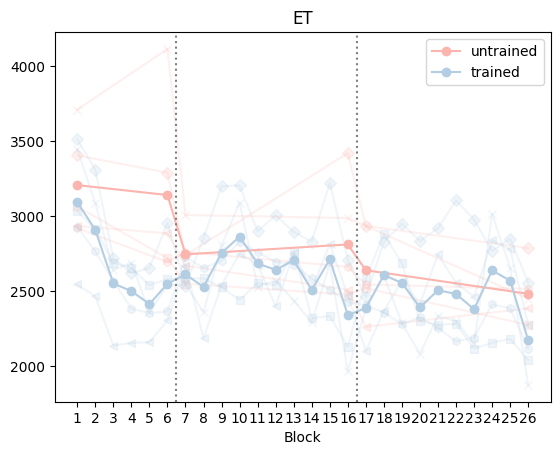

In [37]:
test_blocks = subjs[subjs['BN'].isin(range(1,27))]

test_blocks = utils.remove_error_trials(test_blocks)

# Group by block number and calculate the median norm_MT for each group
session_grouped = test_blocks.groupby(['BN', 'SubNum']).agg({
    'norm_MT': 'median'
}).reset_index()

# Calculate the average norm_MT for each block number (BN)
average_norm_MT = session_grouped.groupby('BN')['norm_MT'].mean().reset_index()
average_norm_MT = average_norm_MT.rename(columns={'norm_MT': 'avg_norm_MT'})

# Merge the average norm_MT with the session_grouped DataFrame
session_grouped = pd.merge(session_grouped, average_norm_MT, on='BN')

# Identify subjects that are above the average for any block
subjects_above_avg = session_grouped[session_grouped['norm_MT'] > session_grouped['avg_norm_MT']]['SubNum'].unique()


session_grouped = test_blocks.groupby(['BN', 'SubNum', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'median'
}).reset_index()

# Filter out the data for these subjects
filtered_data = session_grouped[~session_grouped['SubNum'].isin(subjects_above_avg)]

# Plot the remaining data
cmap = cm.Pastel1
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']

for subnum, subj_data in filtered_data.groupby('SubNum'):
    for idx, ((flag_trained, flag_untrained), data) in enumerate(subj_data.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(1), alpha = 0.2)
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(0), alpha = 0.2)

filtered_data_mean = filtered_data.groupby(['BN', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'mean'
}).reset_index()
for idx, ((flag_trained, flag_untrained), data) in enumerate(filtered_data_mean.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(1), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(0), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))

plt.axvline(x=6.5, color='gray', linestyle='dotted')
plt.axvline(x=16.5, color='gray', linestyle='dotted')
plt.xticks(range(1, 27))
plt.title('ET')
plt.xlabel('Block')
plt.legend()
plt.show()


In [40]:
subjs_presses = subjs_presses[~subjs_presses['SubNum'].isin(subjects_above_avg)]
subjs = subjs[~subjs['SubNum'].isin(subjects_above_avg)]


## Session3 Analysis:


## IPI Analysis:

IPI:  IPI0 TtestResult(statistic=1.756876254386844, pvalue=0.15377650690001013, df=4)
IPI:  IPI1 TtestResult(statistic=-0.8409000955590962, pvalue=0.4477342745704522, df=4)
IPI:  IPI10 TtestResult(statistic=2.2342480092777177, pvalue=0.08918929580325559, df=4)
IPI:  IPI2 TtestResult(statistic=0.2342606428329091, pvalue=0.8262847141678553, df=4)
IPI:  IPI3 TtestResult(statistic=2.91547594742265, pvalue=0.04343949485670277, df=4)
IPI:  IPI4 TtestResult(statistic=1.0643041683803829, pvalue=0.34717310768434334, df=4)
IPI:  IPI5 TtestResult(statistic=2.493000955363006, pvalue=0.0672680731561497, df=4)
IPI:  IPI6 TtestResult(statistic=0.9101820546182063, pvalue=0.4142124691640813, df=4)
IPI:  IPI7 TtestResult(statistic=1.3383916948922172, pvalue=0.25177967544594126, df=4)
IPI:  IPI8 TtestResult(statistic=2.0971834133799288, pvalue=0.10398343396956075, df=4)
IPI:  IPI9 TtestResult(statistic=3.5, pvalue=0.02489616346022275, df=4)


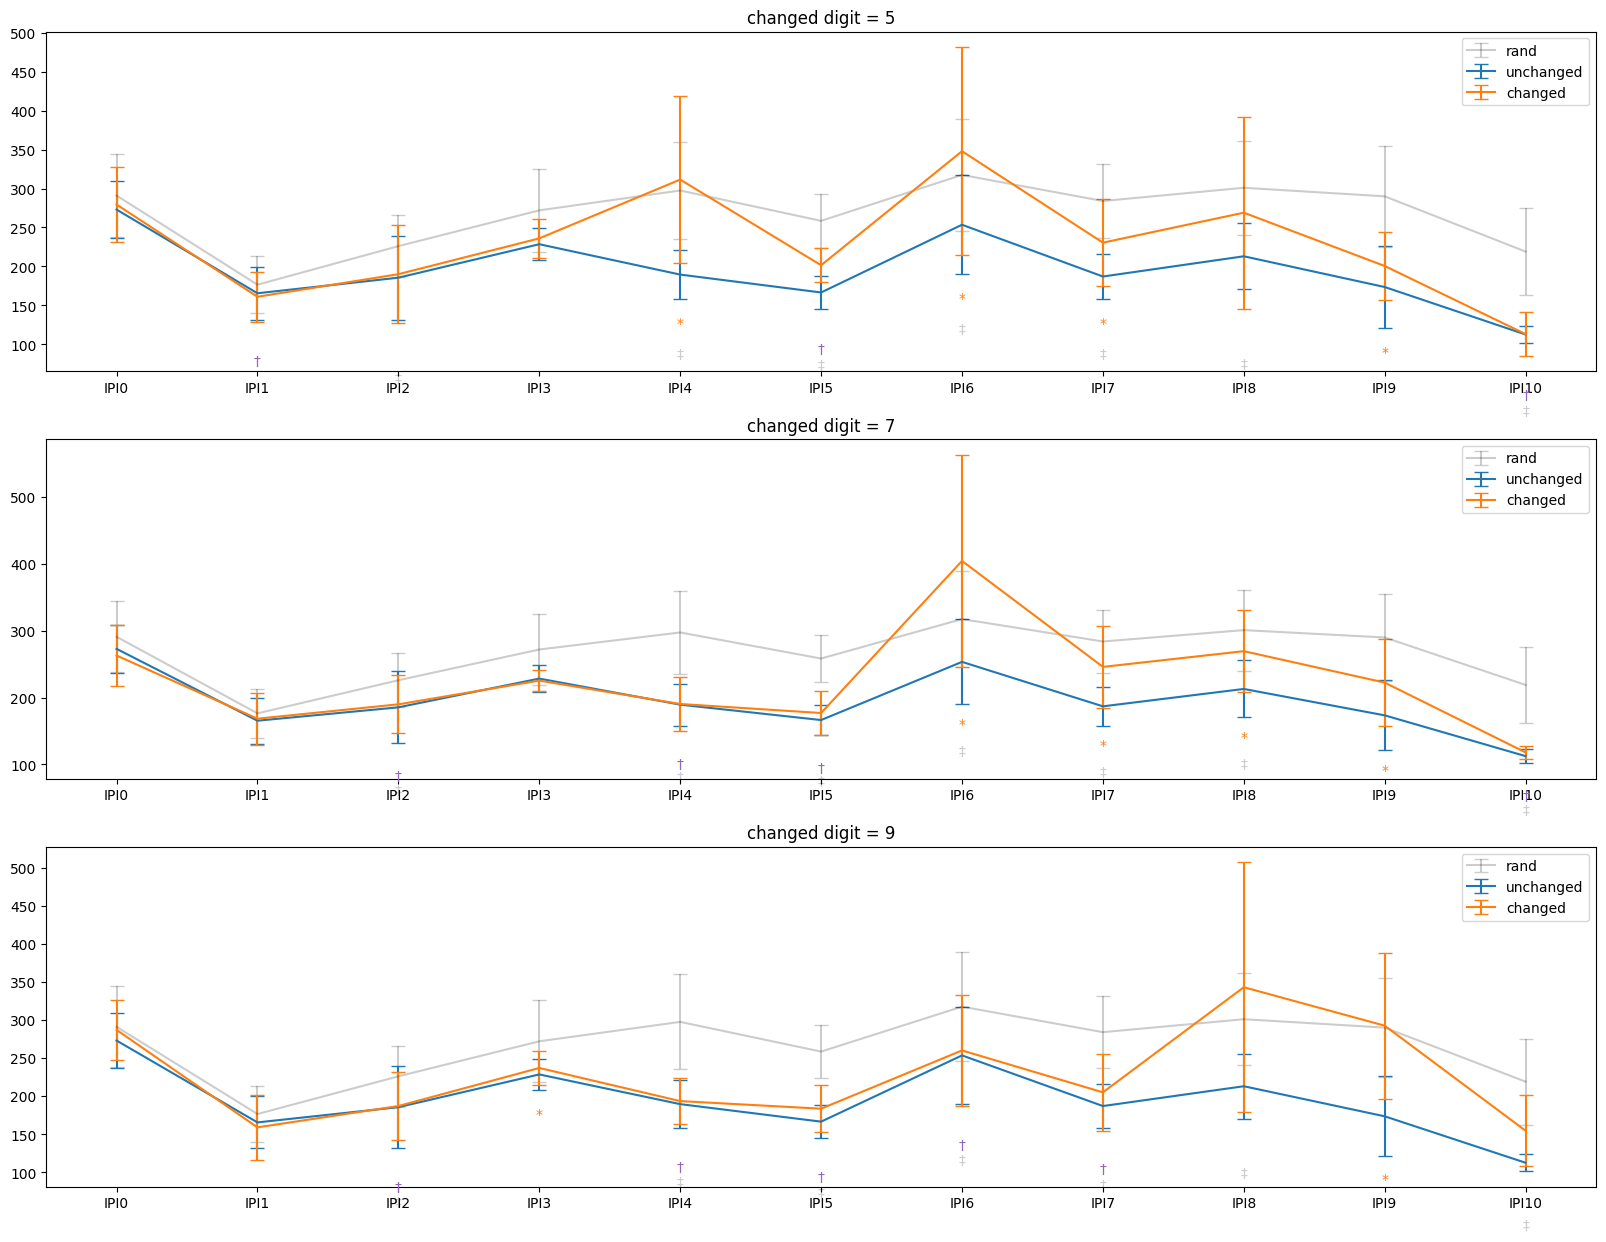

In [76]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))]

session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}

for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 8):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)



    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')

IPI:  IPI0 TtestResult(statistic=1.2626716210644433, pvalue=0.2753017833030315, df=4)
IPI:  IPI1 TtestResult(statistic=-0.6771991775797205, pvalue=0.5354236012013744, df=4)
IPI:  IPI10 TtestResult(statistic=0.8583950752789522, pvalue=0.4390679909357402, df=4)
IPI:  IPI2 TtestResult(statistic=2.1444640623357816, pvalue=0.09859229082966867, df=4)
IPI:  IPI3 TtestResult(statistic=3.4372512980029555, pvalue=0.026359972165370664, df=4)
IPI:  IPI4 TtestResult(statistic=2.9025094262684226, pvalue=0.04400710370124381, df=4)
IPI:  IPI5 TtestResult(statistic=3.761445415757156, pvalue=0.019750144481089953, df=4)
IPI:  IPI6 TtestResult(statistic=3.4702527326458545, pvalue=0.025577732708521254, df=4)
IPI:  IPI7 TtestResult(statistic=3.2680993517304615, pvalue=0.030844348608439976, df=4)
IPI:  IPI8 TtestResult(statistic=2.1530522587462793, pvalue=0.09764669675473577, df=4)
IPI:  IPI9 TtestResult(statistic=3.2566360302371042, pvalue=0.031179658752891467, df=4)


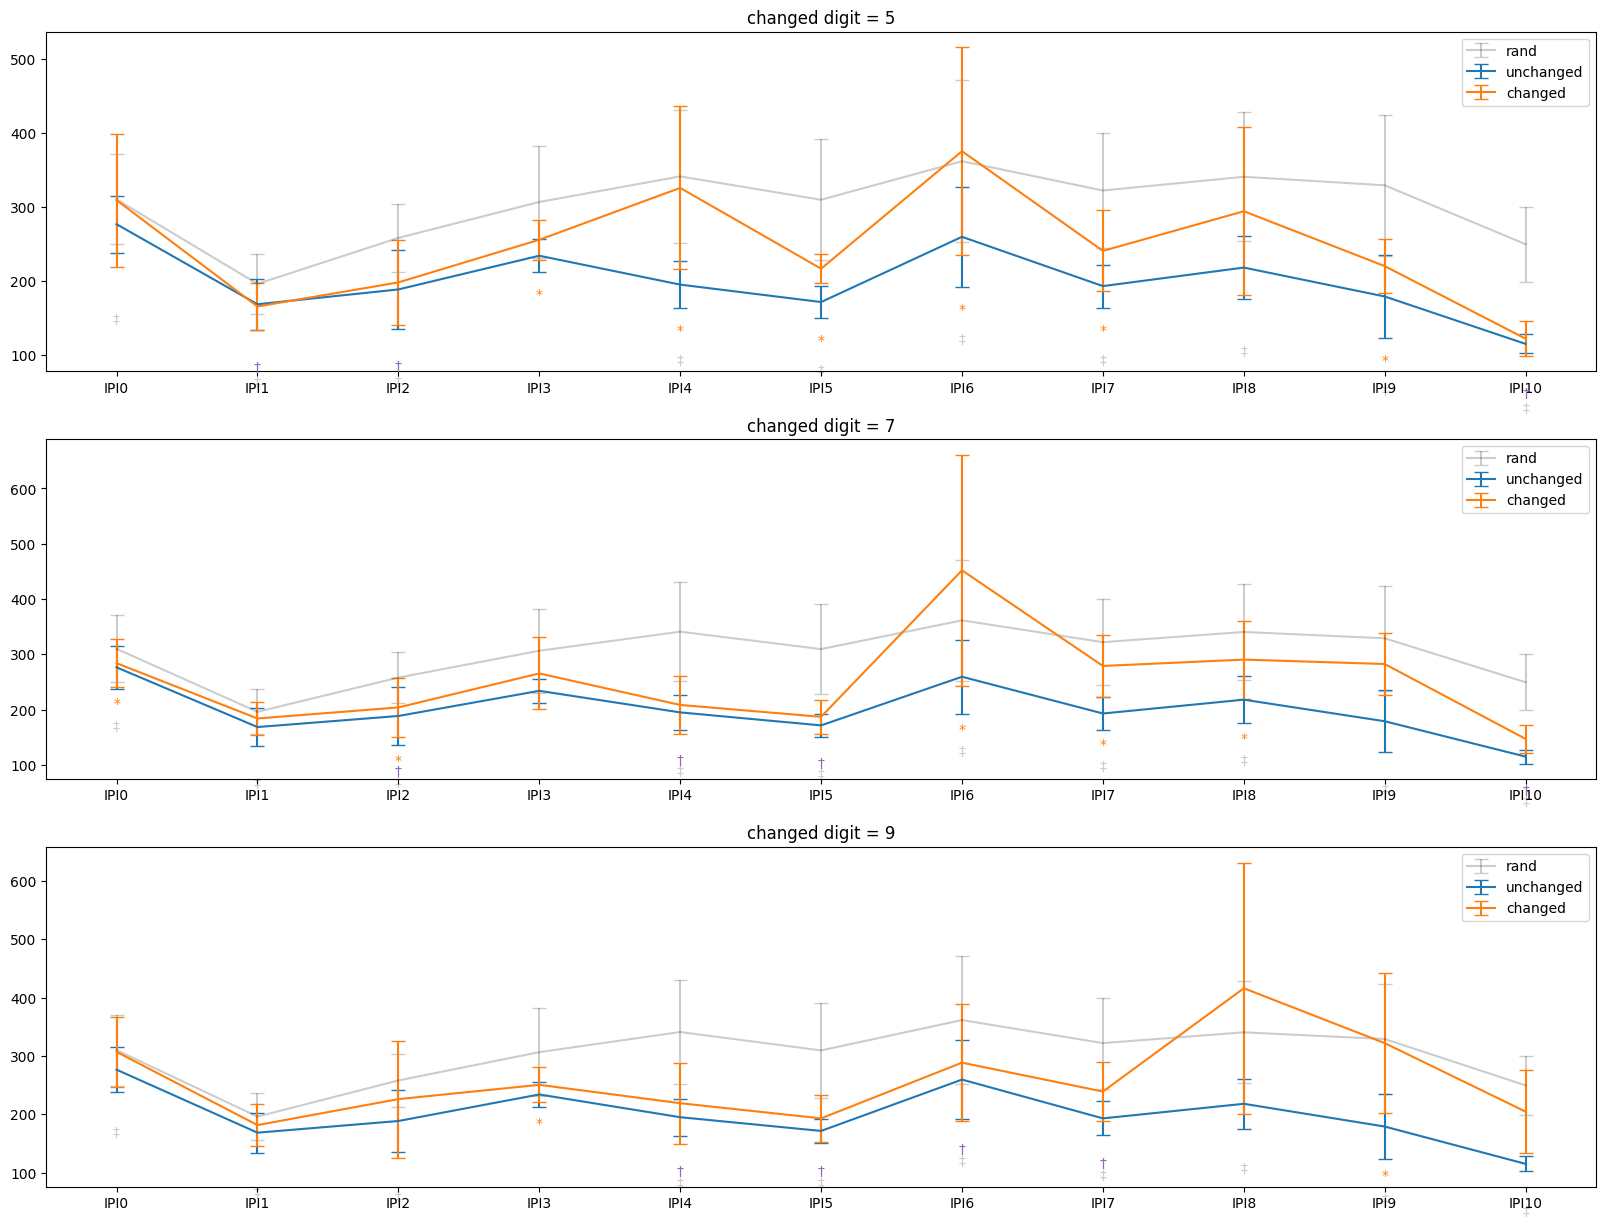

In [43]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))].copy()

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}


for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')

In [44]:
cmap = cm.Pastel1
capsize = 5


session3_blocks = subjs[subjs['BN'].isin(list(range(18,26)))].copy()

# session2_blocks = session2_blocks[session2_blocks['SubNum'] != 8]

session3_blocks['norm_MT'] = session3_blocks.apply(utils.correct_error_trial, axis = 1)




for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            for (digit, changed_data) in data.groupby('digitChangePos'):
                for (subnum, sub_data) in changed_data.groupby('SubNum'):
                    if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                         print(f"subj{subnum}_window{window}_changed{digit+1}_acc {len(sub_data[sub_data['isError'] == 0]) / len(sub_data)}")
                        #  if (subnum == 9 and window == 11):
                        #      print(sub_data['norm_MT'])
                        #      print(np.percentile(sub_data['norm_MT'], 0))
    

        if (flag_trained & ~flag_change):

            for (subnum, sub_data) in data.groupby('SubNum'):
                 if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                    print(f"subj{subnum}_window{window}_unchanged_acc {len(sub_data[sub_data['isError'] == 0]) / len(sub_data)}")

        if (flag_rand):
            for (subnum, sub_data) in data.groupby('SubNum'):
                 if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                    print(f"subj{subnum}_window{window}_rand_acc {round(len(sub_data[sub_data['isError'] == 0]) / len(sub_data), 2)}")



subj6_window2_rand_acc 0.58
subj9_window2_changed5_acc 0.5
subj6_window2_changed9_acc 0.5
subj9_window2_changed9_acc 0.5
subj3_window3_changed7_acc 0.5
subj8_window3_changed7_acc 0.5
subj3_window3_changed9_acc 0.5
subj6_window11_rand_acc 0.5
subj6_window11_changed7_acc 0.5
subj9_window11_changed7_acc 0.5
subj3_window11_changed9_acc 0.5
subj6_window11_changed9_acc 0.5


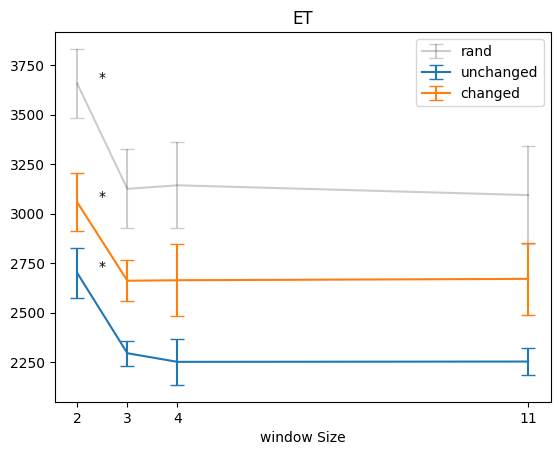

In [45]:
session3_blocks = subjs[subjs['BN'].isin(list(range(18,26)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}



for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 50)
    }).reset_index()
        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')





plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
plt.show()


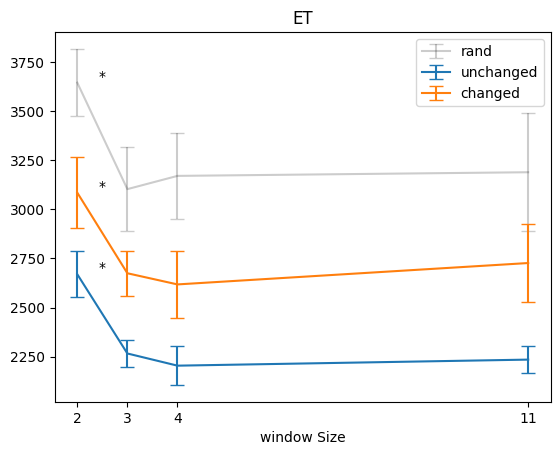

In [46]:
session3_blocks = subjs[subjs['BN'].isin(list(range(18,26)))].copy()

session3_blocks['norm_MT'] = session3_blocks.apply(utils.correct_error_trial, axis = 1)

# session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 40)
    }).reset_index()
        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')





plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
plt.show()


IPI:  IPI0 TtestResult(statistic=0.6743782700110322, pvalue=0.5370382158526943, df=4)
IPI:  IPI1 TtestResult(statistic=0.18144368465060579, pvalue=0.864842593300092, df=4)
IPI:  IPI10 TtestResult(statistic=-0.2824970092949416, pvalue=0.7915775797901268, df=4)
IPI:  IPI2 TtestResult(statistic=0.59398516110044, pvalue=0.5844854694218289, df=4)
IPI:  IPI3 TtestResult(statistic=1.7884641626025684, pvalue=0.1482154914057587, df=4)
IPI:  IPI4 TtestResult(statistic=2.7357996252142414, pvalue=0.05213048994244411, df=4)
IPI:  IPI5 TtestResult(statistic=1.7378432146605245, pvalue=0.15723393507446334, df=4)
IPI:  IPI6 TtestResult(statistic=3.2153429053750724, pvalue=0.032423711700548204, df=4)
IPI:  IPI7 TtestResult(statistic=4.344630823610224, pvalue=0.012208438223916093, df=4)
IPI:  IPI8 TtestResult(statistic=2.3119675540202977, pvalue=0.08185519712274128, df=4)
IPI:  IPI9 TtestResult(statistic=2.8011435573276446, pvalue=0.048754691924164595, df=4)


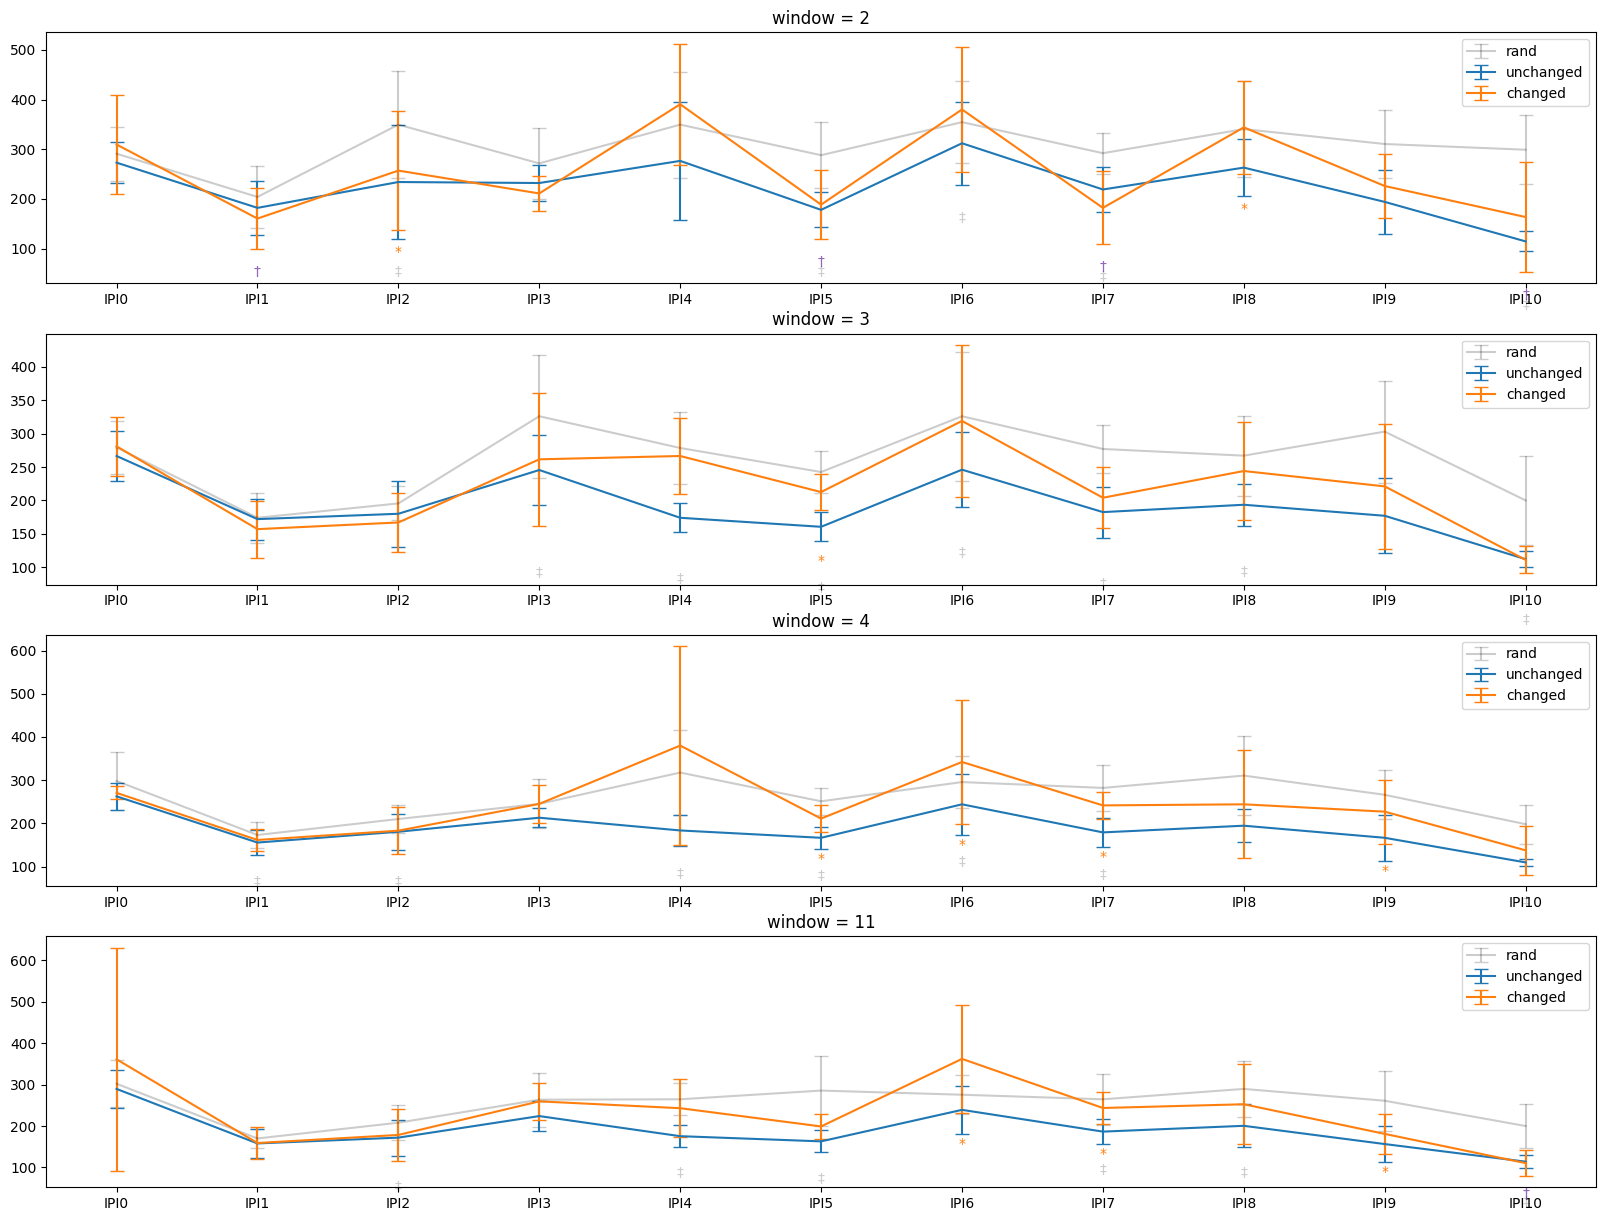

In [47]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))].copy()

session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 4]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=0.8595047928015812, pvalue=0.4385228823445342, df=4)
IPI:  IPI1 TtestResult(statistic=0.8746122168259984, pvalue=0.4311564207919032, df=4)
IPI:  IPI10 TtestResult(statistic=0.8114920516415269, pvalue=0.4626093809250178, df=4)
IPI:  IPI2 TtestResult(statistic=1.312708290464096, pvalue=0.2595308840829726, df=4)
IPI:  IPI3 TtestResult(statistic=1.8151622189242236, pvalue=0.14368250366842683, df=4)
IPI:  IPI4 TtestResult(statistic=3.21500856946949, pvalue=0.032434020822227586, df=4)
IPI:  IPI5 TtestResult(statistic=1.3027904549226161, pvalue=0.26258580486287747, df=4)
IPI:  IPI6 TtestResult(statistic=3.55936908380465, pvalue=0.02359937886844544, df=4)
IPI:  IPI7 TtestResult(statistic=1.828590243202916, pvalue=0.14145886470975907, df=4)
IPI:  IPI8 TtestResult(statistic=2.983145819494139, pvalue=0.040612305222436966, df=4)
IPI:  IPI9 TtestResult(statistic=2.7028413792731194, pvalue=0.05393536967720135, df=4)


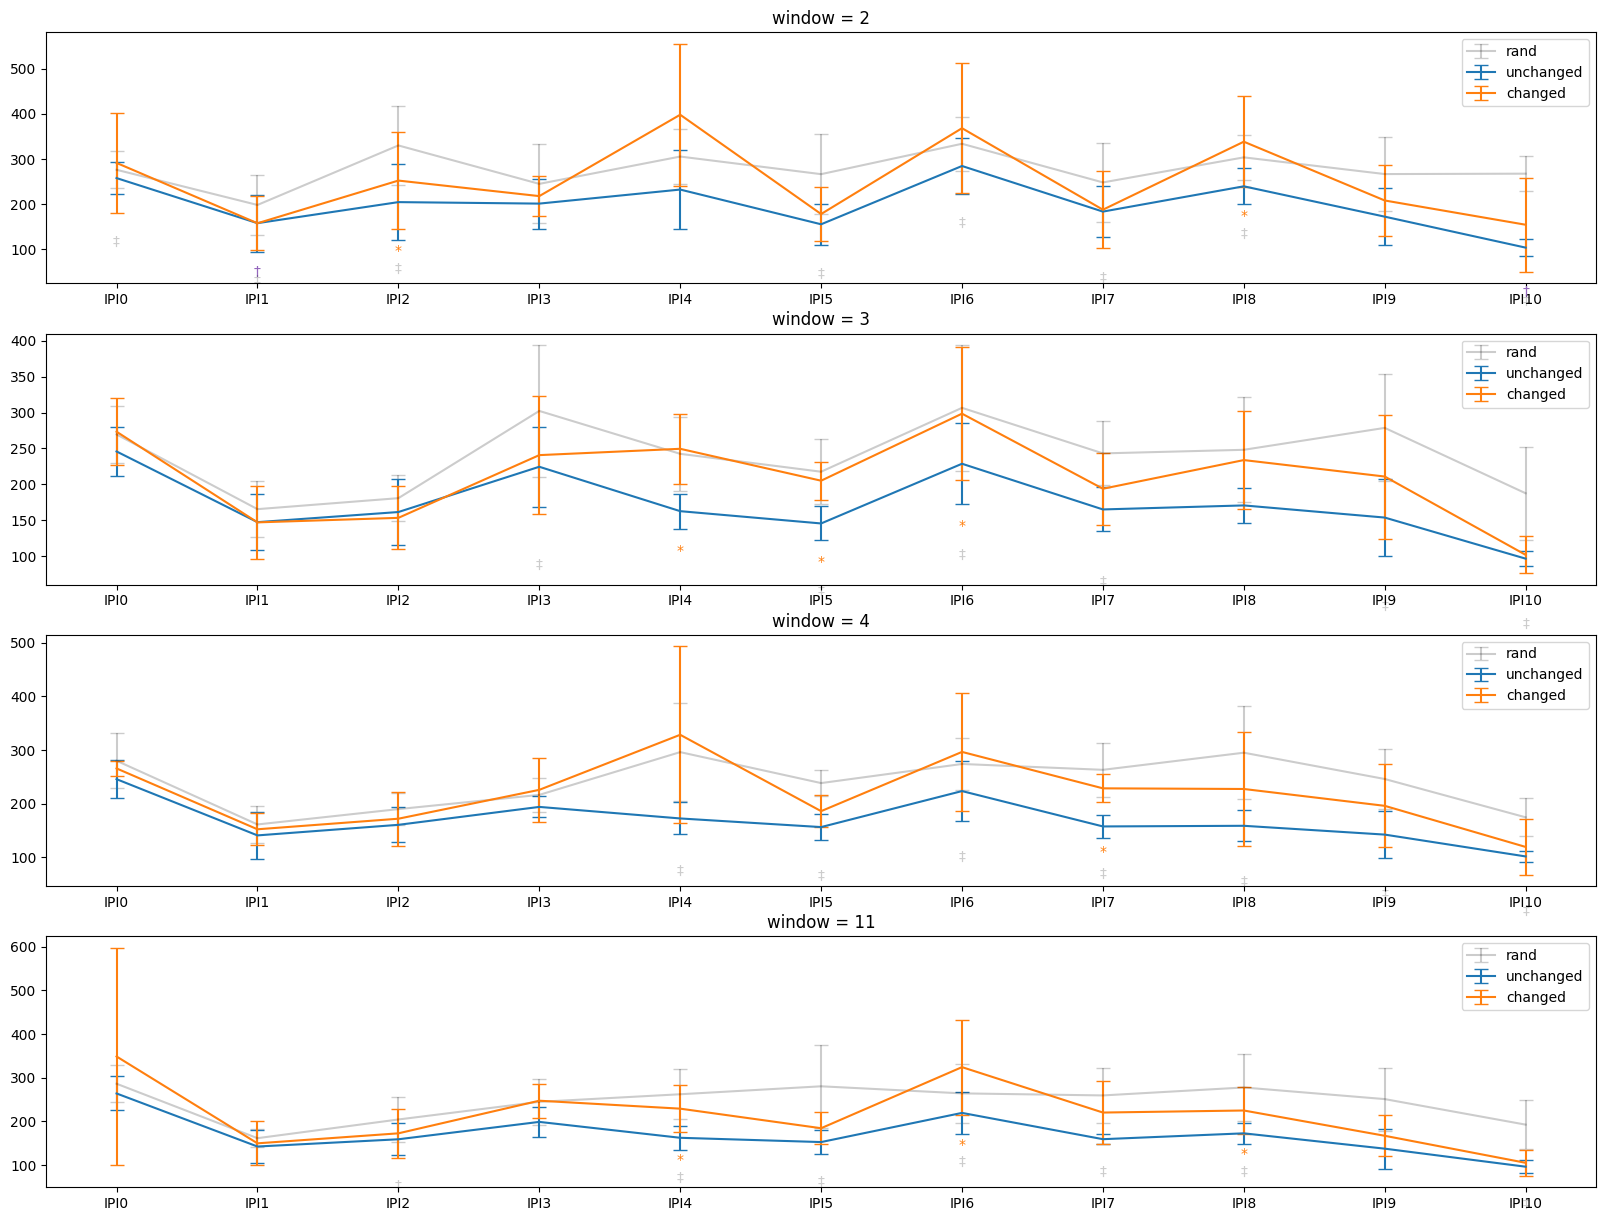

In [48]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))].copy()

# session3_blocks = session3_blocks[session3_blocks['SubNum'] != 2]

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 4]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=-1.1208347099863305, pvalue=0.3251014754160749, df=4)
IPI:  IPI1 TtestResult(statistic=0.14879590519303285, pvalue=0.8889148431193935, df=4)
IPI:  IPI10 TtestResult(statistic=1.337136925717977, pvalue=0.25215305558117196, df=4)
IPI:  IPI2 TtestResult(statistic=-1.3327172106920366, pvalue=0.2534725421065753, df=4)
IPI:  IPI3 TtestResult(statistic=0.0, pvalue=1.0, df=4)
IPI:  IPI4 TtestResult(statistic=0.12549116102763172, pvalue=0.9061891454139109, df=4)
IPI:  IPI5 TtestResult(statistic=1.2418408411301325, pvalue=0.28213534548563024, df=4)
IPI:  IPI6 TtestResult(statistic=2.994771024604139, pvalue=0.04014854440024537, df=4)
IPI:  IPI7 TtestResult(statistic=2.41295484430473, pvalue=0.0733198352435581, df=4)
IPI:  IPI8 TtestResult(statistic=1.8425469288633345, pvalue=0.13918674381003596, df=4)
IPI:  IPI9 TtestResult(statistic=3.312933772269731, pvalue=0.029573179124993774, df=4)


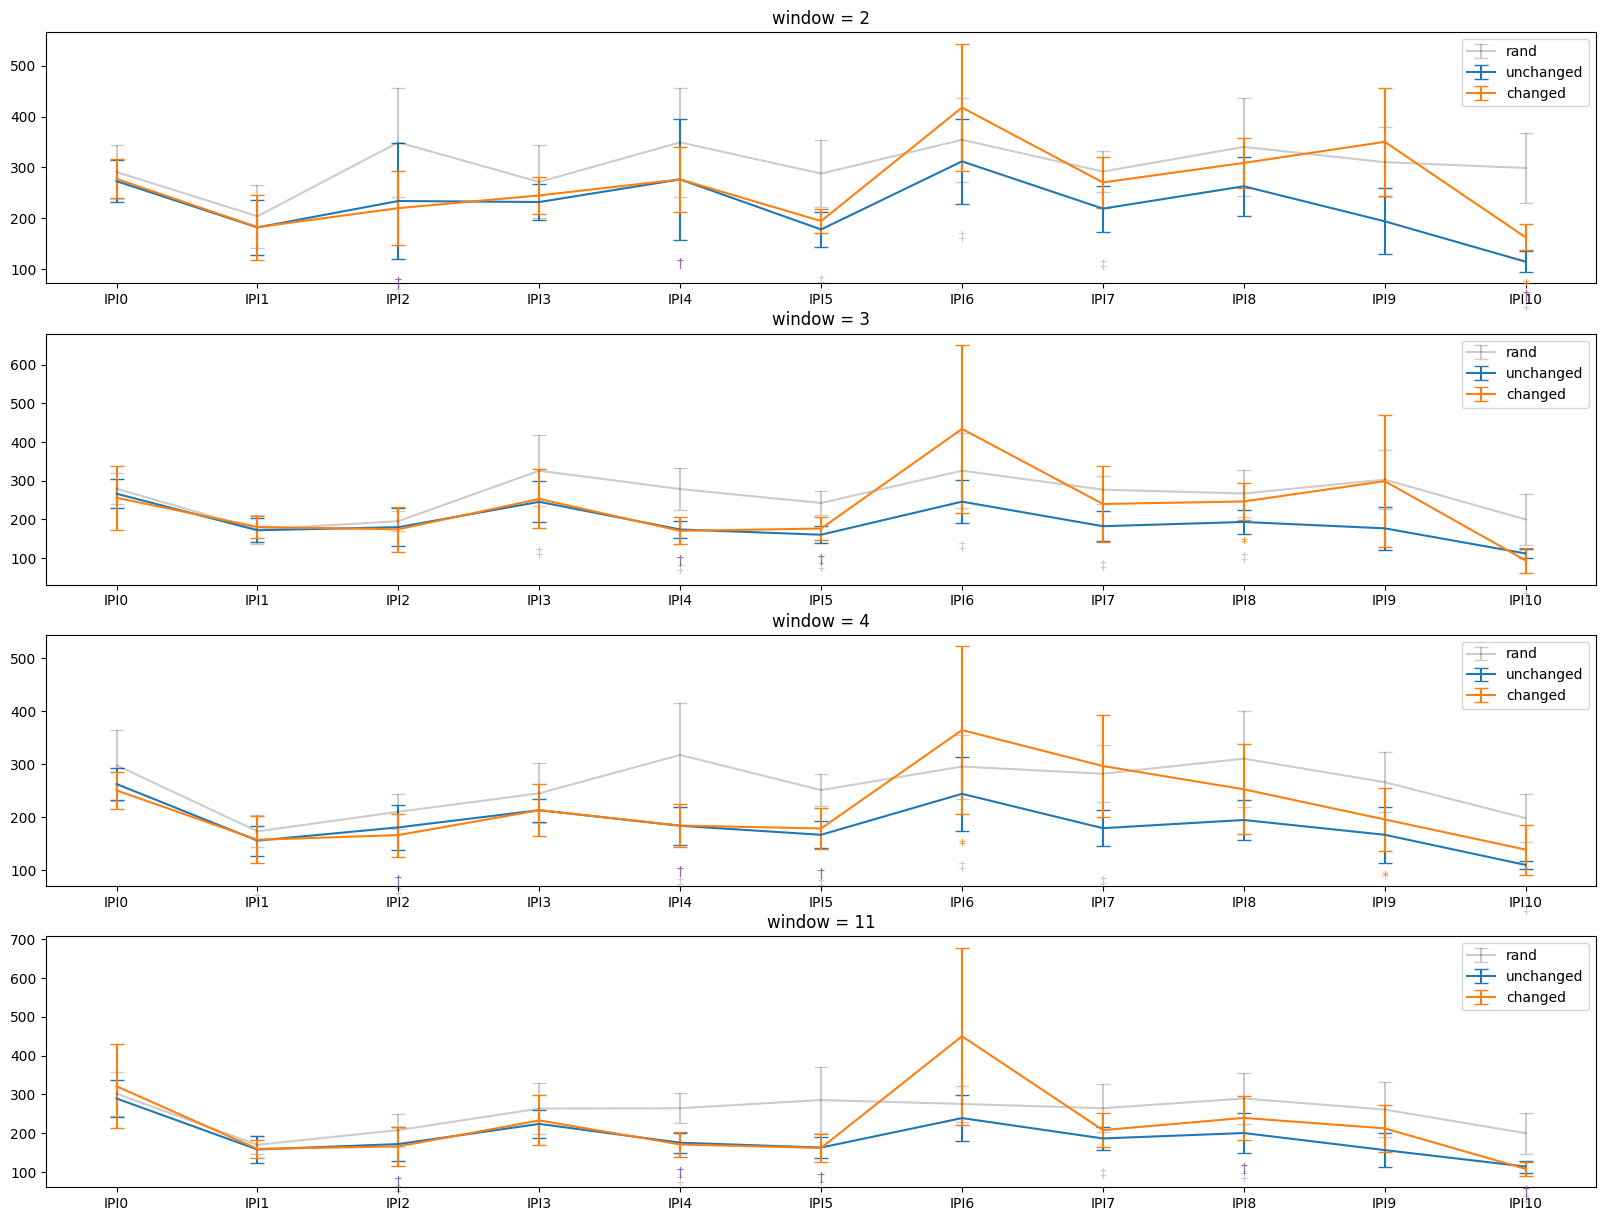

In [49]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))].copy()

session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 6]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=-0.4182916044147999, pvalue=0.6972151480249809, df=4)
IPI:  IPI1 TtestResult(statistic=0.7148863019982749, pvalue=0.514185381049095, df=4)
IPI:  IPI10 TtestResult(statistic=0.7786565136879746, pvalue=0.47967411450966896, df=4)
IPI:  IPI2 TtestResult(statistic=-0.502375724455552, pvalue=0.6417998232941993, df=4)
IPI:  IPI3 TtestResult(statistic=0.42450117813099114, pvalue=0.6930372116244243, df=4)
IPI:  IPI4 TtestResult(statistic=0.8502403057252129, pvalue=0.44309055172326206, df=4)
IPI:  IPI5 TtestResult(statistic=1.2816285603851492, pvalue=0.26922098912788145, df=4)
IPI:  IPI6 TtestResult(statistic=2.7534695391645716, pvalue=0.05119163843406676, df=4)
IPI:  IPI7 TtestResult(statistic=2.42273958050488, pvalue=0.07254783897760557, df=4)
IPI:  IPI8 TtestResult(statistic=1.9810909844467264, pvalue=0.11865339119228391, df=4)
IPI:  IPI9 TtestResult(statistic=4.327690584590455, pvalue=0.012372191525158413, df=4)


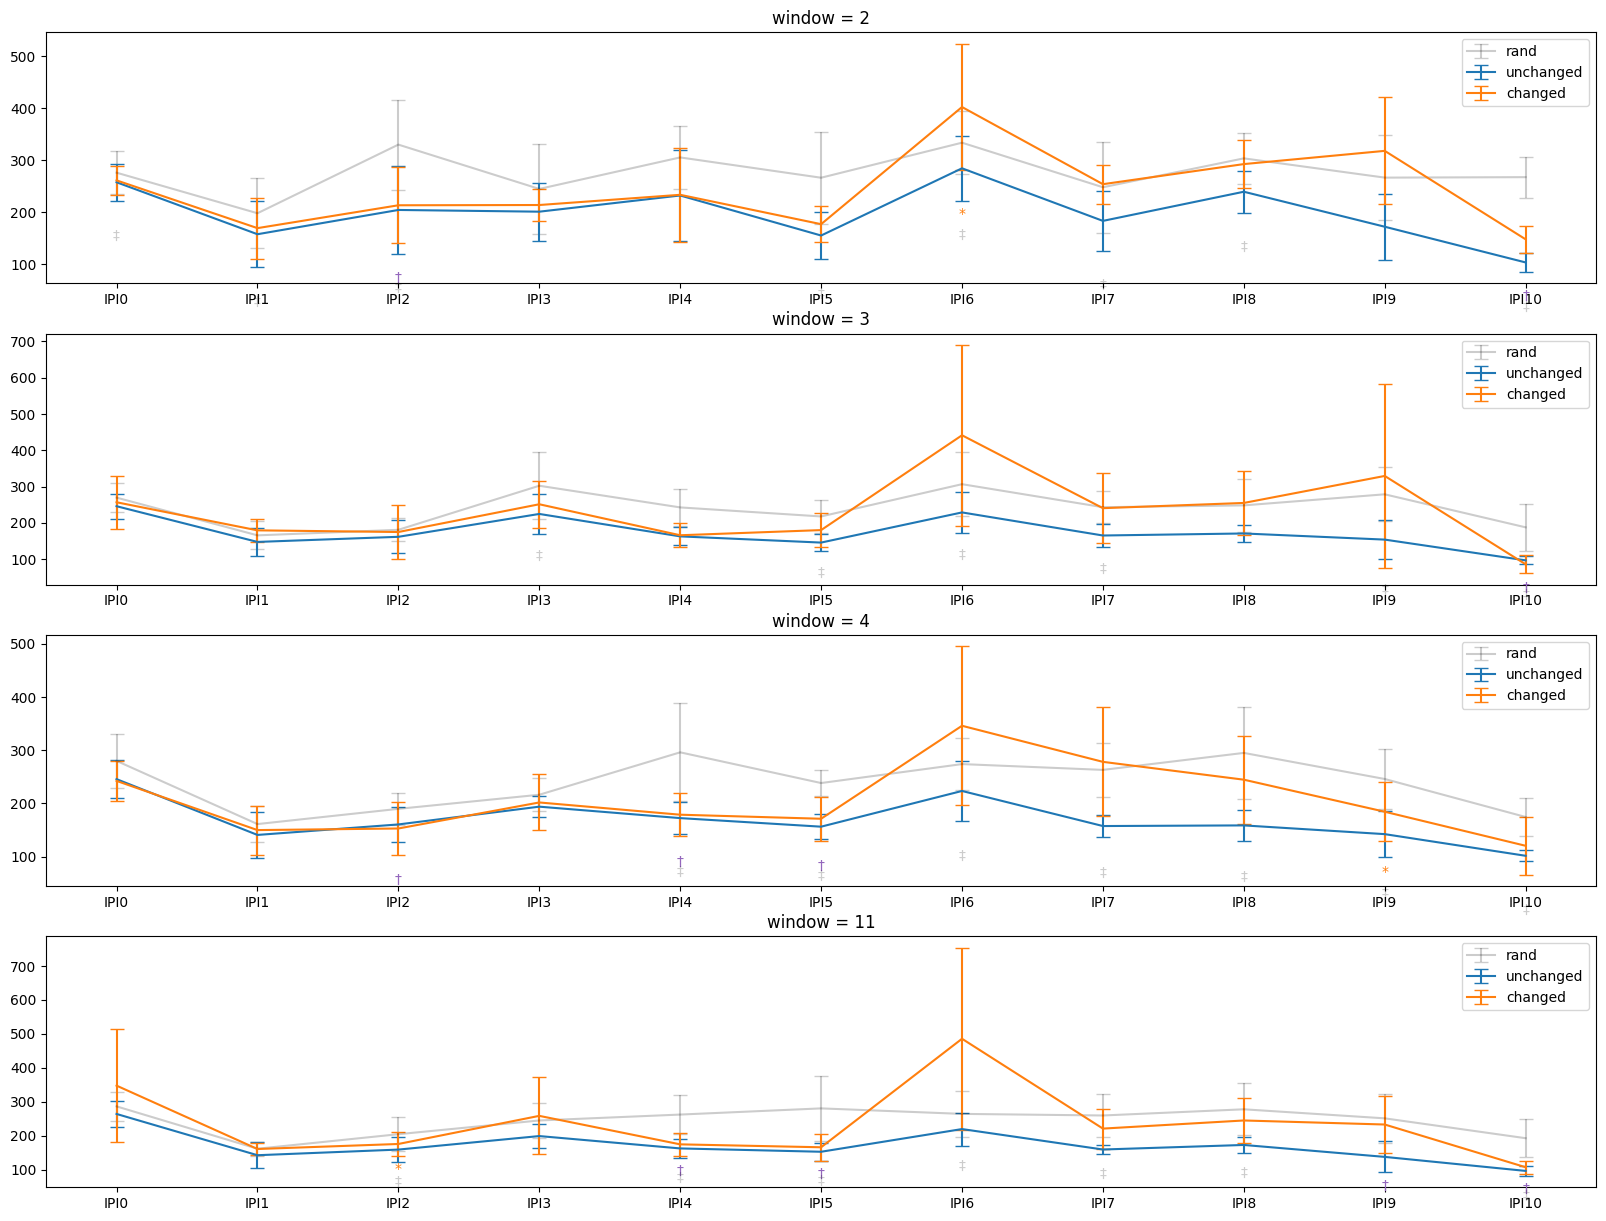

In [50]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))].copy()

# session3_blocks = session3_blocks[session3_blocks['SubNum'] != 2]

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 6]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=0.5008703226778094, pvalue=0.642769163194842, df=4)
IPI:  IPI1 TtestResult(statistic=1.1817437857851334, pvalue=0.3027633983185191, df=4)
IPI:  IPI10 TtestResult(statistic=2.086845054093079, pvalue=0.10520525162217512, df=4)
IPI:  IPI2 TtestResult(statistic=1.2997516207882607, pvalue=0.26352879471719703, df=4)
IPI:  IPI3 TtestResult(statistic=2.101350259504004, pvalue=0.1034954261790368, df=4)
IPI:  IPI4 TtestResult(statistic=-0.2512297172085311, pvalue=0.8140149560135778, df=4)
IPI:  IPI5 TtestResult(statistic=1.3351736838756898, pvalue=0.25273834185337724, df=4)
IPI:  IPI6 TtestResult(statistic=1.487746322912247, pvalue=0.21103369629744986, df=4)
IPI:  IPI7 TtestResult(statistic=2.13049456516523, pvalue=0.10015218585326997, df=4)
IPI:  IPI8 TtestResult(statistic=2.010310866031685, pvalue=0.11475825476228242, df=4)
IPI:  IPI9 TtestResult(statistic=2.595465994288813, pvalue=0.06033544327738486, df=4)


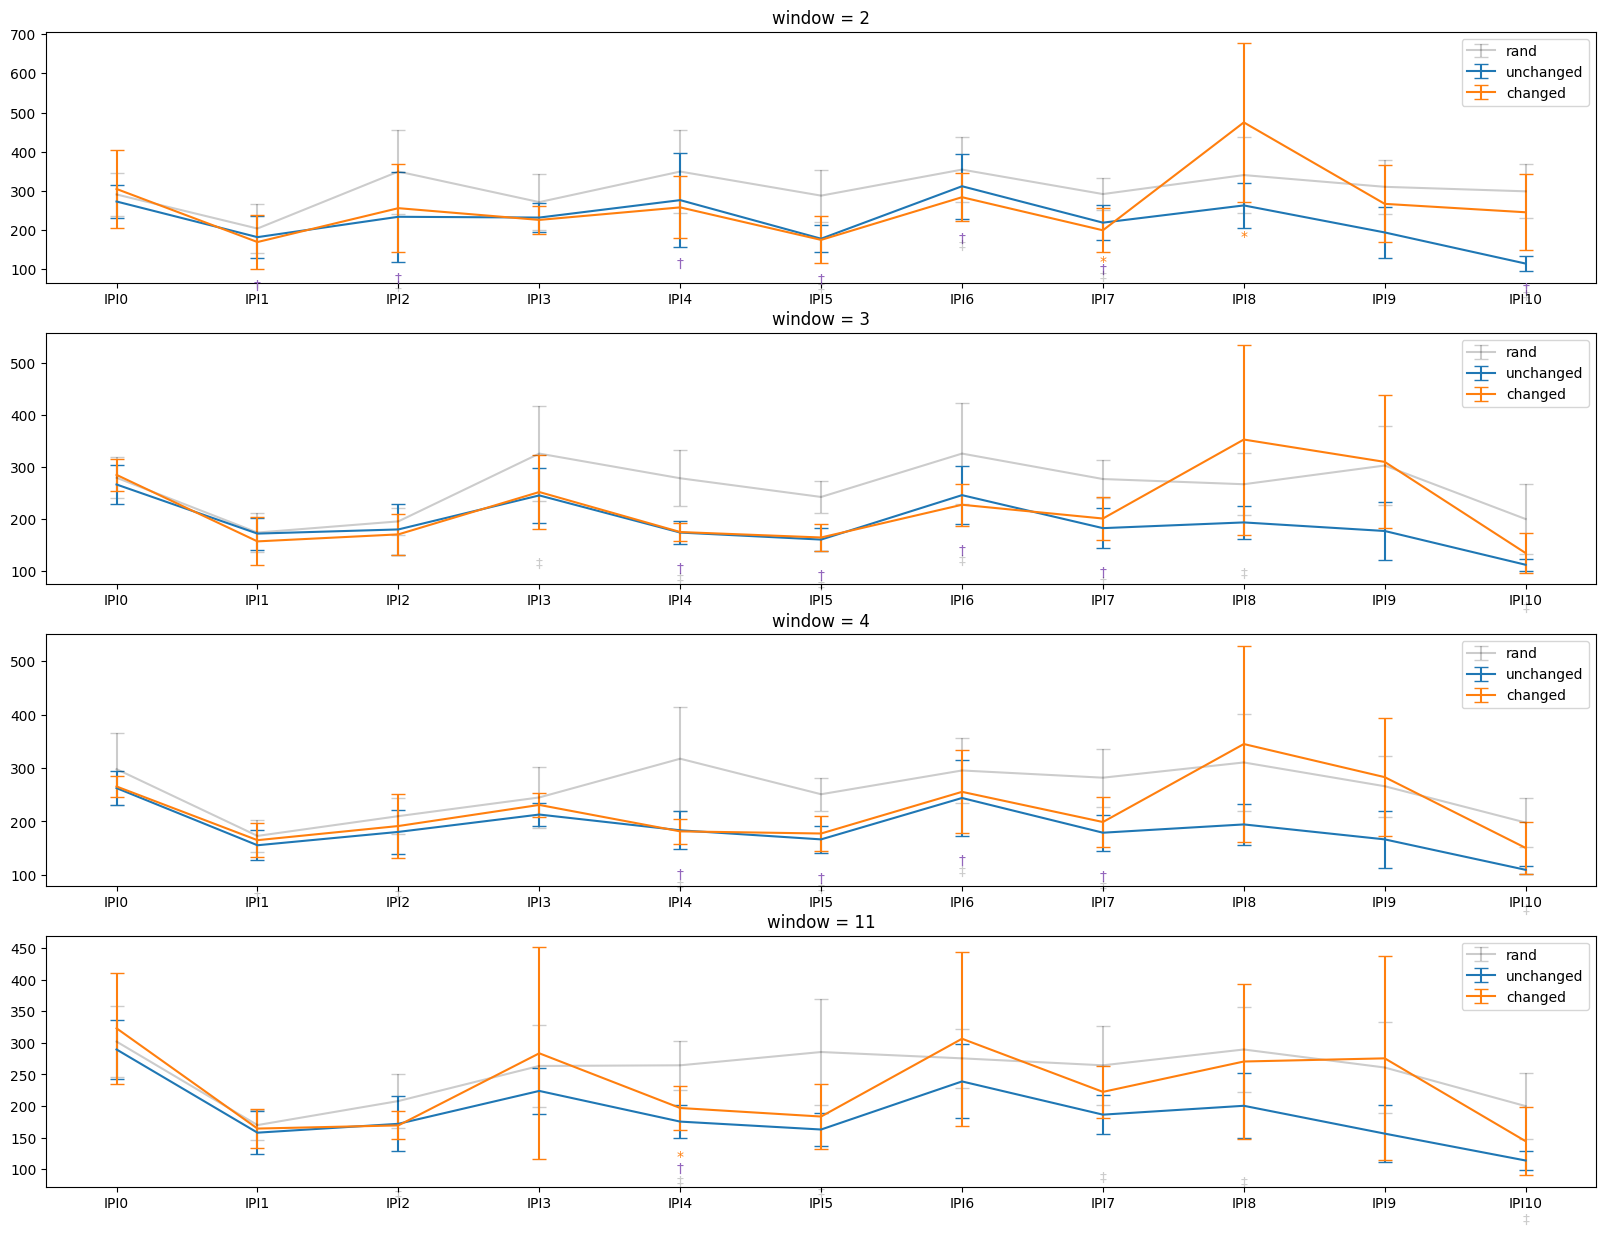

In [51]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))].copy()

session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 8]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=1.5204775859396533, pvalue=0.20302883434262248, df=4)
IPI:  IPI1 TtestResult(statistic=1.4098059160442922, pvalue=0.23140237044416184, df=4)
IPI:  IPI10 TtestResult(statistic=2.0317408714829996, pvalue=0.11199062795899878, df=4)
IPI:  IPI2 TtestResult(statistic=1.7742922030799608, pvalue=0.15068350600931357, df=4)
IPI:  IPI3 TtestResult(statistic=3.076769275028937, pvalue=0.03704789551399536, df=4)
IPI:  IPI4 TtestResult(statistic=-0.19274310798072036, pvalue=0.8565506767101271, df=4)
IPI:  IPI5 TtestResult(statistic=1.8370578339129637, pvalue=0.1400756486108111, df=4)
IPI:  IPI6 TtestResult(statistic=1.799555720096898, pvalue=0.14631400201656017, df=4)
IPI:  IPI7 TtestResult(statistic=1.789198299654524, pvalue=0.1480888226080324, df=4)
IPI:  IPI8 TtestResult(statistic=1.8040847508414655, pvalue=0.1455450700753508, df=4)
IPI:  IPI9 TtestResult(statistic=3.3703635312211104, pvalue=0.028034286720801563, df=4)


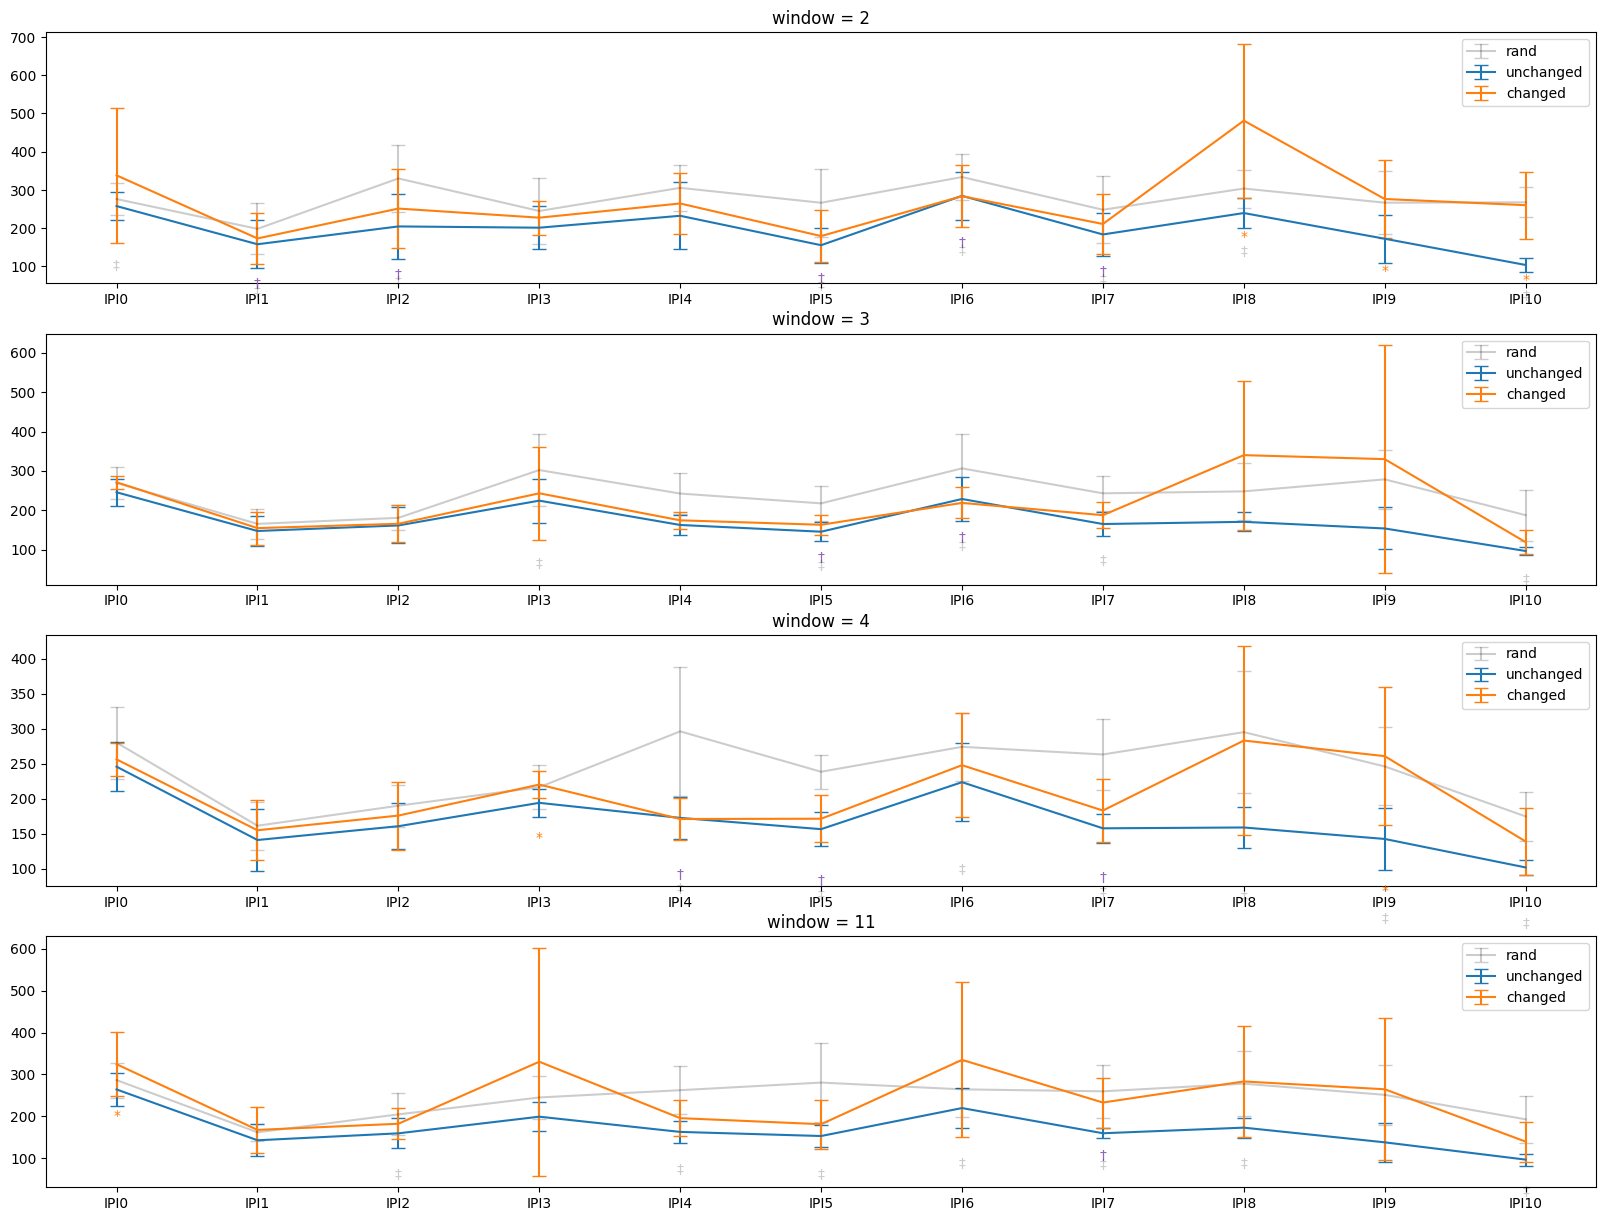

In [52]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(range(18,26))].copy()

# session3_blocks = session3_blocks[session3_blocks['SubNum'] != 2]

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 8]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


## All Test sessions Analysis:

### Error Analysis:

In [53]:
print("whole experiment number of trials: ", len(subjs))

print("whole experiment error trials: ", len(subjs[subjs['isError'] == 1]))


test_blocks = subjs[subjs['BN'].isin(list(range(8,16)) + list(range(18,26)))]

print("\n \ntest blocks number of trials: ", len(test_blocks))
print("test blocks error trials: ", len(test_blocks[test_blocks['isError'] == 1]))

non_test_blocks = subjs[~subjs['BN'].isin(list(range(8,16)) + list(range(18,26)))]
print("non test blocks error trials: ", len(non_test_blocks[non_test_blocks['isError'] == 1]))




session1_blocks = subjs[subjs['BN'].isin(range(1,7))]
print("\n \nfirst sessions number of trials: ", len(session1_blocks))
print("first sessions error trials: ", len(session1_blocks[session1_blocks['isError'] == 1]))

session2_blocks = subjs[subjs['BN'].isin(range(7, 17))]
print("\n\nsecond session number of trials: ", len(session2_blocks))
print("second session error trials: ", len(session2_blocks[session2_blocks['isError'] == 1]))


session2_pre_post = subjs[subjs['BN'].isin([7,16])]
session3_pre_post = subjs[subjs['BN'].isin([17,26])]
print("\n \nsecond sessions error trials in pre and post: ", len(session2_pre_post[session2_pre_post['isError'] == 1]))
print("\n \nthird sessions error trials in pre and post: ", len(session3_pre_post[session3_pre_post['isError'] == 1]))


whole experiment number of trials:  4000
whole experiment error trials:  555

 
test blocks number of trials:  2400
test blocks error trials:  338
non test blocks error trials:  217

 
first sessions number of trials:  960
first sessions error trials:  132


second session number of trials:  1520
second session error trials:  213

 
second sessions error trials in pre and post:  41

 
third sessions error trials in pre and post:  44


In [54]:
test_blocks = subjs[subjs['BN'].isin(list(range(8,16)) + list(range(18,26)))]

print("test blocks number of trials: ", len(test_blocks))

subjs_test_error = test_blocks[test_blocks['isError'] == 1]

print("test blocks number of errors: ", len(subjs_test_error))


for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):
                for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                        print(f"digit {digit+1} : {len(digit_presses)}")


        if (flag_trained & ~flag_change):
                print(f"unchanged: {len(data)}")


        if (flag_rand):
                print(f"rand: {len(data)}")



test blocks number of trials:  2400
test blocks number of errors:  338
rand: 192
unchanged: 68
digit 5 : 19
digit 7 : 27
digit 9 : 32


error median:  230.0
non error median:  220.0


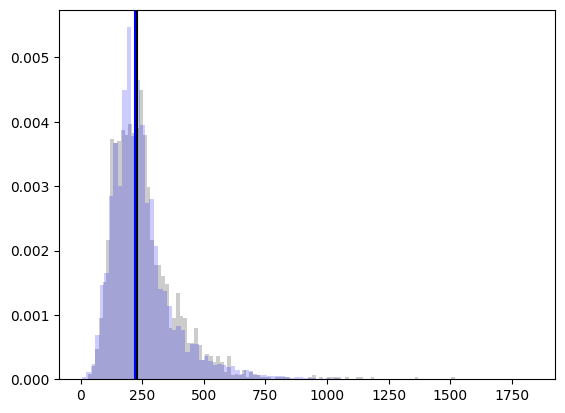

In [55]:
test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks_error = test_blocks[test_blocks['isTrialError'] == 1]

test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)

test_blocks_non_error = utils.remove_error_trials_presses(test_blocks)


plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
print("error median: ", test_blocks_error['IPI_Value'].median())

plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
print("non error median: ", test_blocks_non_error['IPI_Value'].median())


plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  220.0
non error median:  215.0


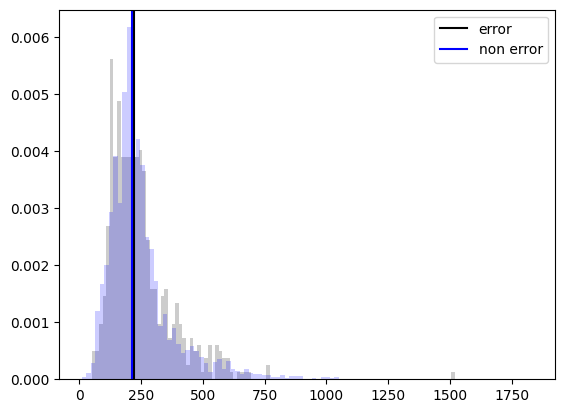

In [56]:
test_blocks_changed = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_trained_seq']) & (test_blocks_changed['is_digit_changed'])]

test_blocks_error = test_blocks_changed[test_blocks_changed['isTrialError'] == 1]

test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)

test_blocks_non_error = utils.remove_error_trials_presses(test_blocks_changed)


plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
print("error median: ", test_blocks_error['IPI_Value'].median())

plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
print("non error median: ", test_blocks_non_error['IPI_Value'].median())


plt.legend()
plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  240.0
non error median:  275.0
error median:  430.0
non error median:  370.0
error median:  262.5
non error median:  305.0


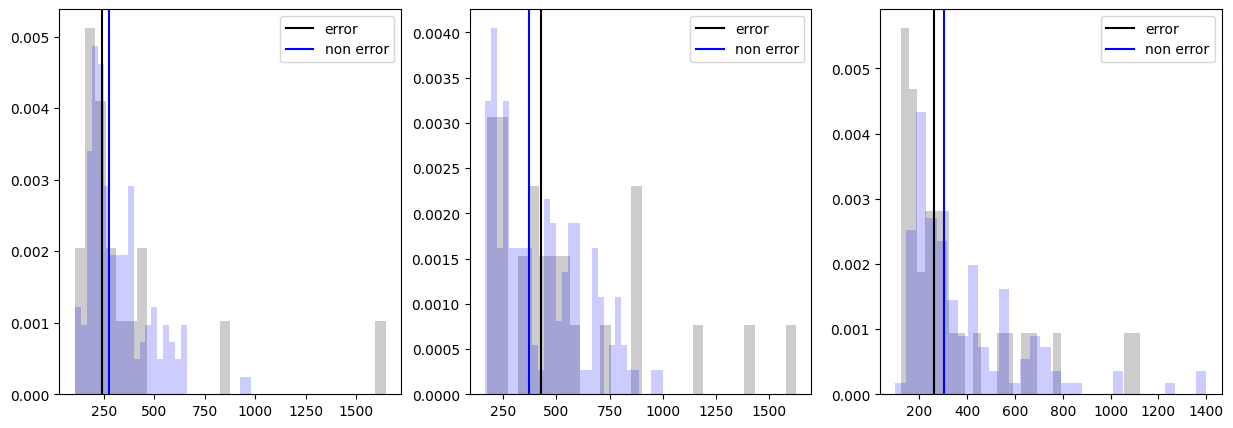

In [57]:
fig, axs = plt.subplots(1, len(digit_change), figsize = (15,5))

test_blocks_changed = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_trained_seq']) & (test_blocks_changed['is_digit_changed'])]

for idx, (digit, data) in enumerate(test_blocks_changed.groupby('digitChangePos')):

    data = data[data['IPI_Number'] == ('IPI'+ str(digit))]

    test_blocks_error = data[data['isTrialError'] == 1]

    # test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)

    test_blocks_non_error = utils.remove_error_trials_presses(data)

    axs[idx].hist(test_blocks_error['IPI_Value'], density=True, bins= 30, alpha = 0.2, color = 'black')
    axs[idx].axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
    print("error median: ", test_blocks_error['IPI_Value'].median())

    axs[idx].hist(test_blocks_non_error['IPI_Value'], density=True, bins = 30, alpha = 0.2, color = 'blue')
    axs[idx].axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
    print("non error median: ", test_blocks_non_error['IPI_Value'].median())
    
    axs[idx].legend()

plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  1250.0
non error median:  1225.0
error median:  1855.0
non error median:  1720.0
error median:  2372.5
non error median:  2155.0


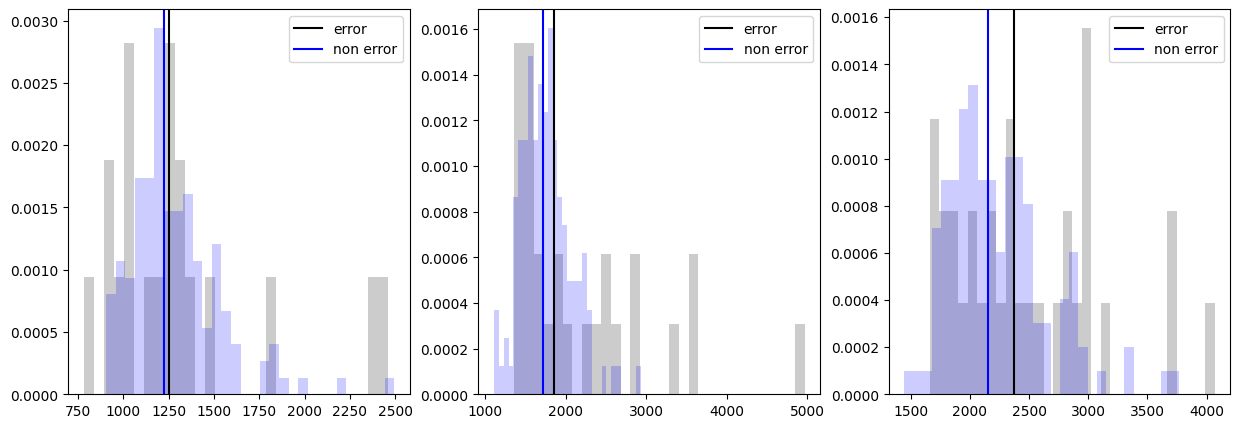

In [58]:
fig, axs = plt.subplots(1, len(digit_change), figsize = (15,5))

test_blocks_changed = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_trained_seq']) & (test_blocks_changed['is_digit_changed'])]

for idx, (digit, data) in enumerate(test_blocks_changed.groupby('digitChangePos')):

    data = data[data['IPI_Number'].isin(['IPI'+ str(x) for x in range(digit + 1)])]

    test_blocks_error = data[data['isTrialError'] == 1]
    test_blocks_error = test_blocks_error.groupby(['SubNum', 'BN' , 'TN']).agg({
        'IPI_Value': 'sum'
    }).reset_index()


    test_blocks_non_error = utils.remove_error_trials_presses(data)
    test_blocks_non_error = test_blocks_non_error.groupby(['SubNum', 'BN' , 'TN']).agg({
        'IPI_Value': 'sum'
    }).reset_index()


    axs[idx].hist(test_blocks_error['IPI_Value'], density=True, bins=30, alpha = 0.2, color = 'black')
    axs[idx].axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
    print("error median: ", test_blocks_error['IPI_Value'].median())

    axs[idx].hist(test_blocks_non_error['IPI_Value'], density=True, bins = 30, alpha = 0.2, color = 'blue')
    axs[idx].axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
    print("non error median: ", test_blocks_non_error['IPI_Value'].median())
    
    axs[idx].legend()

plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  1067.5
non error median:  1062.5
error median:  1542.5
non error median:  1537.5
error median:  2242.5
non error median:  2150.0


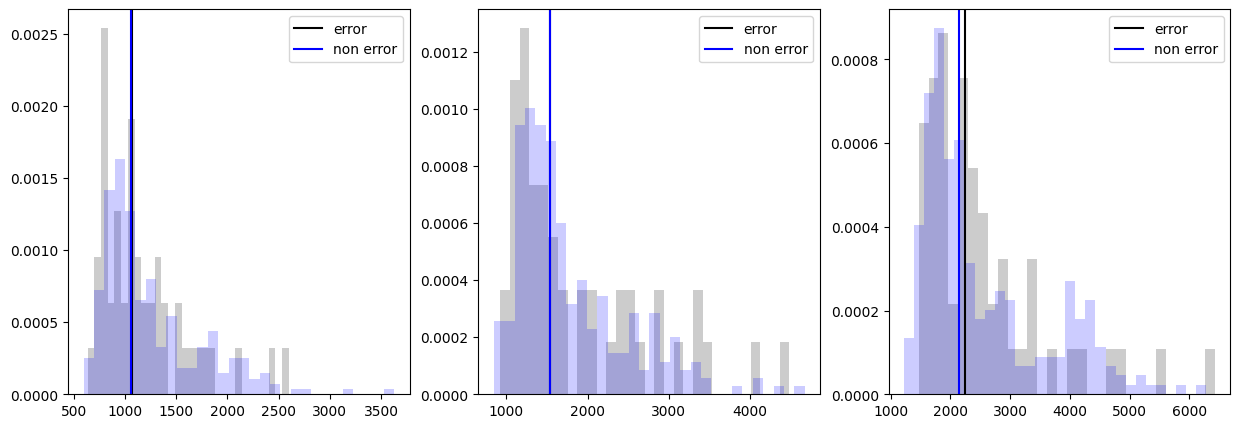

In [103]:
fig, axs = plt.subplots(1, len(digit_change), figsize = (15,5))

test_blocks_changed = subjs[subjs['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_trained_seq']) & (test_blocks_changed['is_digit_changed'])]

for idx, (digit, data) in enumerate(test_blocks_changed.groupby('digitChangePos')):
    

    test_blocks_error = data[data['isError'] == 1]
    test_blocks_error = test_blocks_error[['IPI'+ str(x) for x in range(digit)]]
    test_blocks_error['sum'] = test_blocks_error.sum(axis = 1)

    test_blocks_non_error = utils.remove_error_trials(data)
    test_blocks_non_error = test_blocks_non_error[['IPI'+ str(x) for x in range(digit)]]
    test_blocks_non_error['sum'] = test_blocks_non_error.sum(axis = 1)


    axs[idx].hist(test_blocks_error['sum'], density=True, bins=30, alpha = 0.2, color = 'black')
    axs[idx].axvline(test_blocks_error['sum'].median(), color ='black', label = 'error')
    print("error median: ", test_blocks_error['sum'].median())

    axs[idx].hist(test_blocks_non_error['sum'], density=True, bins = 30, alpha = 0.2, color = 'blue')
    axs[idx].axvline(test_blocks_non_error['sum'].median(), color = 'blue', label = 'non error')
    print("non error median: ", test_blocks_non_error['sum'].median())
    
    axs[idx].legend()

plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  270.0
non error median:  255.0


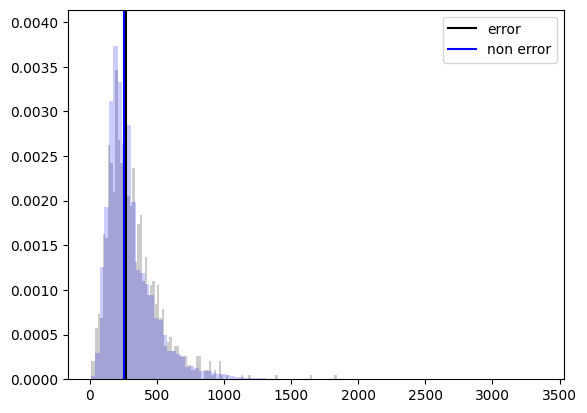

In [104]:
test_blocks_changed = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_trained_seq']) & ~(test_blocks_changed['is_digit_changed'])]

test_blocks_error = test_blocks_changed[test_blocks_changed['isTrialError'] == 1]

test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)

test_blocks_non_error = utils.remove_error_trials_presses(test_blocks_changed)


plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
print("error median: ", test_blocks_error['IPI_Value'].median())

plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
print("non error median: ", test_blocks_non_error['IPI_Value'].median())


plt.legend()
plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  300.0
non error median:  320.0


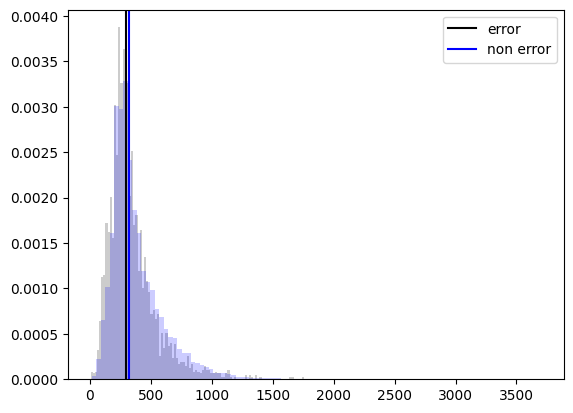

In [105]:
test_blocks_changed = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_rand_seq'])]

test_blocks_error = test_blocks_changed[test_blocks_changed['isTrialError'] == 1]

test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)

test_blocks_non_error = utils.remove_error_trials_presses(test_blocks_changed)


plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
print("error median: ", test_blocks_error['IPI_Value'].median())

plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
print("non error median: ", test_blocks_non_error['IPI_Value'].median())


plt.legend()
plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


rand: 253
unchanged: 111
digit 5 : 26
digit 7 : 35
digit 9 : 39


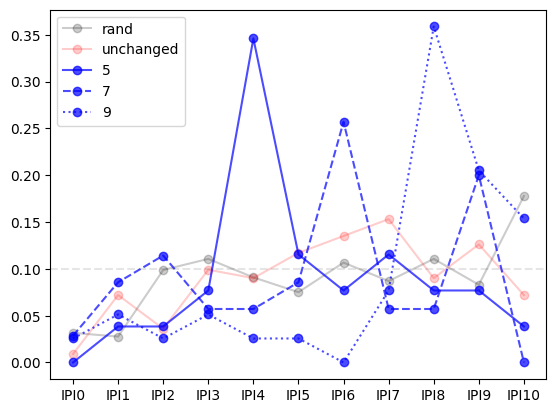

In [59]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]


subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):
                for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                        print(f"digit {digit+1} : {len(digit_presses)}")
                        proportions = digit_presses['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        plt.plot(proportions.index.values, proportions, color = 'blue', label = digit+1, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

        if (flag_trained & ~flag_change):
                print(f"unchanged: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'red', label = 'unchanged', marker = 'o', alpha = 0.2)

        if (flag_rand):
                print(f"rand: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'black', label = 'rand', marker = 'o', alpha = 0.2)

plt.axhline(y = 0.1, color = 'black', linestyle = '--', alpha = 0.1)

plt.legend()
plt.show()

rand: 192
unchanged: 68
digit 5 : 19
digit 7 : 27
digit 9 : 32


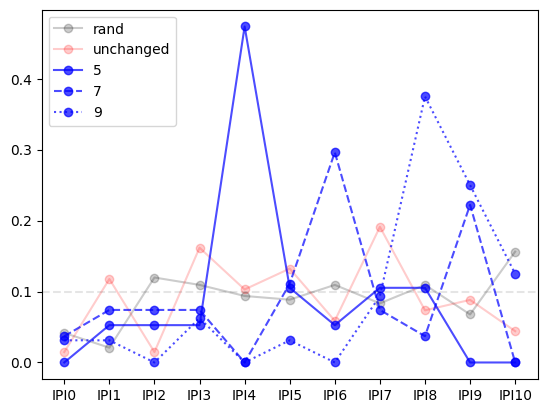

In [60]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks = utils.remove_remaining_next_error_presses(test_blocks)

subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):
                for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                        print(f"digit {digit+1} : {len(digit_presses)}")
                        proportions = digit_presses['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        plt.plot(proportions.index.values, proportions, color = 'blue', label = digit+1, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

        if (flag_trained & ~flag_change):
                print(f"unchanged: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'red', label = 'unchanged', marker = 'o', alpha = 0.2)

        if (flag_rand):
                print(f"rand: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'black', label = 'rand', marker = 'o', alpha = 0.2)

plt.axhline(y = 0.1, color = 'black', linestyle = '--', alpha = 0.1)

plt.legend()
plt.show()

**************** 
 window 2 
 **************
rand: 50
unchanged: 16
digit 5 : 7
digit 7 : 4
digit 9 : 12
**************** 
 window 3 
 **************
rand: 43
unchanged: 14
digit 5 : 4
digit 7 : 9
digit 9 : 4
**************** 
 window 4 
 **************
rand: 47
unchanged: 20
digit 5 : 3
digit 7 : 6
digit 9 : 6
**************** 
 window 11 
 **************
rand: 52
unchanged: 18
digit 5 : 5
digit 7 : 8
digit 9 : 10


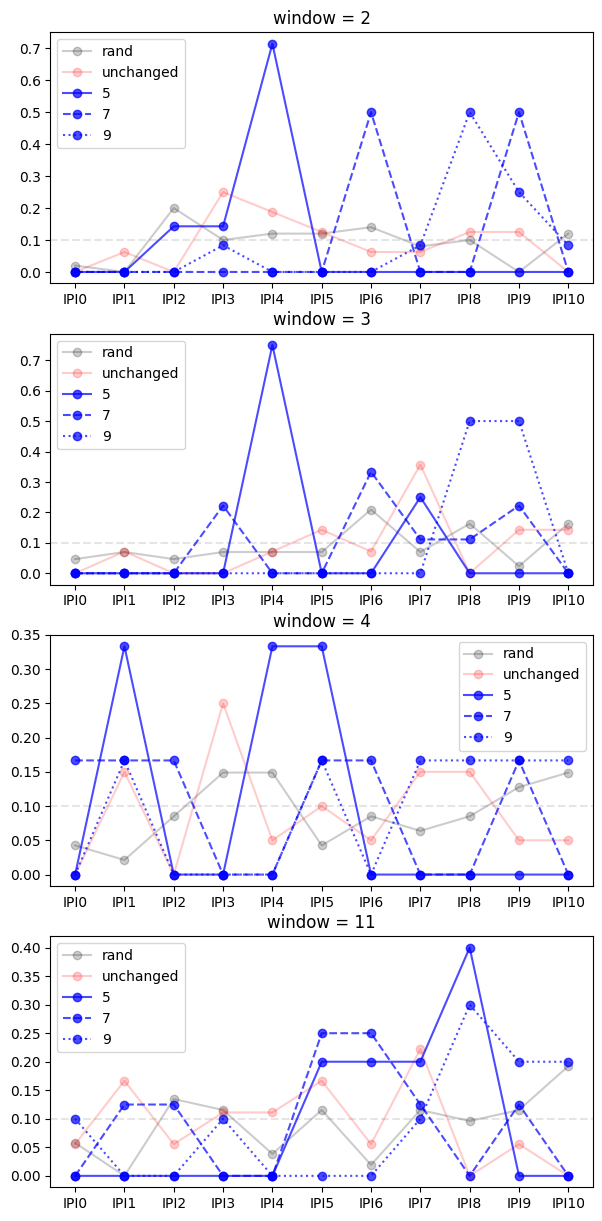

In [61]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']


fig, axs = plt.subplots(len(windowSizes), 1, figsize = (7,15))

for i, window in enumerate(windowSizes):
        print(f"**************** \n window {window} \n **************")

        test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

        test_blocks = test_blocks[test_blocks['windowSize'] == window]

        test_blocks = utils.remove_remaining_next_error_presses(test_blocks)


        subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

        for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
                if (flag_trained & flag_change):
                        for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                                print(f"digit {digit+1} : {len(digit_presses)}")
                                proportions = digit_presses['IPI_Number'].value_counts(sort=False)
                                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                                proportions /= sum(proportions)
                                axs[i].plot(proportions.index.values, proportions, color = 'blue', label = digit+1, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

                if (flag_trained & ~flag_change):
                        print(f"unchanged: {len(data)}")
                        proportions = data['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        axs[i].plot(proportions.index.values, proportions, color = 'red', label = 'unchanged', marker = 'o', alpha = 0.2)

                if (flag_rand):
                        print(f"rand: {len(data)}")
                        proportions = data['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        axs[i].plot(proportions.index.values, proportions, color = 'black', label = 'rand', marker = 'o', alpha = 0.2)

        axs[i].axhline(y = 0.1, color = 'black', linestyle = '--', alpha = 0.1)
        axs[i].legend()
        axs[i].set_title(f'window = {window}')
plt.show()

## IPI Analysis:

IPI:  IPI0 TtestResult(statistic=0.0, pvalue=1.0, df=4)
IPI:  IPI1 TtestResult(statistic=1.9069251784911847, pvalue=0.12920298463941007, df=4)
IPI:  IPI10 TtestResult(statistic=1.4509525002200234, pvalue=0.22041453616151405, df=4)
IPI:  IPI2 TtestResult(statistic=2.138089935299395, pvalue=0.09930068321372677, df=4)
IPI:  IPI3 TtestResult(statistic=-0.18940548952415137, pvalue=0.8589976700033937, df=4)
IPI:  IPI4 TtestResult(statistic=0.5468687416197306, pvalue=0.6135457051575997, df=4)
IPI:  IPI5 TtestResult(statistic=2.057983021710106, pvalue=0.10870095132492358, df=4)
IPI:  IPI6 TtestResult(statistic=2.8148608844294287, pvalue=0.04807861007553437, df=4)
IPI:  IPI7 TtestResult(statistic=2.603460831039174, pvalue=0.059829882296888744, df=4)
IPI:  IPI8 TtestResult(statistic=3.2420593617497953, pvalue=0.03161227337100386, df=4)
IPI:  IPI9 TtestResult(statistic=2.268117491529171, pvalue=0.08590611006232472, df=4)


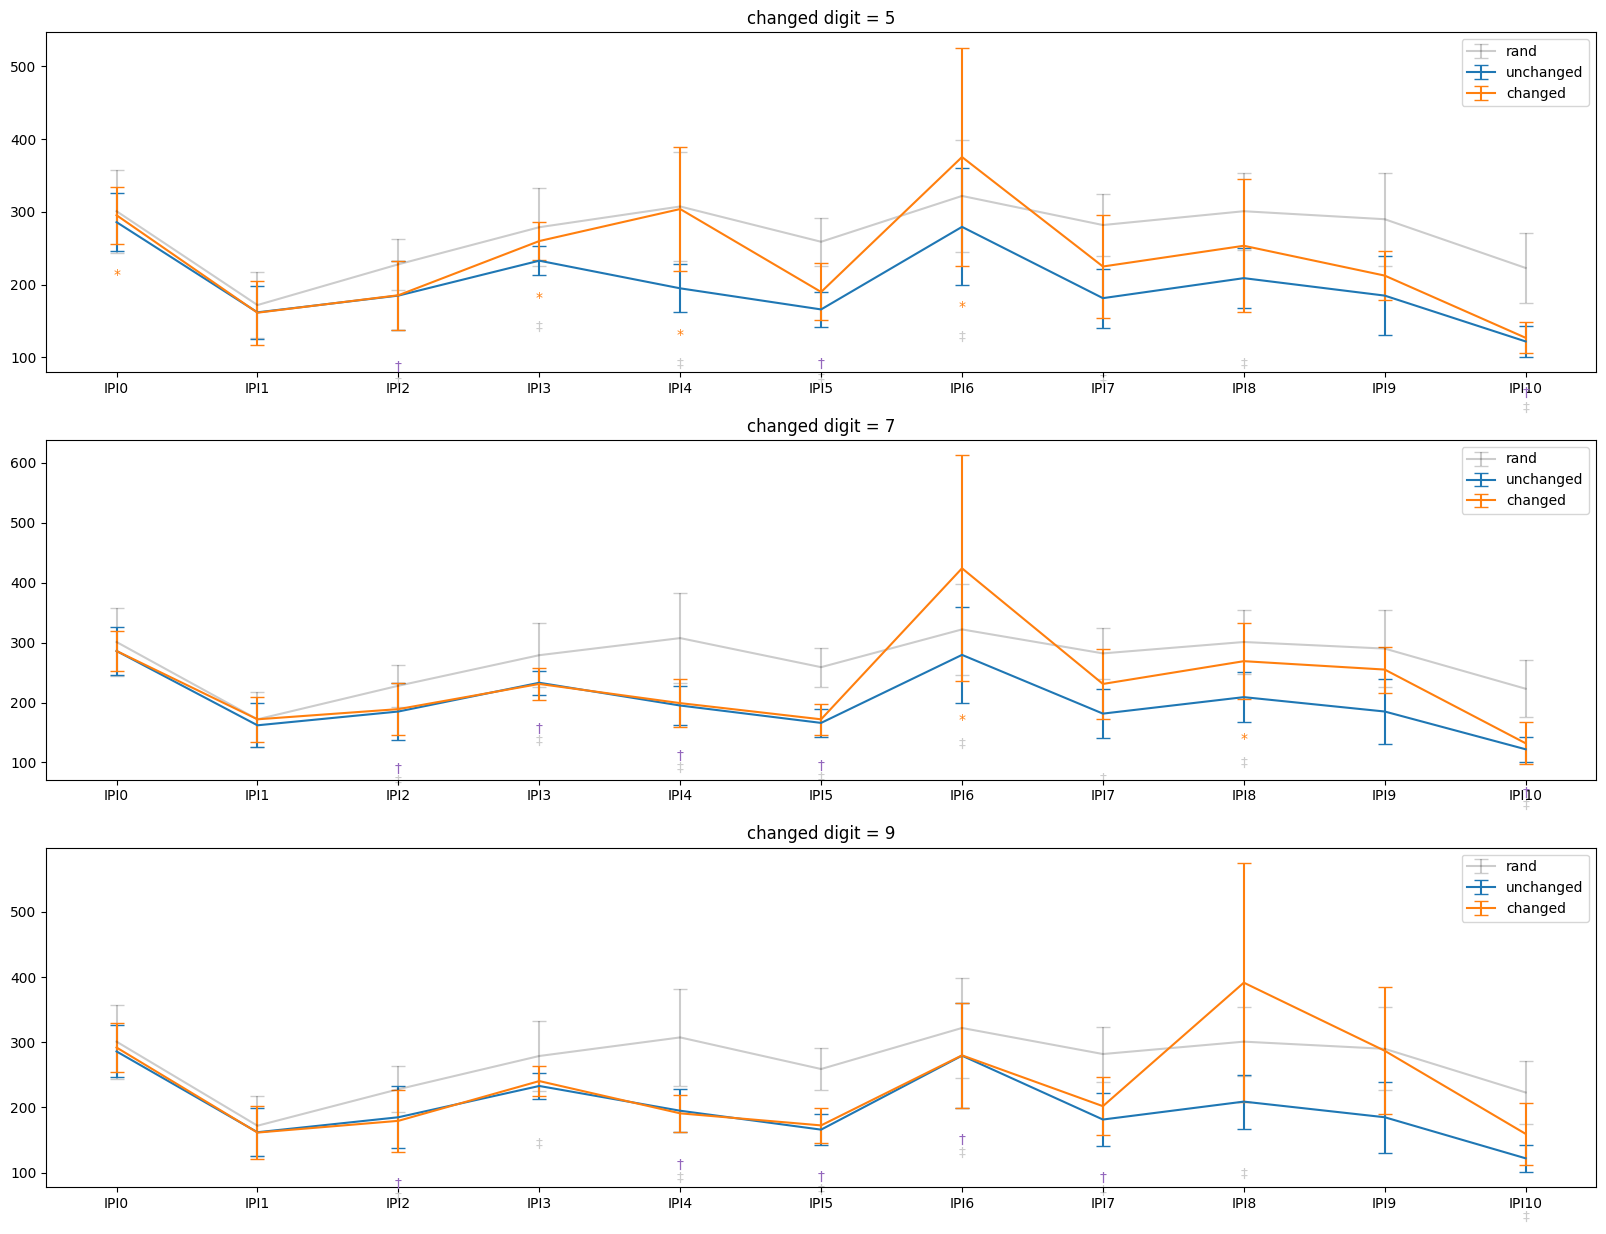

In [62]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}

for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 6):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)



    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')

IPI:  IPI0 TtestResult(statistic=2.637890531025524, pvalue=0.05770756612326124, df=4)
IPI:  IPI1 TtestResult(statistic=0.5468687416197306, pvalue=0.6135457051575997, df=4)
IPI:  IPI10 TtestResult(statistic=4.331969234286932, pvalue=0.01233058249261627, df=4)
IPI:  IPI2 TtestResult(statistic=2.7643789618603525, pvalue=0.050621762549260214, df=4)
IPI:  IPI3 TtestResult(statistic=4.428900580263033, pvalue=0.011431740984114185, df=4)
IPI:  IPI4 TtestResult(statistic=2.953980956336956, pvalue=0.04180360356525372, df=4)
IPI:  IPI5 TtestResult(statistic=2.2316194843683705, pvalue=0.08944991616019289, df=4)
IPI:  IPI6 TtestResult(statistic=3.0511657707692454, pvalue=0.037984911634673185, df=4)
IPI:  IPI7 TtestResult(statistic=2.720876411172607, pvalue=0.052938936896928496, df=4)
IPI:  IPI8 TtestResult(statistic=1.6986425498839322, pvalue=0.16461660934916209, df=4)
IPI:  IPI9 TtestResult(statistic=2.822956964161051, pvalue=0.04768468914168106, df=4)


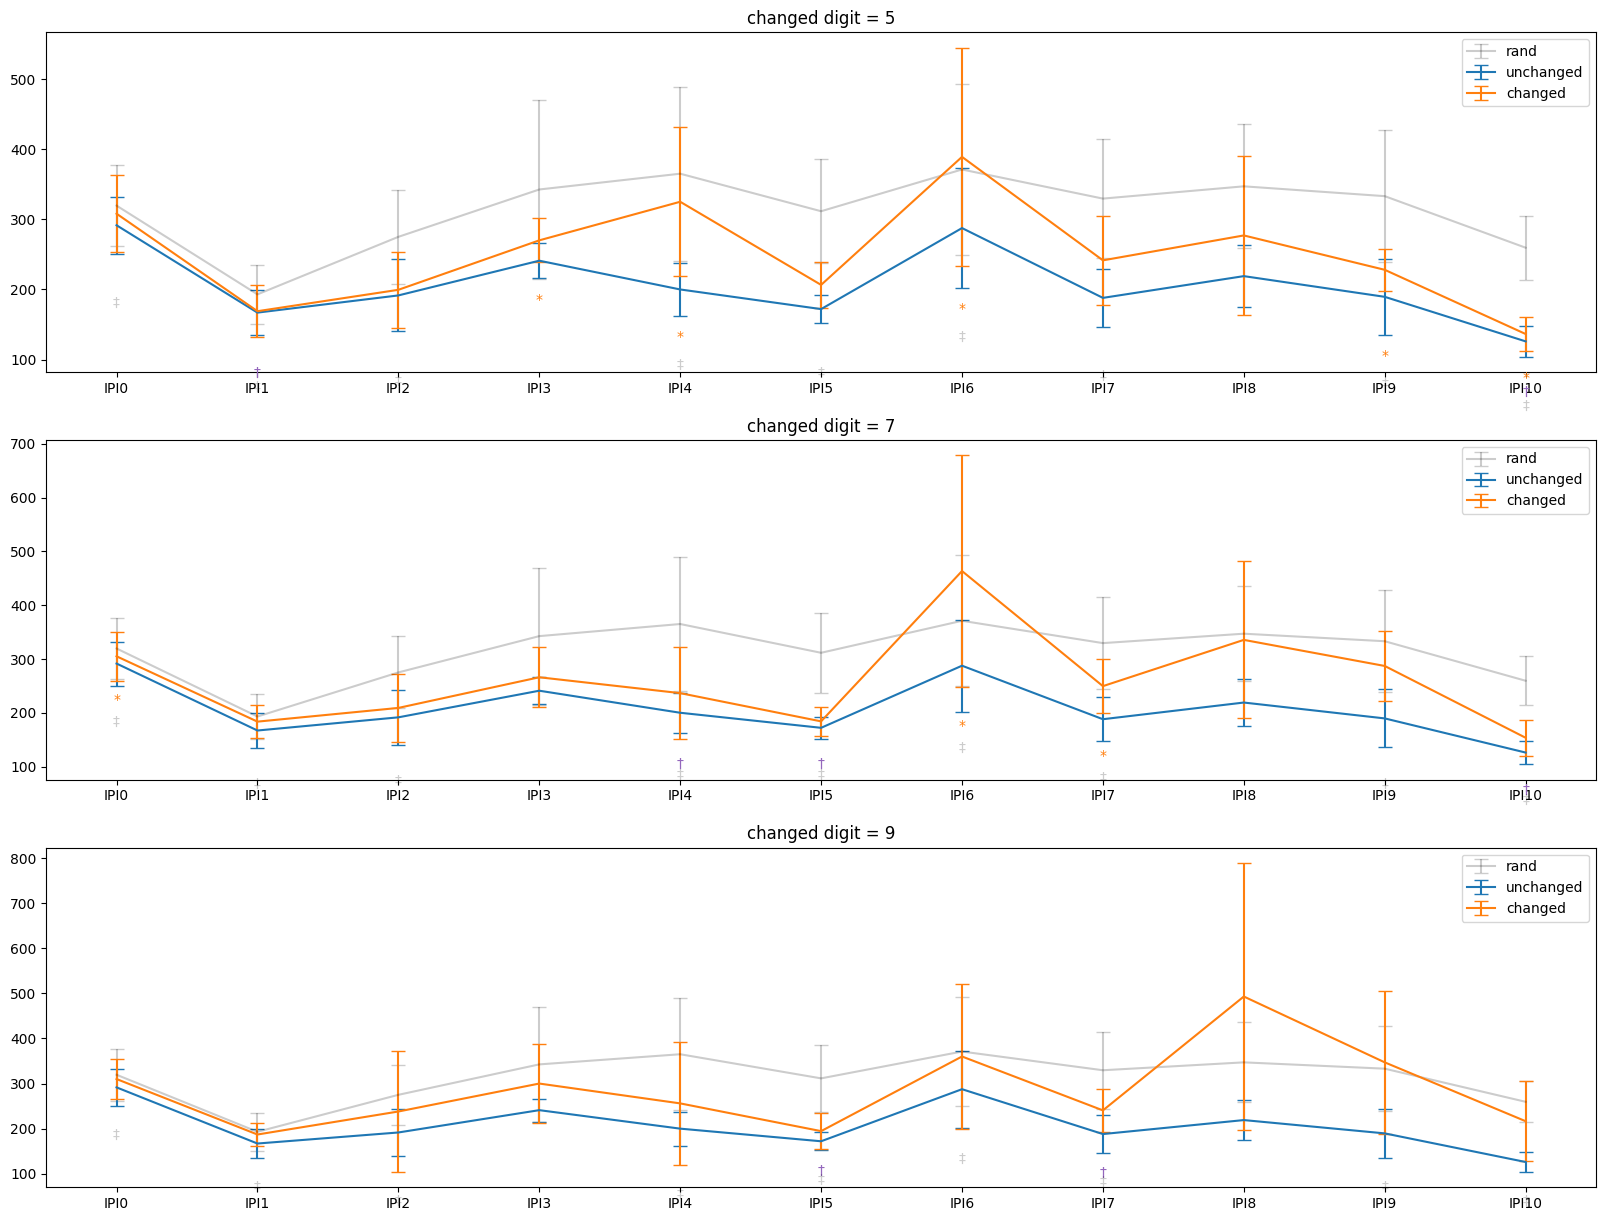

In [63]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}


for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))

    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')

In [111]:
cmap = cm.Pastel1
capsize = 5


session3_blocks = subjs[subjs['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

# session2_blocks = session2_blocks[session2_blocks['SubNum'] != 8]

session3_blocks['norm_MT'] = session3_blocks.apply(utils.correct_error_trial, axis = 1)




for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            for (digit, changed_data) in data.groupby('digitChangePos'):
                for (subnum, sub_data) in changed_data.groupby('SubNum'):
                    if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                         print(f"subj{subnum}_window{window}_changed{digit+1}_acc {len(sub_data[sub_data['isError'] == 0]) / len(sub_data)}")
                        #  if (subnum == 9 and window == 11):
                        #      print(sub_data['norm_MT'])
                        #      print(np.percentile(sub_data['norm_MT'], 0))
    

        if (flag_trained & ~flag_change):

            for (subnum, sub_data) in data.groupby('SubNum'):
                 if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                    print(f"subj{subnum}_window{window}_unchanged_acc {len(sub_data[sub_data['isError'] == 0]) / len(sub_data)}")

        if (flag_rand):
            for (subnum, sub_data) in data.groupby('SubNum'):
                 if(len(sub_data[sub_data['isError'] == 0]) / len(sub_data) < 0.6):
                    print(f"subj{subnum}_window{window}_rand_acc {round(len(sub_data[sub_data['isError'] == 0]) / len(sub_data), 2)}")



subj4_window2_rand_acc 0.56
subj6_window2_changed9_acc 0.5
subj9_window2_changed9_acc 0.5
subj6_window11_rand_acc 0.48
subj3_window11_changed9_acc 0.5
subj4_window11_changed9_acc 0.5
subj9_window11_changed9_acc 0.5


All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            20.4601 2.0000  8.0000 0.0007
windowSize           26.4015 3.0000 12.0000 0.0000
condition:windowSize  3.5555 6.0000 24.0000 0.0116

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            21.5732 1.0000  4.0000 0.0097
windowSize           29.8204 3.0000 12.0000 0.0000
condition:windowSize  2.0523 3.0000 12.0000 0.1603

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            12.6003 1.0000  4.0000 0.0238
windowSize           17.7806 3.0000 12.0000 0.0001
condition:windowSize  1.9632 3.0000 12.0000 0.1734



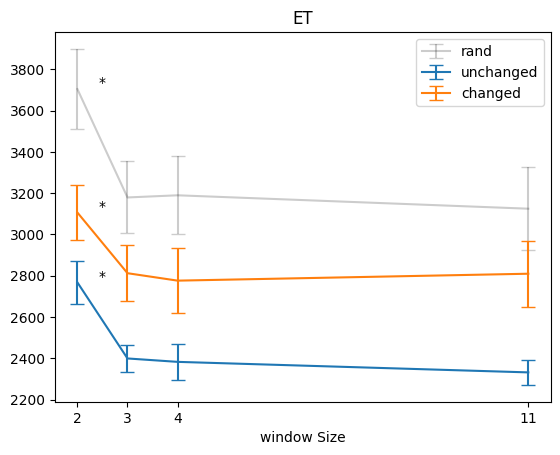

In [64]:
session3_blocks = subjs[subjs['BN'].isin(list(range(8,16)) + list(range(18,26)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data

        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']
    sems = data_agged['norm_MT']['sem']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 
        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


    t_stat, p_value = stats.ttest_rel(
        data[data['windowSize'] == 3]['norm_MT'], 
        data[data['windowSize'] == 11]['norm_MT']
    )
    if p_value < 0.05:
            plt.text((3 + 11) / 2, max(means[1] + sems[1], means[3] + sems[3]) + 10, '*', color='black', ha='center')


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
plt.show()


All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            23.2580 2.0000  8.0000 0.0005
windowSize           23.7840 3.0000 12.0000 0.0000
condition:windowSize  1.2936 6.0000 24.0000 0.2976

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            25.2989 1.0000  4.0000 0.0073
windowSize           25.2194 3.0000 12.0000 0.0000
condition:windowSize  0.6275 3.0000 12.0000 0.6110

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            14.6937 1.0000  4.0000 0.0186
windowSize           17.9106 3.0000 12.0000 0.0001
condition:windowSize  1.3569 3.0000 12.0000 0.3027



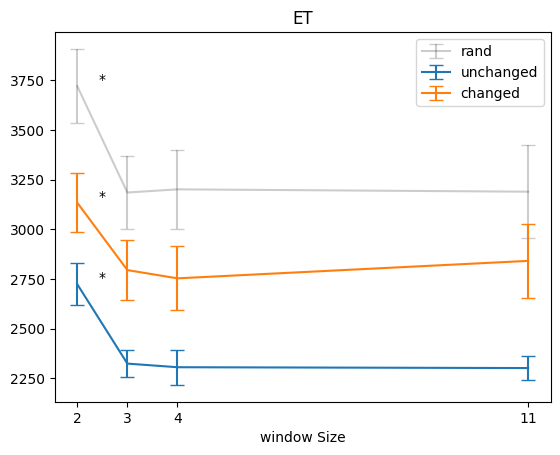

In [65]:
session3_blocks = subjs[subjs['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

session3_blocks['norm_MT'] = session3_blocks.apply(utils.correct_error_trial, axis = 1)

# session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 40)
    }).reset_index()

    finger_aggs[label] = data

        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

    t_stat, p_value = stats.ttest_rel(
        data[data['windowSize'] == 3]['norm_MT'], 
        data[data['windowSize'] == 11]['norm_MT']
    )
    if p_value < 0.05:
            plt.text((3 + 11) / 2, max(means[1] + sems[1], means[3] + sems[3]) + 10, '*', color='black', ha='center')

# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())


plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
plt.show()


All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            36.4311 2.0000 18.0000 0.0000
windowSize            5.8240 3.0000 27.0000 0.0033
condition:windowSize  1.5933 6.0000 54.0000 0.1670

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            50.7012 1.0000  9.0000 0.0001
windowSize            4.1961 3.0000 27.0000 0.0147
condition:windowSize  1.2592 3.0000 27.0000 0.3081

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            23.9798 1.0000  9.0000 0.0009
windowSize            6.7752 3.0000 27.0000 0.0015
condition:windowSize  2.0820 3.0000 27.0000 0.1261



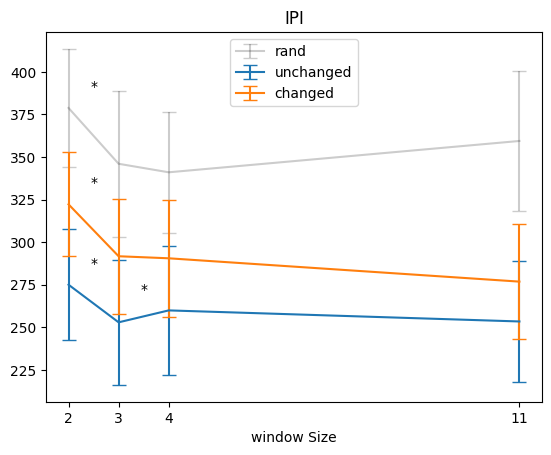

In [116]:
test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        data = data[data['digitChangePos'] == 4]
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'IPI_Value': lambda x: np.percentile(x, 40)
    }).reset_index()

    finger_aggs[label] = data
        
    data_agged = data.groupby('windowSize').agg({
        'IPI_Value': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['IPI_Value']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
            data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['IPI_Value']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('IPI')
plt.legend()
plt.xlabel('window Size')
plt.show()


All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            32.3728 2.0000 18.0000 0.0000
windowSize            4.5046 3.0000 27.0000 0.0109
condition:windowSize  0.5650 6.0000 54.0000 0.7562

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            50.7012 1.0000  9.0000 0.0001
windowSize            4.1961 3.0000 27.0000 0.0147
condition:windowSize  1.2592 3.0000 27.0000 0.3081

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             7.8895 1.0000  9.0000 0.0204
windowSize            2.7381 3.0000 27.0000 0.0629
condition:windowSize  0.5386 3.0000 27.0000 0.6599



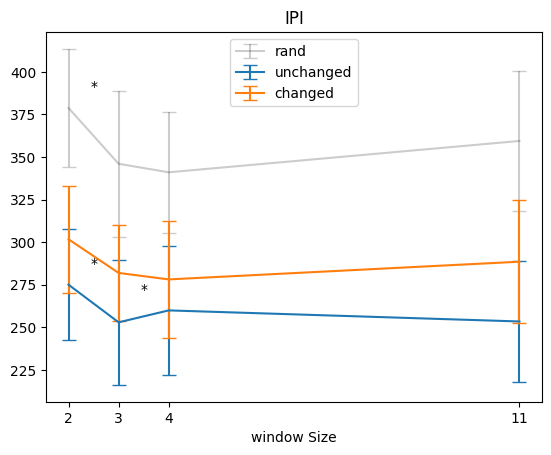

In [118]:
test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        data = data[data['digitChangePos'] == 6]
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'IPI_Value': lambda x: np.percentile(x, 40)
    }).reset_index()

    finger_aggs[label] = data
        
    data_agged = data.groupby('windowSize').agg({
        'IPI_Value': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['IPI_Value']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
            data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['IPI_Value']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('IPI')
plt.legend()
plt.xlabel('window Size')
plt.show()


All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            23.5634 2.0000 18.0000 0.0000
windowSize            6.7060 3.0000 27.0000 0.0016
condition:windowSize  1.3294 6.0000 54.0000 0.2602

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            50.7012 1.0000  9.0000 0.0001
windowSize            4.1961 3.0000 27.0000 0.0147
condition:windowSize  1.2592 3.0000 27.0000 0.3081

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             9.9192 1.0000  9.0000 0.0117
windowSize            4.1346 3.0000 27.0000 0.0155
condition:windowSize  2.5801 3.0000 27.0000 0.0743



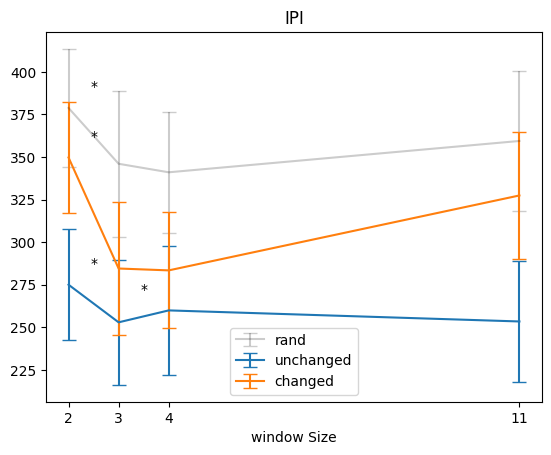

In [119]:
test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        data = data[data['digitChangePos'] == 8]
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'IPI_Value': lambda x: np.percentile(x, 40)
    }).reset_index()

    finger_aggs[label] = data
        
    data_agged = data.groupby('windowSize').agg({
        'IPI_Value': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['IPI_Value']['mean']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
            data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['IPI_Value']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('IPI')
plt.legend()
plt.xlabel('window Size')
plt.show()


************************** IPI4 **************************************
All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            10.8940 2.0000  8.0000 0.0052
windowSize            5.4517 3.0000 12.0000 0.0134
condition:windowSize  1.2115 6.0000 24.0000 0.3346

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            11.2470 1.0000  4.0000 0.0285
windowSize            3.5246 3.0000 12.0000 0.0487
condition:windowSize  0.6360 3.0000 12.0000 0.6060

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            10.9679 1.0000  4.0000 0.0296
windowSize            5.2765 3.0000 12.0000 0.0150
condition:windowSize  1.5151 3.0000 12.0000 0.2609

*************************

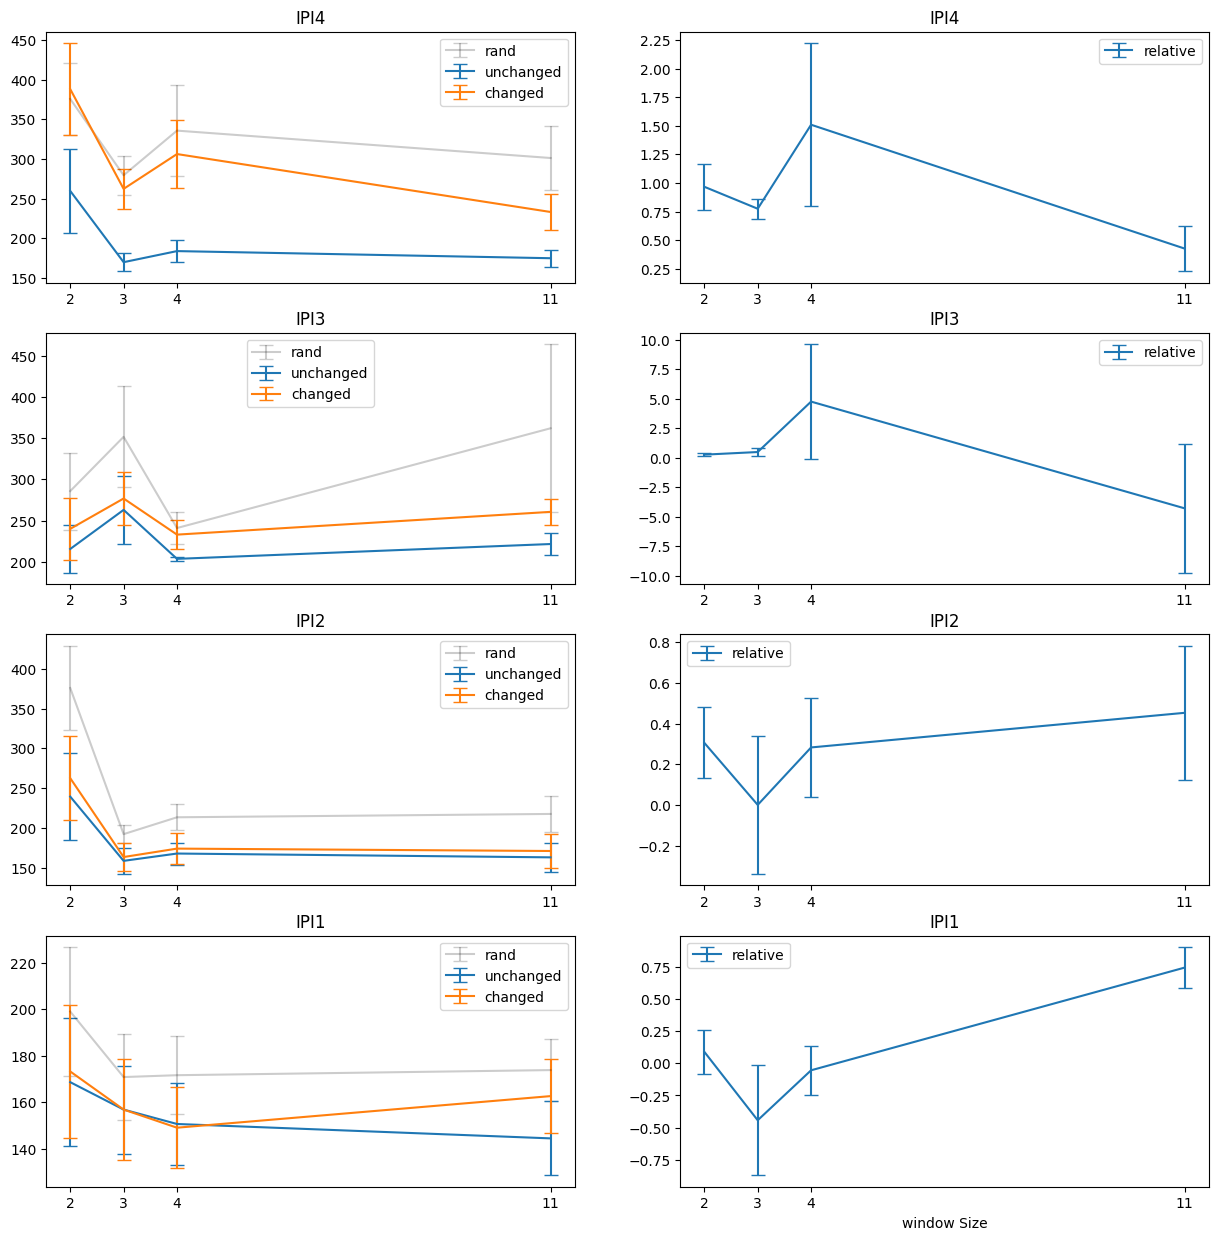

In [66]:
lookahead_window = 4
changed_digit_pos = 4
fig, axs = plt.subplots(nrows=lookahead_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for lookahead in range(lookahead_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['IPI_Number'] == ('IPI' + str(changed_digit_pos - lookahead))].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == changed_digit_pos]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'windowSize']).agg({
        'IPI_Value': lambda x: np.percentile(x, 40)
        }).reset_index()

        finger_aggs[label] = data
  
        data_agged = data.groupby('windowSize').agg({
            'IPI_Value': ['mean', 'sem']
        }).reset_index()

        axs[lookahead, 0].errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

        means = data_agged['IPI_Value']['mean']

        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        axs[lookahead, 0].set_title(f'IPI{changed_digit_pos - lookahead}')
        axs[lookahead, 0].set_xticks(data_agged['windowSize'])
        axs[lookahead, 0].legend()

        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    
    print(f"************************** IPI{changed_digit_pos - lookahead} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())



    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    data_agged = merged_df.groupby('windowSize').agg({
            'rel': ['mean', 'sem']
        }).reset_index()
     
    axs[lookahead, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    axs[lookahead, 1].set_title(f'IPI{changed_digit_pos - lookahead}')
    axs[lookahead, 1].set_xticks(data_agged['windowSize'])
    axs[lookahead, 1].legend()



plt.xlabel('window Size')
plt.show()


************************** IPI6 **************************************
All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             7.2920 2.0000  8.0000 0.0157
windowSize            4.4252 3.0000 12.0000 0.0258
condition:windowSize  0.6395 6.0000 24.0000 0.6977

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            27.9495 1.0000  4.0000 0.0061
windowSize            4.1712 3.0000 12.0000 0.0307
condition:windowSize  0.7155 3.0000 12.0000 0.5614

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             9.0419 1.0000  4.0000 0.0397
windowSize            3.4741 3.0000 12.0000 0.0506
condition:windowSize  0.7534 3.0000 12.0000 0.5413

*************************

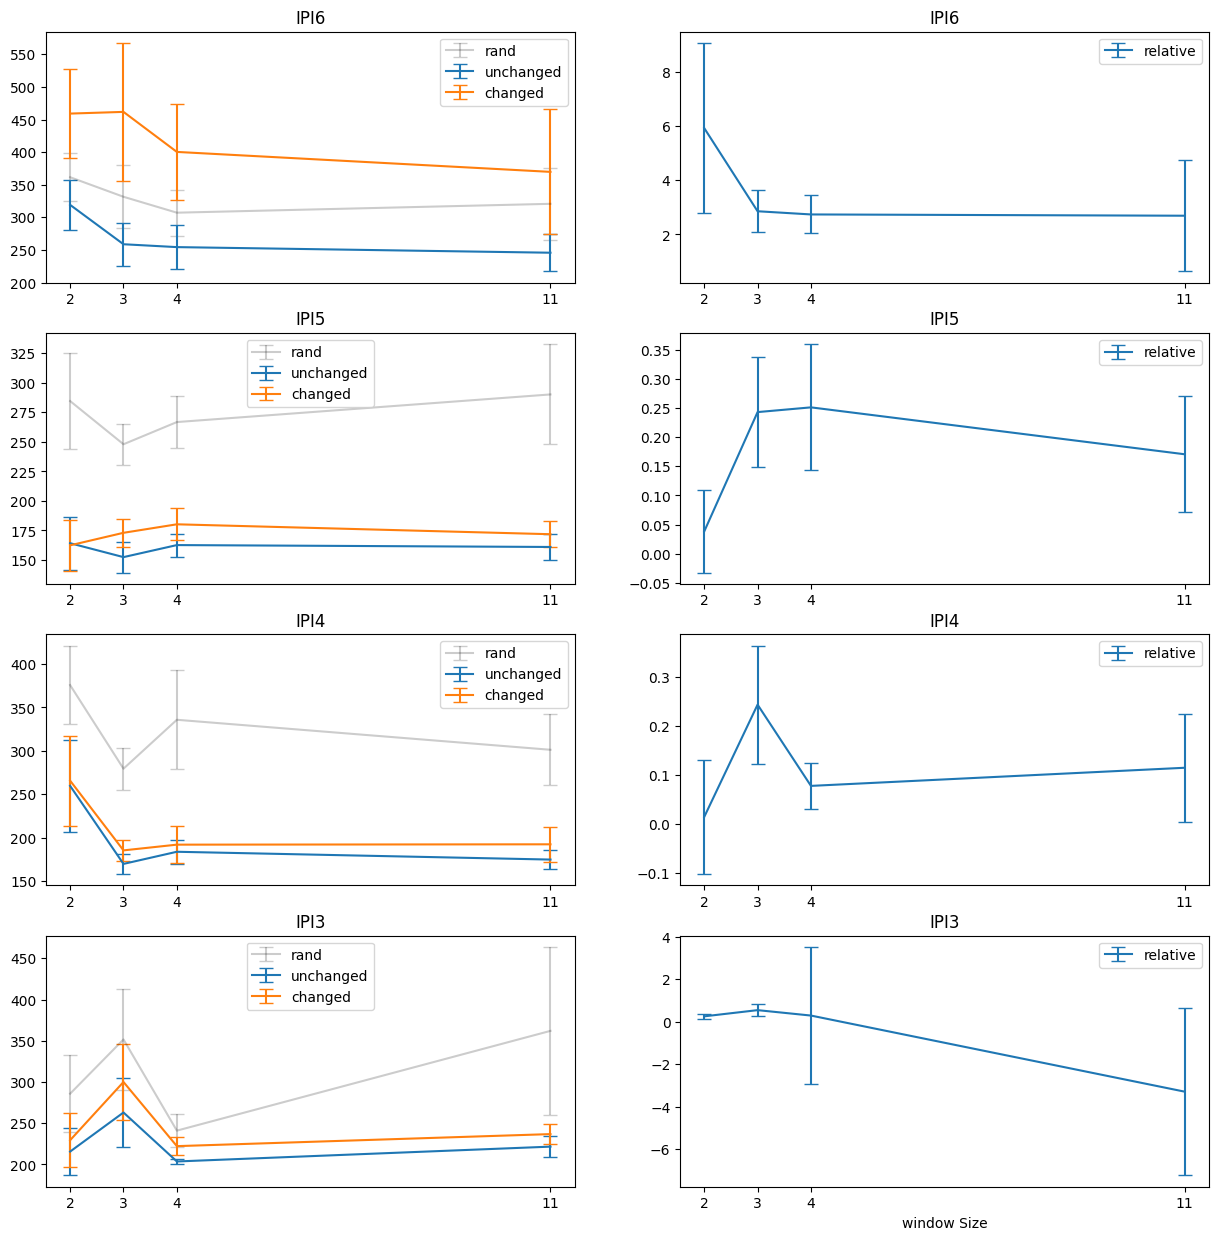

In [67]:
lookahead_window = 4
changed_digit_pos = 6
fig, axs = plt.subplots(nrows=lookahead_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for lookahead in range(lookahead_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['IPI_Number'] == ('IPI' + str(changed_digit_pos - lookahead))].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == changed_digit_pos]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'windowSize']).agg({
        'IPI_Value': lambda x: np.percentile(x, 40)
        }).reset_index()

        finger_aggs[label] = data
  
        data_agged = data.groupby('windowSize').agg({
            'IPI_Value': ['mean', 'sem']
        }).reset_index()

        axs[lookahead, 0].errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

        means = data_agged['IPI_Value']['mean']

        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        axs[lookahead, 0].set_title(f'IPI{changed_digit_pos - lookahead}')
        axs[lookahead, 0].set_xticks(data_agged['windowSize'])
        axs[lookahead, 0].legend()

        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    
    print(f"************************** IPI{changed_digit_pos - lookahead} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())



    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    data_agged = merged_df.groupby('windowSize').agg({
            'rel': ['mean', 'sem']
        }).reset_index()
     
    axs[lookahead, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    axs[lookahead, 1].set_title(f'IPI{changed_digit_pos - lookahead}')
    axs[lookahead, 1].set_xticks(data_agged['windowSize'])
    axs[lookahead, 1].legend()



plt.xlabel('window Size')
plt.show()


************************** IPI8 **************************************
All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             5.2417 2.0000  8.0000 0.0351
windowSize            6.4774 3.0000 12.0000 0.0074
condition:windowSize  0.5174 6.0000 24.0000 0.7893

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             9.0310 1.0000  4.0000 0.0397
windowSize            3.8504 3.0000 12.0000 0.0385
condition:windowSize  0.5247 3.0000 12.0000 0.6735

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             6.3337 1.0000  4.0000 0.0656
windowSize            3.6219 3.0000 12.0000 0.0454
condition:windowSize  0.7442 3.0000 12.0000 0.5461

*************************

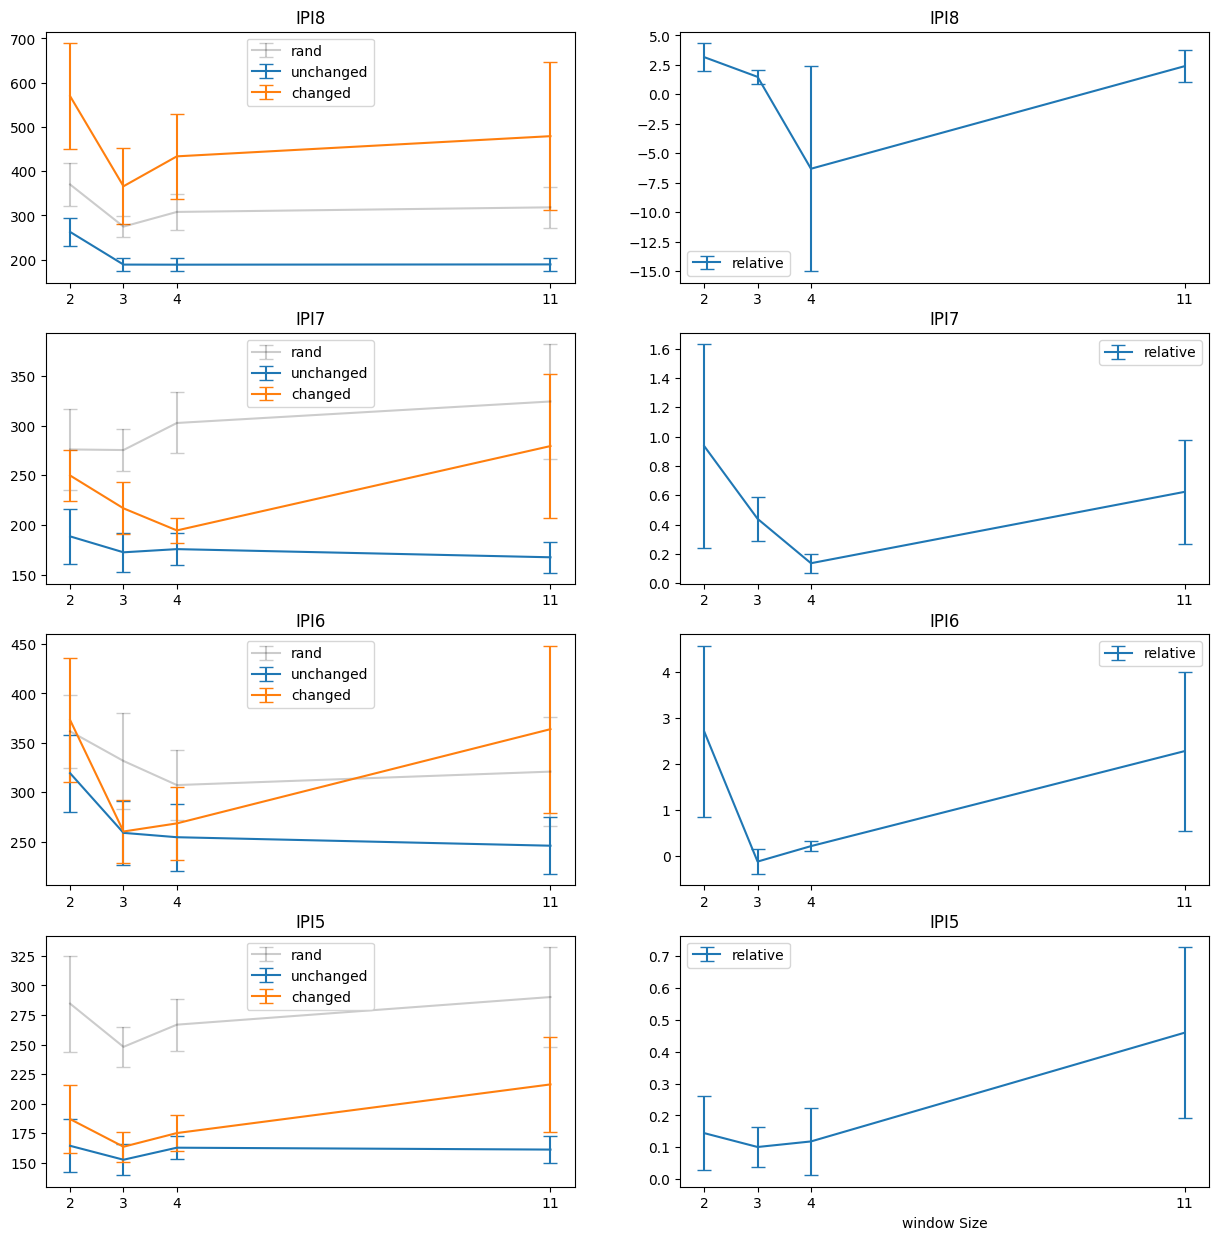

In [68]:
lookahead_window = 4
changed_digit_pos = 8
fig, axs = plt.subplots(nrows=lookahead_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for lookahead in range(lookahead_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['IPI_Number'] == ('IPI' + str(changed_digit_pos - lookahead))].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == changed_digit_pos]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'windowSize']).agg({
        'IPI_Value': lambda x: np.percentile(x, 40)
        }).reset_index()

        finger_aggs[label] = data
  
        data_agged = data.groupby('windowSize').agg({
            'IPI_Value': ['mean', 'sem']
        }).reset_index()

        axs[lookahead, 0].errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

        means = data_agged['IPI_Value']['mean']

        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        axs[lookahead, 0].set_title(f'IPI{changed_digit_pos - lookahead}')
        axs[lookahead, 0].set_xticks(data_agged['windowSize'])
        axs[lookahead, 0].legend()

        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    
    print(f"************************** IPI{changed_digit_pos - lookahead} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())



    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    data_agged = merged_df.groupby('windowSize').agg({
            'rel': ['mean', 'sem']
        }).reset_index()
     
    axs[lookahead, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    axs[lookahead, 1].set_title(f'IPI{changed_digit_pos - lookahead}')
    axs[lookahead, 1].set_xticks(data_agged['windowSize'])
    axs[lookahead, 1].legend()



plt.xlabel('window Size')
plt.show()


IPI:  IPI0 TtestResult(statistic=-0.1598721533954863, pvalue=0.8807300975023986, df=4)
IPI:  IPI1 TtestResult(statistic=4.142549249642578, pvalue=0.014346781435598512, df=4)
IPI:  IPI10 TtestResult(statistic=0.7112867591590193, pvalue=0.5161869943521892, df=4)
IPI:  IPI2 TtestResult(statistic=0.3398874309296699, pvalue=0.7510391155627606, df=4)
IPI:  IPI3 TtestResult(statistic=2.709332495971386, pvalue=0.053574261733527584, df=4)
IPI:  IPI4 TtestResult(statistic=2.2836673685796156, pvalue=0.08444435157379603, df=4)
IPI:  IPI5 TtestResult(statistic=0.9753743423494847, pvalue=0.38460397053671475, df=4)
IPI:  IPI6 TtestResult(statistic=2.4046654951503825, pvalue=0.07398114713938017, df=4)
IPI:  IPI7 TtestResult(statistic=3.4501036382045114, pvalue=0.026051998344972037, df=4)
IPI:  IPI8 TtestResult(statistic=2.2619389008286914, pvalue=0.08649479495171879, df=4)
IPI:  IPI9 TtestResult(statistic=0.7430990748383894, pvalue=0.4986948646016398, df=4)


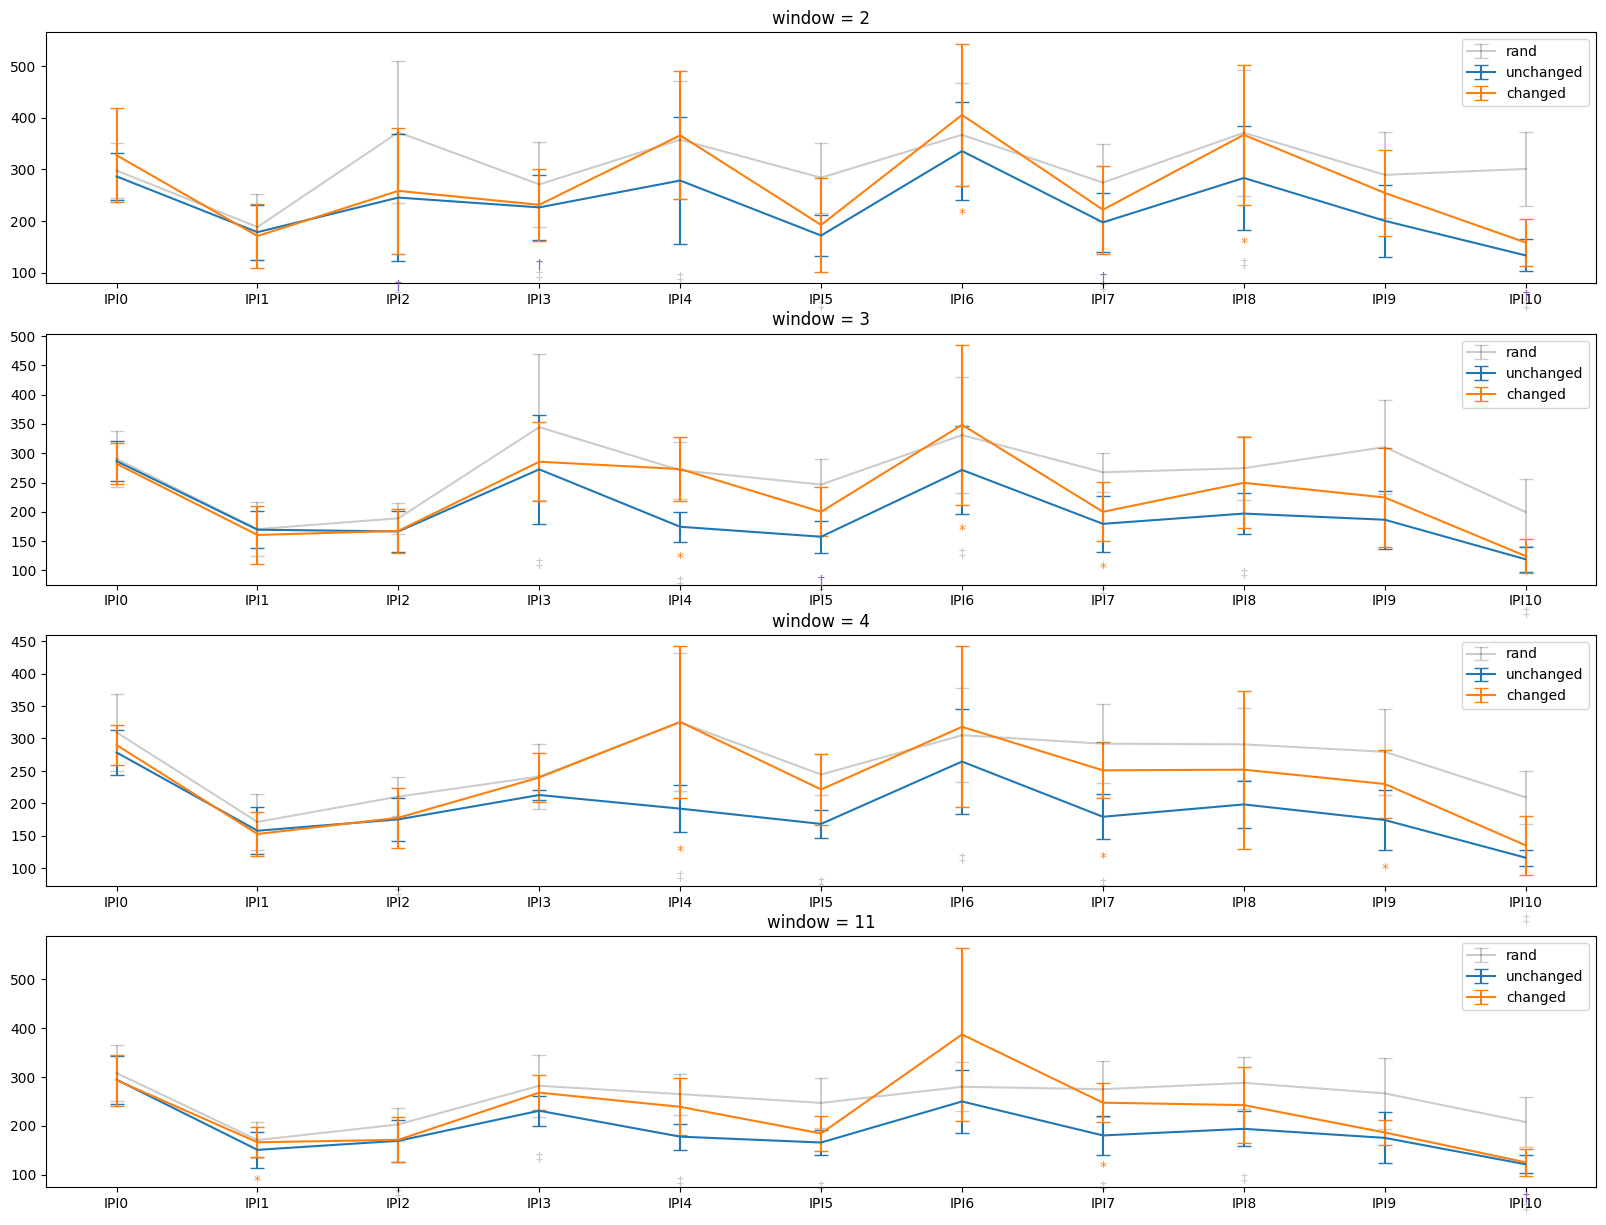

In [69]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 4]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=-0.17793834891438426, pvalue=0.8674192793813592, df=4)
IPI:  IPI1 TtestResult(statistic=2.376918605696208, pvalue=0.07624444547689968, df=4)
IPI:  IPI10 TtestResult(statistic=1.704190094360135, pvalue=0.1635499987888854, df=4)
IPI:  IPI2 TtestResult(statistic=3.3441935709650457, pvalue=0.028723478072069524, df=4)
IPI:  IPI3 TtestResult(statistic=1.7178369696356246, pvalue=0.1609570296846656, df=4)
IPI:  IPI4 TtestResult(statistic=2.806234997976726, pvalue=0.04850247207371765, df=4)
IPI:  IPI5 TtestResult(statistic=1.1307635231542226, pvalue=0.3213593863886309, df=4)
IPI:  IPI6 TtestResult(statistic=2.248129188835063, pvalue=0.08782698976574291, df=4)
IPI:  IPI7 TtestResult(statistic=2.259043685629642, pvalue=0.08677220215884213, df=4)
IPI:  IPI8 TtestResult(statistic=2.356937780216044, pvalue=0.07792283417138718, df=4)
IPI:  IPI9 TtestResult(statistic=0.4577150149398266, pvalue=0.670916761495516, df=4)


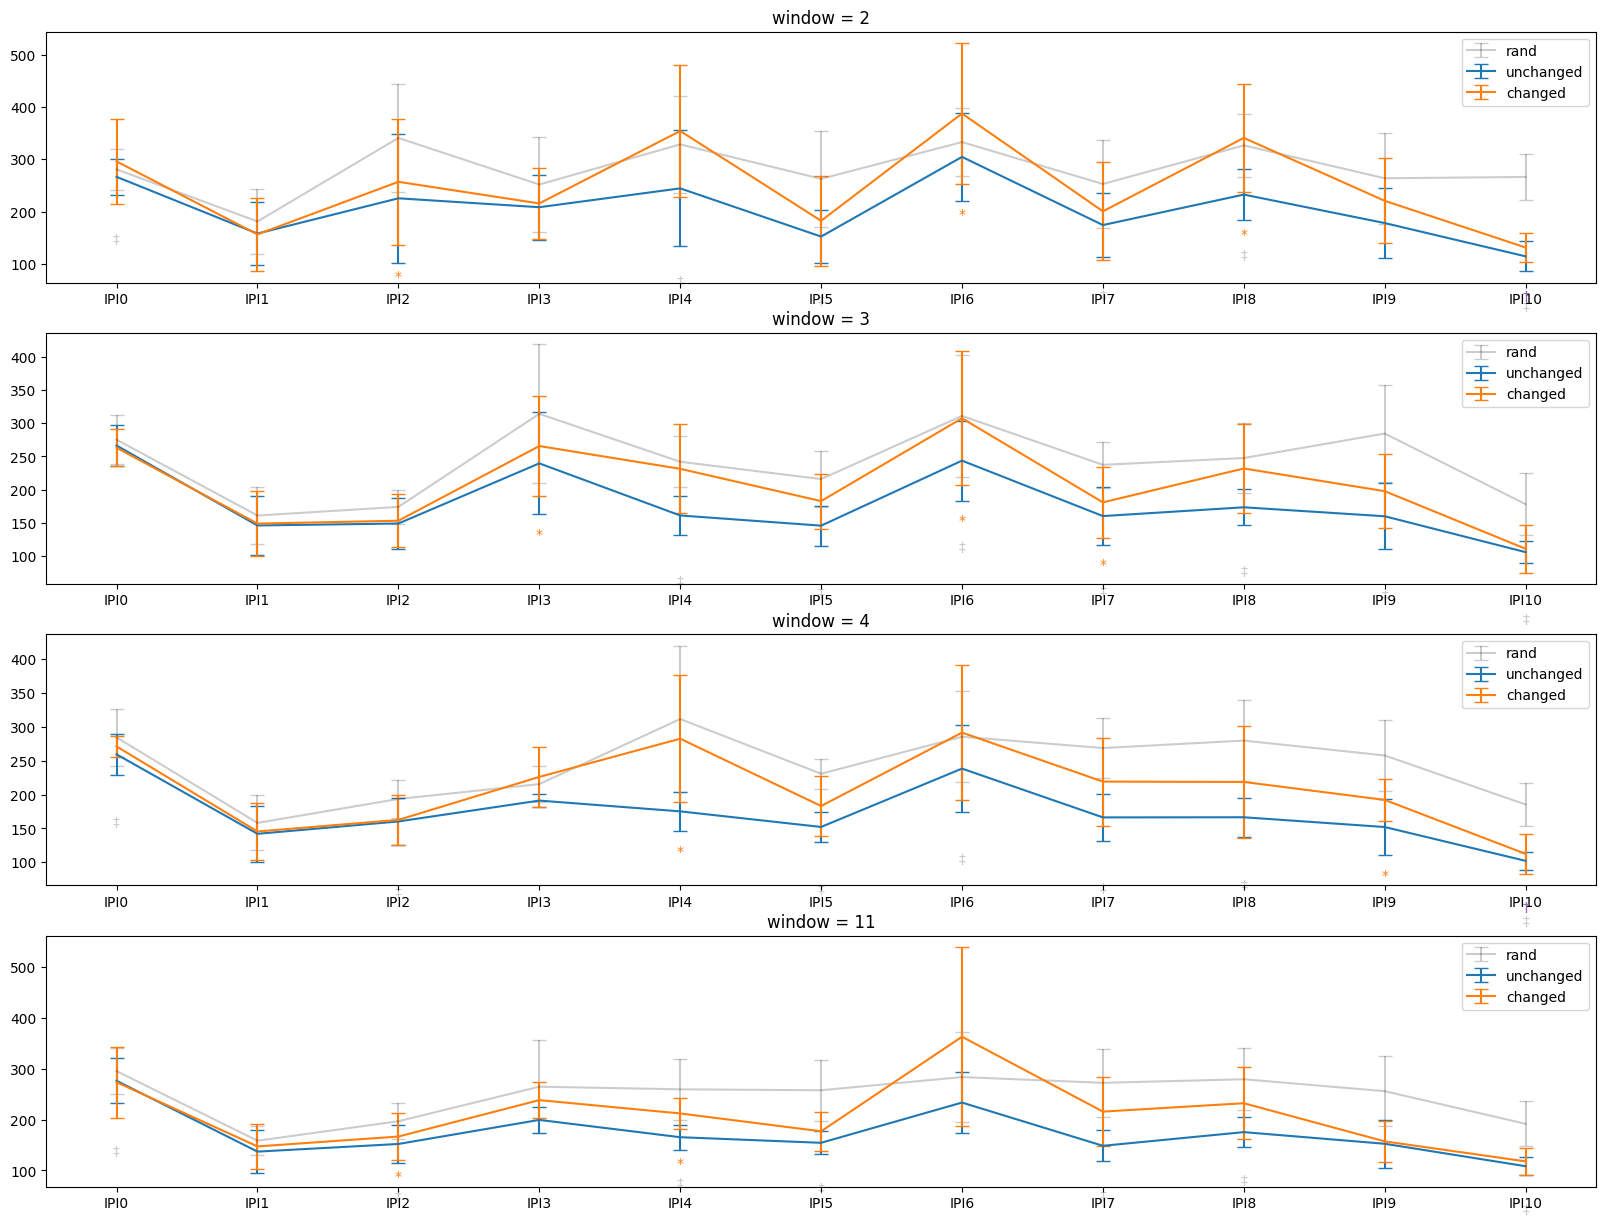

In [70]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

# session3_blocks = session3_blocks[session3_blocks['SubNum'] != 2]

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 4]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 11):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=-0.28346346850812476, pvalue=0.790887779076729, df=4)
IPI:  IPI1 TtestResult(statistic=1.3590417710722233, pvalue=0.24571213033759423, df=4)
IPI:  IPI10 TtestResult(statistic=0.5121475197315839, pvalue=0.6355287029763259, df=4)
IPI:  IPI2 TtestResult(statistic=-1.6269784336399213, pvalue=0.1790703787475794, df=4)
IPI:  IPI3 TtestResult(statistic=0.607332247634187, pvalue=0.5764190089373955, df=4)
IPI:  IPI4 TtestResult(statistic=-0.2873478855663454, pvalue=0.7881176570369854, df=4)
IPI:  IPI5 TtestResult(statistic=3.0656252628831178, pvalue=0.03745236332329232, df=4)
IPI:  IPI6 TtestResult(statistic=3.3337147173413073, pvalue=0.02900505394158073, df=4)
IPI:  IPI7 TtestResult(statistic=2.043687449073322, pvalue=0.11047963922042726, df=4)
IPI:  IPI8 TtestResult(statistic=2.0166075526119296, pvalue=0.11393734966127868, df=4)
IPI:  IPI9 TtestResult(statistic=2.518992604397082, pvalue=0.06542696343261921, df=4)


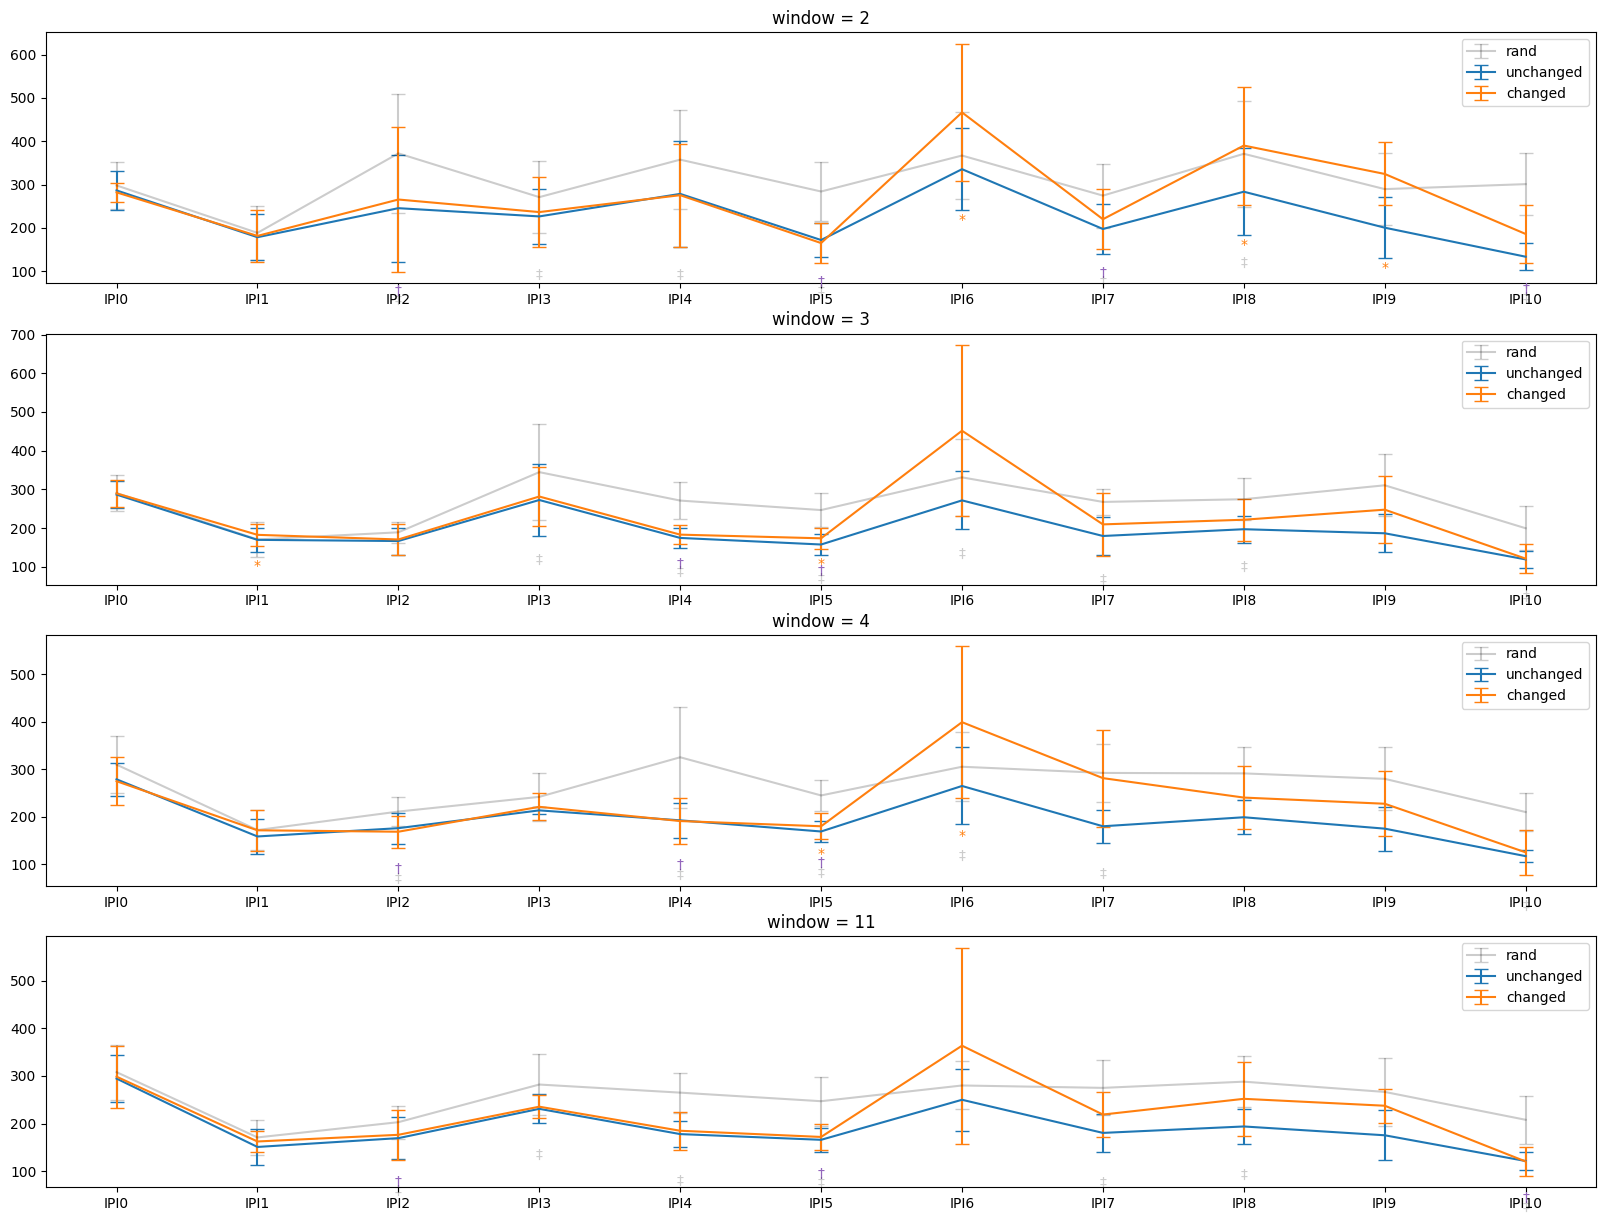

In [71]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 6]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=0.8226935270257342, pvalue=0.45689797608107363, df=4)
IPI:  IPI1 TtestResult(statistic=2.0103621328432535, pvalue=0.11475154493638343, df=4)
IPI:  IPI10 TtestResult(statistic=0.858145083988658, pvalue=0.4391908657948619, df=4)
IPI:  IPI2 TtestResult(statistic=-0.9582793894337017, pvalue=0.39218829817944373, df=4)
IPI:  IPI3 TtestResult(statistic=0.36361555337855433, pvalue=0.7345483986612913, df=4)
IPI:  IPI4 TtestResult(statistic=0.5444140375720803, pvalue=0.6150842631765041, df=4)
IPI:  IPI5 TtestResult(statistic=3.9191930539712274, pvalue=0.017259424499729014, df=4)
IPI:  IPI6 TtestResult(statistic=3.118103185696805, pvalue=0.03559181463801627, df=4)
IPI:  IPI7 TtestResult(statistic=1.74948289607789, pvalue=0.15510986637428037, df=4)
IPI:  IPI8 TtestResult(statistic=2.2246642602954596, pvalue=0.09014365261947062, df=4)
IPI:  IPI9 TtestResult(statistic=2.23365105307351, pvalue=0.08924840981378003, df=4)


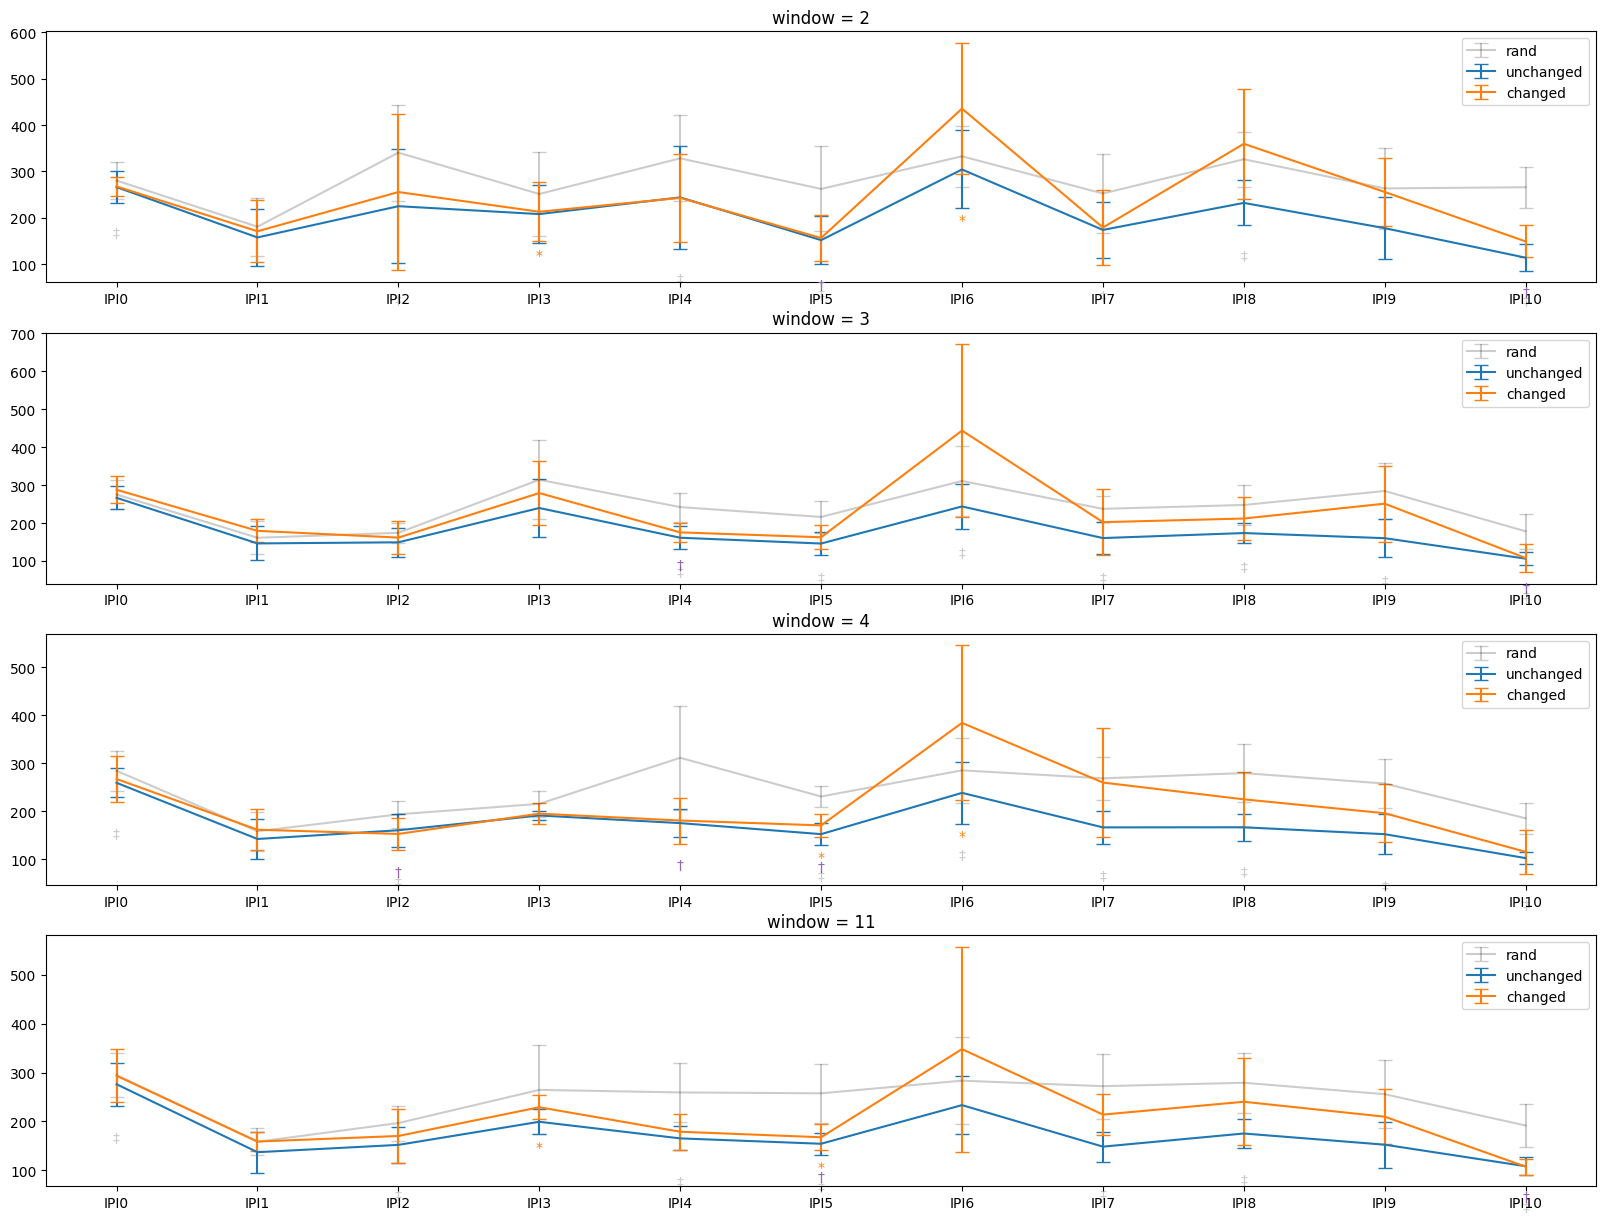

In [72]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

# session3_blocks = session3_blocks[session3_blocks['SubNum'] != 2]

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 6]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=0.9644856443408243, pvalue=0.3894201493236102, df=4)
IPI:  IPI1 TtestResult(statistic=0.0, pvalue=1.0, df=4)
IPI:  IPI10 TtestResult(statistic=4.081808058298845, pvalue=0.015076042764721857, df=4)
IPI:  IPI2 TtestResult(statistic=0.1111111111111111, pvalue=0.9168803090579426, df=4)
IPI:  IPI3 TtestResult(statistic=2.507849312877596, pvalue=0.06620915792306752, df=4)
IPI:  IPI4 TtestResult(statistic=-0.8304547985373997, pvalue=0.4529735006015081, df=4)
IPI:  IPI5 TtestResult(statistic=0.6993786061802354, pvalue=0.5228493601628514, df=4)
IPI:  IPI6 TtestResult(statistic=0.5129891760425771, pvalue=0.634990275277812, df=4)
IPI:  IPI7 TtestResult(statistic=1.6878498775964426, pvalue=0.1667127116856802, df=4)
IPI:  IPI8 TtestResult(statistic=2.760604595477694, pvalue=0.05081808925245447, df=4)
IPI:  IPI9 TtestResult(statistic=2.310831164067199, pvalue=0.08195742588731073, df=4)


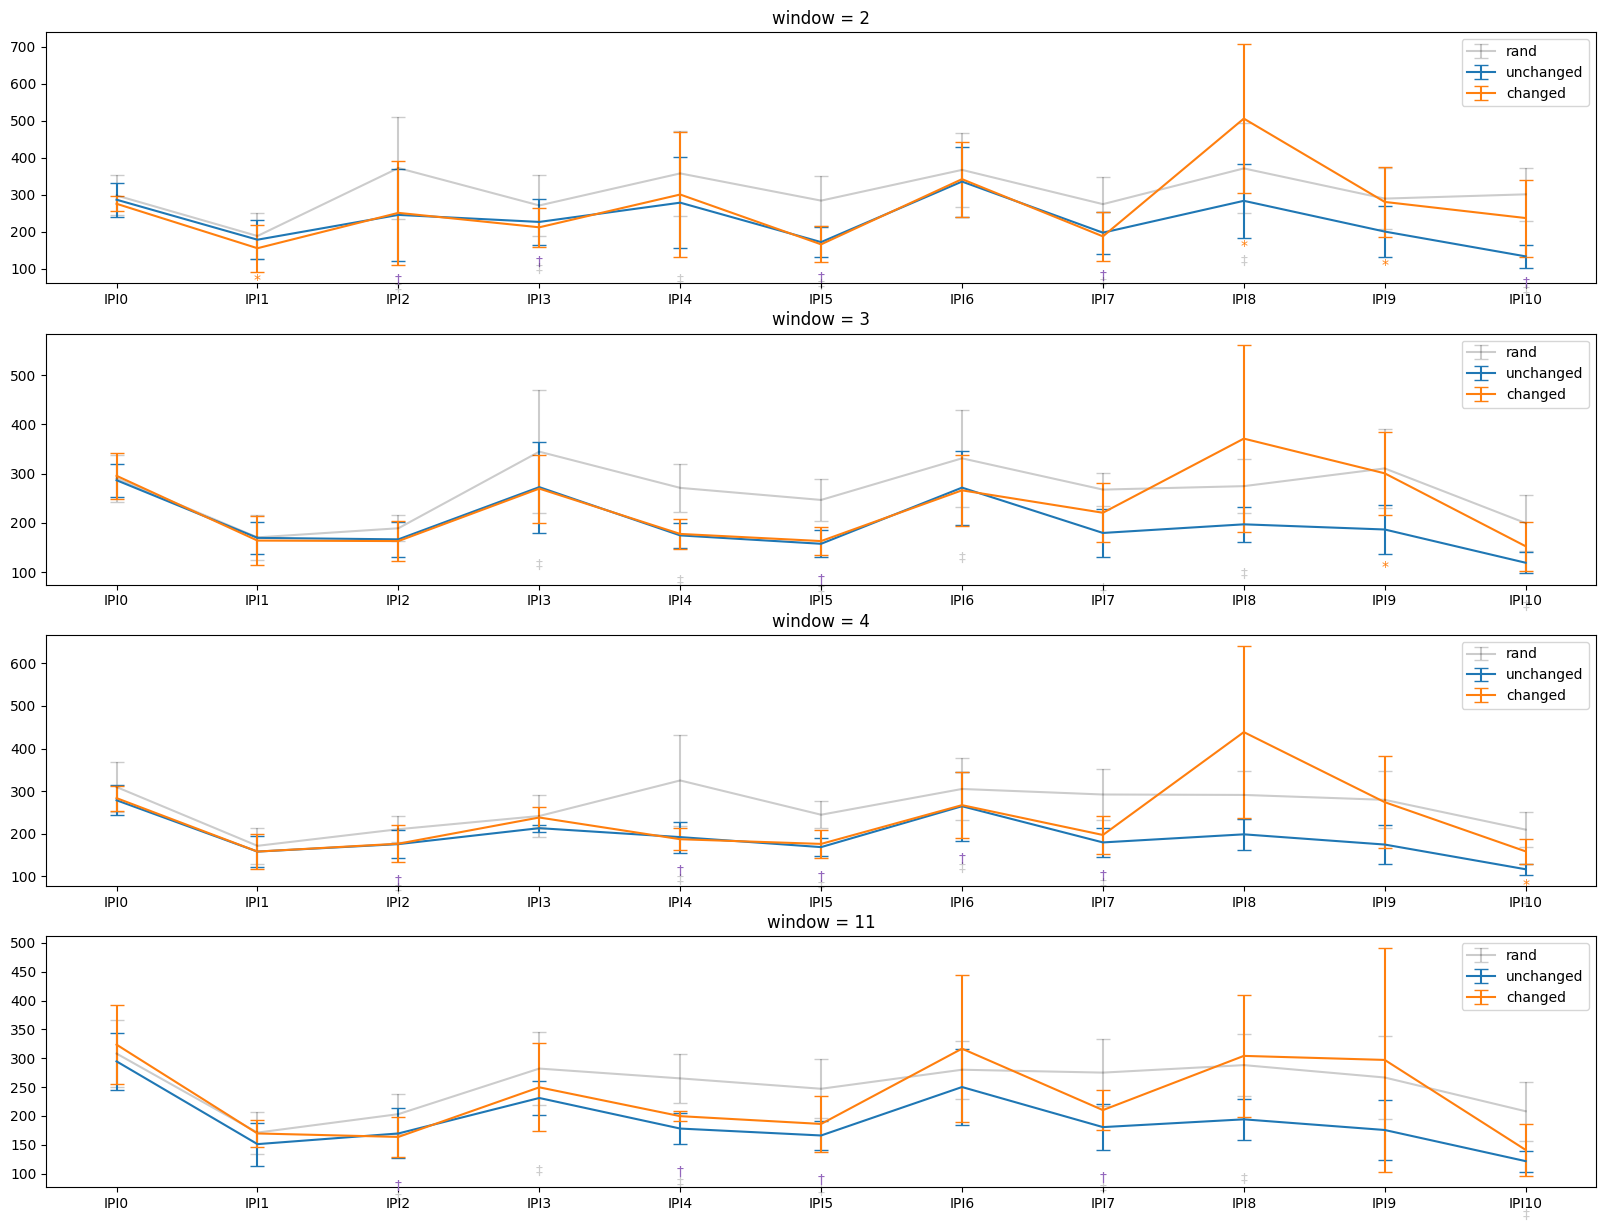

In [73]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 8]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


IPI:  IPI0 TtestResult(statistic=1.8590639867314527, pvalue=0.13654834837228177, df=4)
IPI:  IPI1 TtestResult(statistic=3.1778881230311327, pvalue=0.03360303110081955, df=4)
IPI:  IPI10 TtestResult(statistic=4.357542134733635, pvalue=0.012085388087957304, df=4)
IPI:  IPI2 TtestResult(statistic=0.9642537048226649, pvalue=0.3895232987319354, df=4)
IPI:  IPI3 TtestResult(statistic=2.7156095661904582, pvalue=0.053227714400443084, df=4)
IPI:  IPI4 TtestResult(statistic=1.9894632808597248, pvalue=0.1175227485827563, df=4)
IPI:  IPI5 TtestResult(statistic=1.263869832690859, pvalue=0.27491356226667435, df=4)
IPI:  IPI6 TtestResult(statistic=1.6590296761587509, pvalue=0.17244849585686678, df=4)
IPI:  IPI7 TtestResult(statistic=1.174987169278656, pvalue=0.30516921372992745, df=4)
IPI:  IPI8 TtestResult(statistic=2.404962549012985, pvalue=0.07395733207096693, df=4)
IPI:  IPI9 TtestResult(statistic=2.1015288343121963, pvalue=0.10347456874380336, df=4)


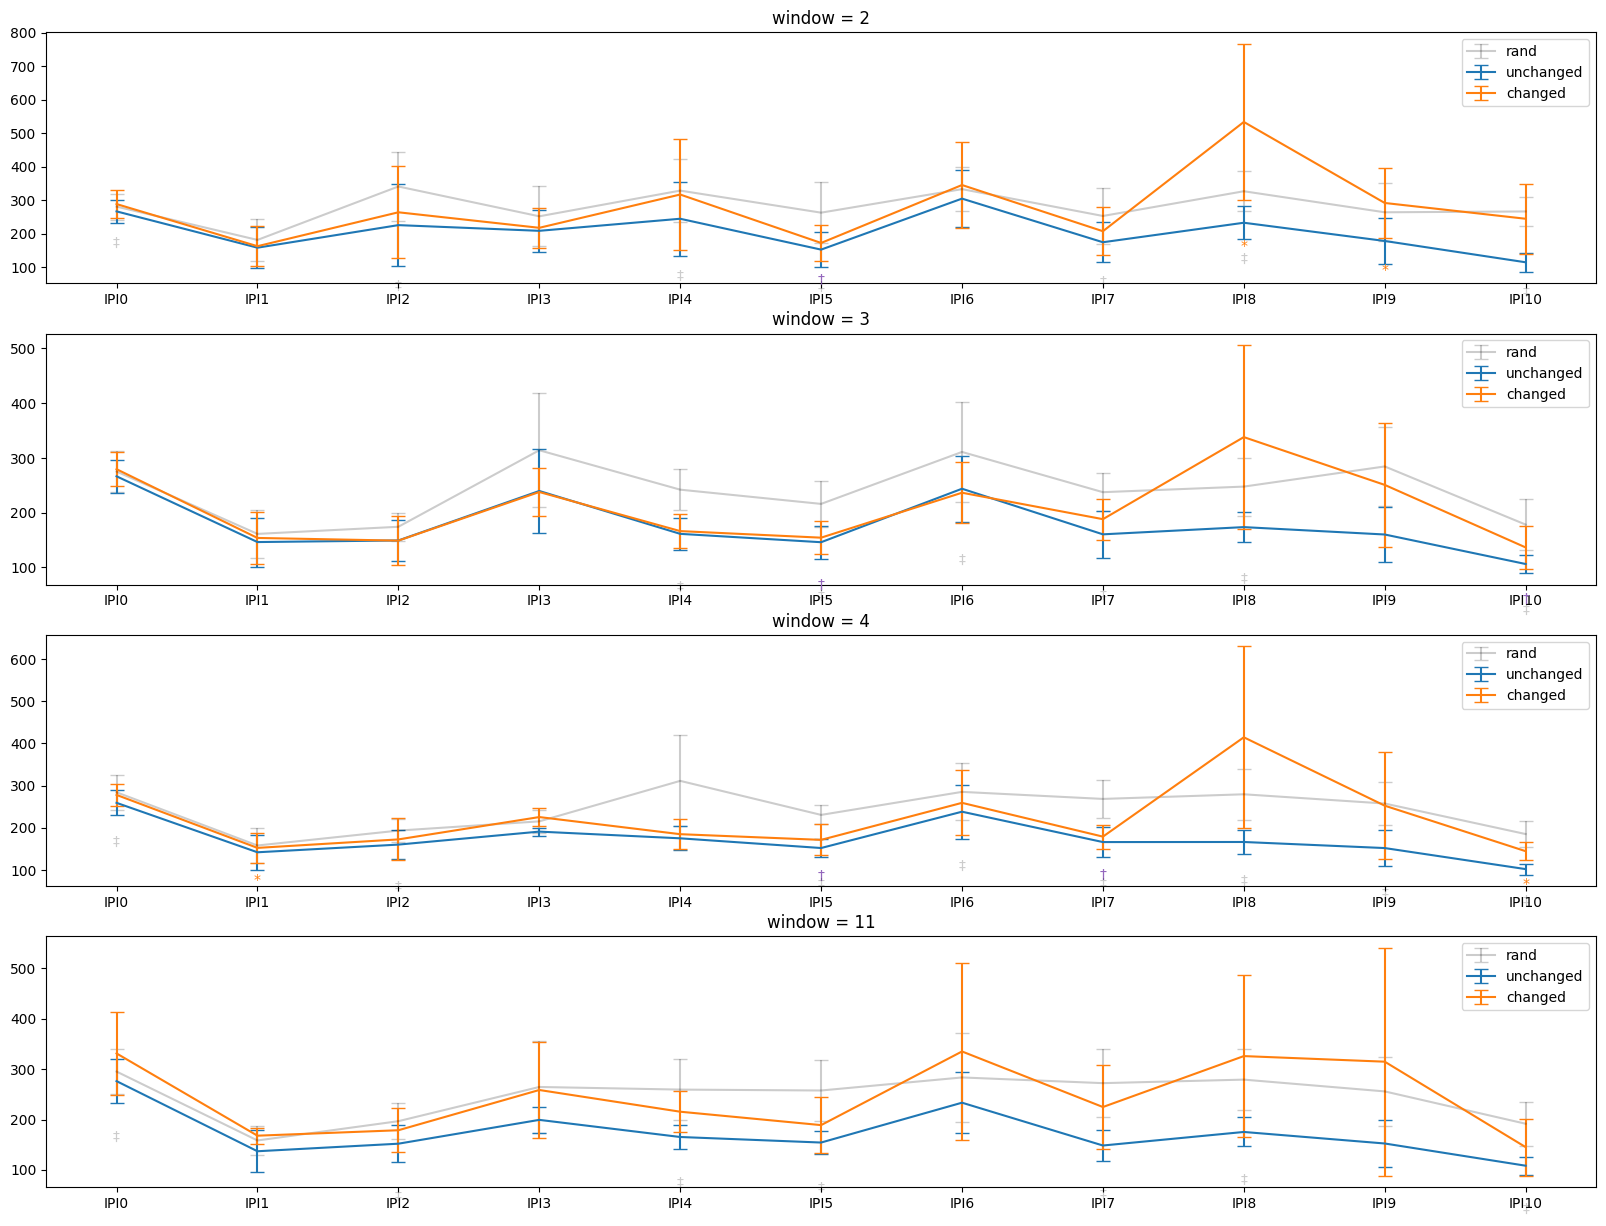

In [74]:
fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))].copy()

# session3_blocks = session3_blocks[session3_blocks['SubNum'] != 2]

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_trial_IPI, axis = 1)


finger_aggs = {}

for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks[session3_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[data['digitChangePos'] == 8]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': lambda x: np.percentile(x, 30)
            # 'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])


    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(window == 4):
            print('IPI: ', IPI, ttest_changed_vs_unchanged)
            # if(IPI == 'IPI10'):
            #     IPI_diff = IPI_data['IPI_Value_changed'] - IPI_data['IPI_Value_unchanged']
            #     print(np.mean(IPI_diff))
            #     print(np.std(IPI_diff))
    
    axs[idx].legend()

    axs[idx].set_title(f'window = {window}')


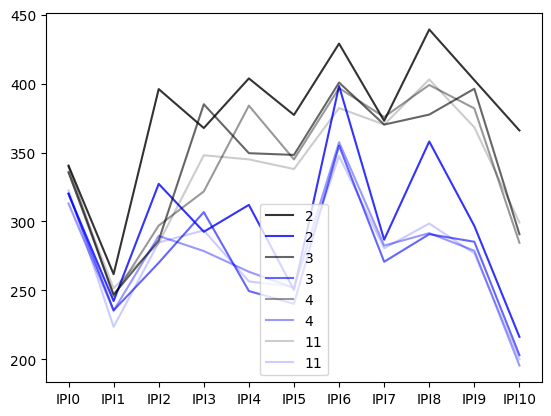

In [125]:
# fig, axs = plt.subplots(len(windowSizes), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5


test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(8,16)) + list(range(18,26)))]

test_blocks = utils.remove_error_trials_presses(test_blocks)



for idx, window in enumerate(windowSizes):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['windowSize'] == window].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & ~flag_change):

            finger_agg_unchnaged = data.groupby(['SubNum', 'IPI_Number']).agg({
                'IPI_Value': 'median'
            }).reset_index()


            finger_agg_unchnaged = finger_agg_unchnaged.groupby(['IPI_Number']).agg({
                'IPI_Value': ['mean', 'sem']
            }).reset_index()

            finger_agg_unchnaged = finger_agg_unchnaged.iloc[index_natsorted(finger_agg_unchnaged['IPI_Number'])].reset_index(drop=True)
            # plt.errorbar(finger_agg_unchnaged['IPI_Number'], finger_agg_unchnaged['IPI_Value']['mean'], yerr = finger_agg_unchnaged['IPI_Value']['sem'], label = window, capsize = capsize,alpha = (len(windowSizes) - idx)/(len(windowSizes)+1), color = 'blue')

            plt.errorbar(finger_agg_unchnaged['IPI_Number'], finger_agg_unchnaged['IPI_Value']['mean'], label = window, alpha = (len(windowSizes) - idx)/(len(windowSizes)+1), color = 'blue')



        if (flag_rand):

            finger_agg_rand = data.groupby(['SubNum', 'IPI_Number']).agg({
                'IPI_Value': 'median'
            }).reset_index()

            finger_agg_rand = finger_agg_rand.groupby(['IPI_Number']).agg({
                'IPI_Value': ['mean', 'std']
            }).reset_index()

            finger_agg_rand = finger_agg_rand.iloc[index_natsorted(finger_agg_rand['IPI_Number'])].reset_index(drop=True)
            # plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['std'], color = 'black', label = window, capsize = capsize, alpha = 0.2)
            plt.errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], label = window, capsize = capsize, alpha = (len(windowSizes) - idx)/(len(windowSizes)+1), color = 'black')


    
    plt.legend()

    # axs[idx].set_title(f'window = {window}')


## Mov Files:

In [ ]:
def movload(fname):
    # loads .mov files given the path of the file. The .mov files have a specific custom hence the need for a custom function
    A = []
    fid = open(fname, 'rt')
    if fid == -1:
        raise Exception('Could not open ' + fname)


    num_columns = None 

    trial = 0
    for line in fid:
        if line[0] == 'T':
            print('Trial: ', line.split()[1])
            a = int(line.split()[1])
            trial += 1
            if a != trial:
                print('Trials out of sequence')
                trial = a
            A.append([])
            num_columns = None
            # A[trial-1] = np.empty((0,8))
        else:
            lineData = line.strip().split('\t')
            if num_columns is None:
                num_columns = len(lineData)
                A[trial - 1] = np.empty((0, num_columns))
            a = np.array([float(x) for x in lineData], ndmin=2)
            # print(a)
            A[trial-1] = np.vstack((A[trial-1],a))
            # A[trial-1].extend(a)

    fid.close()
    return A

In [ ]:
trials = movload('SDI1/SequenceDigitInterference_3_07.mov')

In [ ]:
dfs = []

for trial in trials:
    dfs.append(pd.DataFrame(trial, columns=['state', 'timeReal', 'time', 'force1', 'force2', 'force3', 'force4', 'force5']))

In [ ]:
for i in range(1,6):
    plt.plot(dfs[2]['time'], dfs[2][f'force{i}'], label = i)

plt.legend()